**Autores:**
- David Moreno Vituri
- Ricardo Sánchez Olivares
- Íñigo Alegre Jiménez

# Objetivos: MODELO DE PROPENSIÓN A COMPRA

---
## Propuesta de valor
El objetivo de este ejercicio es estimar la probabilidad de que una cliente compre cierto producto o no, es decir, realizar un modelo de propensión a compra

## Motivaciones para resolverlo
La creación de un modelo predictivo podría ayudar a la empresa en:

- **Optimización de campañas de marketing**: Permite identificar a los clientes más propensos a comprar, optimizando el gasto en marketing al dirigir las campañas hacia aquellos con mayores probabilidades de conversión. Esto reduce los costos y aumenta la efectividad.

- **Segmentación de clientes**: Ayuda a clasificar a los clientes según su probabilidad de compra, permitiendo una personalización más efectiva de las ofertas, promociones y recomendaciones.

- **Retención de clientes**: El modelo puede identificar a aquellos clientes con menor propensión a comprar, lo que facilita la implementación de estrategias de retención o de recompra para evitar la pérdida de estos clientes.

- **Previsión de ingresos**: Al predecir qué clientes realizarán compras, las empresas pueden estimar los ingresos futuros y ajustar sus estrategias comerciales y operativas.

- **Asignación de recursos**: Ayuda a la toma de decisiones respecto a la asignación de recursos, priorizando la atención a los clientes con mayor probabilidad de compra.

---
## Orígenes de datos
Los datos usados en este ejercicio se obtienen tras realizar un procesado de las tablas proporcionadas por Frank, el director de IT. El procesamiento se puede seguir en el jupyter notebook llamado CAPSTONE. Cada fila del dataset corresponde a un cliente único, identificada por el campo **cid**. El *target* es la variable **Compra_producto**, que indica si el cliente ha comprado o no el producto X.

---

## Tarea de ML
El problema de estimar la probabilidad de que cliente compre o no cierto producto corresponde a una tarea de clasificación binaria supervisada.

- Supervisada: Porque tenemos un conjunto de datos etiquetados donde sabemos si cliente ha comprado cierto producto o no, y utilizamos esta información para entrenar el modelo.

- Clasificación binaria: Porque el resultado deseado es una categoría (compra o no compra) en lugar de un valor continuo o numerosas categorías.

## Algoritmos posibles

Para la resolución de esta tarea de clasificación supervisada vamos a implementar cuatro modelos de clasificación: LightGBM, XGBoost, CatBoost y LogisticRegression.

Compararemos los resultados obtenidos por los cuatro y nos quedaremos con aquel que sea más eficiente en la tarea que nos incumbe (ser capaces de identificar aquellos potenciales compradores del producto).

---

<a id='index'></a>
## Índice

[Importación de librerías](#importacion_librerias)<br>


## Data Understanding
[EDA](#eda)<br>
[Análisis Univariante](#analisis_univariante)<br>
[Análisis Multivariante](#analisis_multivariante)<br>


## Data Preparation
[Creación de dataframe a predecir](#dataframe_predecir)<br>
[Transformación de atributos](#transformacion)<br>

## Modelling
[Partición y muestreo del dataset](#particionymuestreo)<br>
[XGBoost](#XGB)<br>
[LightGBM](#LightGBM)<br>
[CatBoost](#CatBoost)<br>
[Logistic Regression](#logistic)<br>



<a id='importacion_librerias'></a>
# Importación de librerías
[Volver al índice](#index)

En este apartado hacemos la importación de las principales librerías y métodos que usaremos a lo largo del dataset.

In [189]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100


# librerías para crear gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# módulos de sklearn 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn import metrics

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# otros modelos
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

# DATA UNDERSTANDING

<a id='eda'></a>
## Data Understanding - EDA
[Volver al índice](#index)

En este apartado importamos los datasets necesarios para construir el dataset que finalmente usaremos para entrenar nuestro modelo. Una vez creado, observamos el tamaño del mismo, el tipo de variables disponibles (numéricos, categóricos), los estadísticos descriptivos más relevantes de cada variable(valores medios, dispersión, percentiles, etc.) y el número de valores nulos.

In [190]:
# importación de los datasets
producto = 'debit_card'

df = pd.read_pickle(producto+'.pkl')
info_clientes = pd.read_pickle('info_clientes.pkl')

df.head()

,cid,pk_partition,country_id,region_code,gender,age,deceased,salary,entry_date,entry_channel,active_customer,segment,entry_date_year,entry_date_month,pk_partition_year,pk_partition_month,tipo_cliente,Compra_debit_card
0,1517558,2019-01-01,ES,23,V,41,N,NaN,2018-12-01,KHN,1.0,02 - PARTICULARES,2018,12,2019,1,Cliente_existente,1
1,1161959,2019-01-01,ES,12,H,26,N,39287.91,2016-08-01,KAT,0.0,03 - UNIVERSITARIO,2016,8,2019,1,Cliente_existente,0
2,1100492,2019-01-01,ES,28,H,23,N,35177.97,2015-11-01,KHE,0.0,03 - UNIVERSITARIO,2015,11,2019,1,Cliente_existente,0
3,1391462,2019-01-01,ES,24,V,48,N,69824.28,2018-04-01,KHN,0.0,01 - TOP,2018,4,2019,1,Cliente_existente,1
4,1391434,2019-01-01,ES,8,V,56,N,NaN,2018-04-01,KHK,1.0,02 - PARTICULARES,2018,4,2019,1,Cliente_existente,1


In [191]:
# realizamos una copia para así en un futuro poder hacer merge que sean útiles
df_fechas = df.copy()
info_clientes_2 = info_clientes.copy()

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22653 entries, 0 to 22652
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   cid                 22653 non-null  int64         
 1   pk_partition        22653 non-null  datetime64[ns]
 2   country_id          22653 non-null  object        
 3   region_code         22653 non-null  int32         
 4   gender              22653 non-null  object        
 5   age                 22653 non-null  int64         
 6   deceased            22653 non-null  object        
 7   salary              11650 non-null  float64       
 8   entry_date          22653 non-null  datetime64[ns]
 9   entry_channel       22653 non-null  object        
 10  active_customer     22653 non-null  float64       
 11  segment             22653 non-null  object        
 12  entry_date_year     22653 non-null  int32         
 13  entry_date_month    22653 non-null  int32     

In [193]:
info_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2177407 entries, 0 to 2177406
Data columns (total 64 columns):
 #   Column                                 Dtype         
---  ------                                 -----         
 0   pk_cid                                 int64         
 1   pk_partition                           datetime64[ns]
 2   country_id                             object        
 3   region_code                            int32         
 4   gender                                 object        
 5   age                                    int64         
 6   deceased                               object        
 7   salary                                 float64       
 8   age_group                              object        
 9   salary_bracket                         category      
 10  em_acount_consecutive_months           int64         
 11  debit_card_consecutive_months          int64         
 12  pension_plan_consecutive_months        int64         
 1

Para analizar mejor aquellas columnas de info_clientes que queremos incorporar a nuestro dataset vamos a comenzar eliminando del mismo aquellas columnas que ya tenemos en df.

In [194]:
# debido a que no se encuentran en la intersección
lista_productos = ['em_acount', 'debit_card', 'pension_plan', 'payroll',
       'payroll_account', 'emc_account', 'credit_card',
       'short_term_deposit', 'long_term_deposit', 'securities', 'funds',
       'loans', 'mortgage']

In [195]:
columns_to_drop = df.columns.intersection(info_clientes.columns).difference(['pk_partition'])
info_clientes= info_clientes.drop(columns=columns_to_drop)
info_clientes= info_clientes.drop(columns=lista_productos)

# en este último drop incluir aquellas columnas que puedan provocar dataleakage 
# ojo con las columnas (ver si en su construcción se ha usado el target)
#   has_account -> ['payroll', 'payroll_account', 'em_acount','emc_account','em_account_p', 'em_account_pp']
#   has_payment_card -> ['credit_card', 'debit_card']
#   has_pension_plan -> ['pension_plan']
#   has_investment -> ['short_term_deposit', 'long_term_deposit', 'securities', 'funds']
#   has_loan -> ['loans', 'mortgage']
#   has_credit_card_debt -> ['credit_card', 'loans', 'mortgage']
#   num_accounts -> ['em_account_p', 'em_account_pp', 'em_acount', 'emc_account', 'payroll_account','payroll']
#   num_debt_products -> ['credit_card', 'loans', 'mortgage']

info_clientes= info_clientes.drop(columns=[producto+'_consecutive_months','total_products','has_payment_card','total_spend'])

In [196]:
columns_to_drop

Index(['active_customer', 'age', 'country_id', 'deceased', 'entry_channel',
       'entry_date', 'gender', 'region_code', 'salary', 'segment'],
      dtype='object')

In [197]:
info_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2177407 entries, 0 to 2177406
Data columns (total 37 columns):
 #   Column                                 Dtype         
---  ------                                 -----         
 0   pk_cid                                 int64         
 1   pk_partition                           datetime64[ns]
 2   age_group                              object        
 3   salary_bracket                         category      
 4   em_acount_consecutive_months           int64         
 5   pension_plan_consecutive_months        int64         
 6   payroll_consecutive_months             int64         
 7   payroll_account_consecutive_months     int64         
 8   emc_account_consecutive_months         int64         
 9   credit_card_consecutive_months         int64         
 10  short_term_deposit_consecutive_months  int64         
 11  long_term_deposit_consecutive_months   int64         
 12  securities_consecutive_months          int64         
 1

Una vez que tenemos listo el sub-dataframe creado a partir de info_clientes nos disponemos a unir ambos dataframes.

In [198]:
df = pd.merge(df,info_clientes,how='left',left_on=['cid','pk_partition'],right_on=['pk_cid','pk_partition'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22653 entries, 0 to 22652
Data columns (total 54 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   cid                                    22653 non-null  int64         
 1   pk_partition                           22653 non-null  datetime64[ns]
 2   country_id                             22653 non-null  object        
 3   region_code                            22653 non-null  int32         
 4   gender                                 22653 non-null  object        
 5   age                                    22653 non-null  int64         
 6   deceased                               22653 non-null  object        
 7   salary                                 11650 non-null  float64       
 8   entry_date                             22653 non-null  datetime64[ns]
 9   entry_channel                          22653 non-null  object

Pasamos finalmente a eliminar todas las columnas cuya información ya no es relevante o ya está incluida en otras columnas.

In [199]:
# comenzamos eliminando columnas repetidas tras el merge (pk_cid) y columnas cuya información está incluida en otras columnas del modelo como son
# age,salary,pk_partition,'entry_date'
df = df.drop(columns=['pk_cid','age_group','salary_bracket','pk_partition','entry_date','ultima_compra','total_products_no_account',
'months_since_last_purchase','product_posesion','max_products'])
df = df.drop(columns = ['spent_on_account','spent_on_payment_card','spent_on_pension_plan','spent_on_investment','spent_on_loan'])
# eliminamos aquellas columnas CONSTANTES (únicamente poseen un valor/categoría, por lo que no aportan nada al modelo)
columns_to_drop = df.columns[df.nunique() == 1]
print(f'Las columnas constantes que eliminamos del dataframe son: {columns_to_drop}','\n')

# Elimina esas columnas del DataFrame
df = df.drop(columns=columns_to_drop)
# establecemos el id único de cada cliente como índice
df.set_index('cid', inplace=True)
df.info()

Las columnas constantes que eliminamos del dataframe son: Index(['pk_partition_year', 'em_account_pp', 'em_account_p'], dtype='object') 

<class 'pandas.core.frame.DataFrame'>
Index: 22653 entries, 1517558 to 1546388
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   country_id                             22653 non-null  object 
 1   region_code                            22653 non-null  int32  
 2   gender                                 22653 non-null  object 
 3   age                                    22653 non-null  int64  
 4   deceased                               22653 non-null  object 
 5   salary                                 11650 non-null  float64
 6   entry_channel                          22653 non-null  object 
 7   active_customer                        22653 non-null  float64
 8   segment                                22653 non-null  object 
 9

Observamos que debemos de cambiar de *Dtype* algunas variables:
- **region_code** debemos de pasarlo a tipo object
- **active_customer** debemos de pasarlo a tipo int

In [200]:
df['region_code'] = df['region_code'].astype('object')
df['active_customer'] = df['active_customer'].astype('int')

In [201]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
age,22653.0,33.033991,12.592413,2.00,23.000,30.0,39.0000,105.00
salary,11650.0,118622.839396,264028.710775,5163.75,62277.675,89399.4,132085.4325,22034738.76
active_customer,22653.0,0.642740,0.479203,0.00,0.000,1.0,1.0000,1.00
entry_date_year,22653.0,2017.282126,1.300442,2015.00,2016.000,2018.0,2018.0000,2019.00
entry_date_month,22653.0,7.343575,3.560326,1.00,4.000,8.0,10.0000,12.00
pk_partition_month,22653.0,2.998941,1.396939,1.00,2.000,3.0,4.0000,5.00
Compra_debit_card,22653.0,0.506114,0.499974,0.00,0.000,1.0,1.0000,1.00
em_acount_consecutive_months,22653.0,6.487662,6.317654,0.00,0.000,4.0,13.0000,17.00
pension_plan_consecutive_months,22653.0,0.287158,1.385118,0.00,0.000,0.0,0.0000,17.00
payroll_consecutive_months,22653.0,0.281022,1.376646,0.00,0.000,0.0,0.0000,17.00


In [202]:
df.describe(exclude=np.number)[:4].T

,count,unique,top,freq
country_id,22653,7,ES,22644
region_code,22653,53,28,5519
gender,22653,2,V,11773
deceased,22653,2,N,22651
entry_channel,22653,26,KHE,6485
segment,22653,4,02 - PARTICULARES,10832
tipo_cliente,22653,2,Cliente_existente,22003


In [203]:
# procedemos a ver aquellas columnas con nulos y el número de nulos que tiene cada una de ellas

col_null = df.isna().sum()
col_withnull = col_null[col_null > 0]

print(f'Tenemos {len(col_null[col_null > 0])} columnas con nulos las cuales son: \n\n{col_withnull}')

Tenemos 1 columnas con nulos las cuales son: 

salary    11003
dtype: int64


Observamos que tenemos una columna con nulos:

- salary: se desconoce el salario de dichos clientes

Para poder observar la distribución de los nulos les asignaremos un valor de -1.

In [204]:
df['salary'] = np.where(df['salary'].isna(),-1,df['salary'])

<a id='analisis_univariante'></a>
## Análisis Univariante
[Volver al índice](#index)

En este apartado analizamos cada variable de forma concreta (identificamos outliers, nulos, datos erróneos) y realizamos gráficas que nos ayudan a entender la distribución de cada una. A su vez, analizamos el TARGET y la relación que este guarda con los distintos atributos del dataset.

Para eliminar aquellas variables que veamos que no son explicativas vamos a crear una lista a la cual iremos añadiendo dichas variables. De este modo, luego en el procesamiento de las mismas podremos eliminarlas todas al mismo tiempo.

In [205]:
no_explicativas = []

### Análisis del Target y clasificación de variables

In [206]:
df['Compra_'+producto].value_counts(dropna=False)

Compra_debit_card
1    11465
0    11188
Name: count, dtype: int64

In [207]:
TARGET = 'Compra_'+producto
porcentaje_target = df[TARGET].mean()
print(f'Porcentaje de clientes que compran {producto}: {porcentaje_target}')

Porcentaje de clientes que compran debit_card: 0.5061139804882355


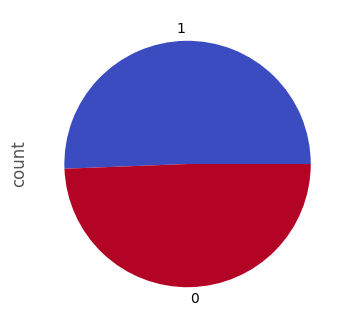

In [208]:
df[TARGET].value_counts().plot(kind="pie", figsize=(6,4), colormap="coolwarm");


Observamos que la columna **'Compra_'+producto** se trata del target, una variable booleana tipo int64 que nos indica si la el cliente ha comprado el producto o no. Cabe destacar que se trata de un target balanceado (porcentaje de prácticamente el 50%) y sin nulos por lo que en principio no deberemos de realizar ningún tipo de rebalanceo de los datos ni eliminación o imputación de filas con nulos.

Comenzamos clasificando las variables según si son categóricas, numéricas o booleanas con la ayuda de una función.

In [209]:
def obtener_lista_variables(dataset):
    lista_numericas = []
    lista_categoricas = []
    lista_booleanas = []

    for i in dataset:
        if (dataset[i].dtype.kind == 'f' or dataset[i].dtype.kind == 'i') and len(dataset[i].unique())!= 2 and (i not in TARGET):
            lista_numericas.append(i)
        if (dataset[i].dtype.kind == 'f' or dataset[i].dtype.kind == 'i') and len(dataset[i].unique()) == 2 and (i not in TARGET):
            lista_booleanas.append(i)
        if (dataset[i].dtype.kind == 'O') and (i not in TARGET):
            lista_categoricas.append(i)

    return lista_numericas,lista_categoricas,lista_booleanas

numericas,categoricas,booleanas = obtener_lista_variables(df)
print(f'Variables numéricas ({len(numericas)}): {numericas}')
print(f'Variables categóricas ({len(categoricas)}):{categoricas}')
print(f'Variables booleanas ({len(booleanas)}):{booleanas}')

Variables numéricas (18): ['age', 'salary', 'entry_date_year', 'entry_date_month', 'pk_partition_month', 'em_acount_consecutive_months', 'pension_plan_consecutive_months', 'payroll_consecutive_months', 'payroll_account_consecutive_months', 'emc_account_consecutive_months', 'credit_card_consecutive_months', 'long_term_deposit_consecutive_months', 'securities_consecutive_months', 'funds_consecutive_months', 'mortgage_consecutive_months', 'num_accounts', 'meses_antigüedad', 'days_since_last_purchase']
Variables categóricas (7):['country_id', 'region_code', 'gender', 'deceased', 'entry_channel', 'segment', 'tipo_cliente']
Variables booleanas (9):['active_customer', 'short_term_deposit_consecutive_months', 'loans_consecutive_months', 'has_account', 'has_pension_plan', 'has_investment', 'has_loan', 'has_credit_card_debt', 'num_debt_products']


### Análisis categóricas

Al mismo tiempo que identificamos nulos, outliers y datos erróneos vamos a estimar si cada variable es explicativa o no. Para ello, nos enfocaremos en el análisis de una pivot_table que nos aporta los siguientes datos estadísticos: 

- el número total de clientes en cada categoría dentro de una variable
- el número de clientes que ha comprado el producto en cada categoría 
- el porcentaje de compra asociado a cada categoría

En función del número de clientes de cada categoría y lo mucho que su porcentaje de compra se distingue de la media del target (50%), determinaremos si la variable es explicativa o no.

In [210]:
categoricas

['country_id',
 'region_code',
 'gender',
 'deceased',
 'entry_channel',
 'segment',
 'tipo_cliente']

A continuación vamos a definir las tres funciones que nos van a ayudar a analizar cada variable categórica y la relación que guarda cada una de ellas con el target.


- **explore_cat_values** --> nos indica el número de nulos de una columna categórica específica y genera una pivot_table la cual proporciona un resumen estadístico sobre dicha columna y su relación con el Target a través de 3 columnas: ['Num_clientes','Num_compras','Porcentaje_compra']


- **plot_cat_values** --> nos genera dos gráficas que nos ayudan a analizar tanto la distribución de las distintas categorías dentro de la variable como la distribución del Target dentro de cada una de esas categorías.


- **analisis_cat** --> incorpora las dos funciones anteriores y realiza un análisis exploratorio de una columna categórica específica en un dataframe, incluyendo visualización y resumen estadístico.

In [211]:
def explore_cat_values(dataframe, column, target_col):
    """
    Genera un resumen estadístico sobre una columna categórica específica del dataframe y su relación con el Target.

    Parámetros:
    dataframe (pd.DataFrame): El dataframe que contiene los datos.
    column (str): El nombre de la columna categórica a explorar.
    target_col (str): El nombre de la columna Target que se analizará en relación con la columna categórica.

    Retorna:
    pd.DataFrame: Un dataframe que contiene el resumen de la columna categórica, incluyendo:
                  - 'Num_clientes': El número de ocurrencias de cada categoría.
                  - 'Num_compras': La suma de los valores en la columna objetivo para cada categoría.
                  - 'Porcentaje_compra': El promedio de los valores en la columna objetivo para cada categoría, indicando el porcentaje de compra.
    """

    resumen_df = dataframe.pivot_table(index=column, values=target_col, aggfunc=[len,'sum','mean'],observed=False)
    resumen_df.columns = ['Num_clientes', 'Num_compras','Porcentaje_compra']
    resumen_df = resumen_df.sort_values(by='Num_clientes',ascending=False)
    return resumen_df

In [212]:
def plot_cat_values(dataframe, column, target_column):
    """
    Genera un gráfico de barras para visualizar la relación entre una variable categórica y el Target.

    Parámetros:
    dataframe (pd.DataFrame): El dataframe que contiene los datos.
    column (str): El nombre de la columna categórica a explorar.
    target_column (str): El nombre de la columna Target que se analizará en relación con la columna categórica.

    Retorna:
    None: La función muestra un gráfico de barras y no devuelve ningún valor.
    """
    plt.figure(figsize=(10,4))
    
    # Gráfico que muestra la distribución del target en cada categoría de la variable categórica
    ax1 = sns.countplot(data=dataframe, x=column, hue=target_column, order=list(dataframe[column].unique()))
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)

    plt.tight_layout()
    plt.show();

In [213]:
def analisis_cat(dataframe, column, target_column):

    """
    Realiza un análisis exploratorio de una columna categórica específica en un dataframe, incluyendo visualización y resumen estadístico.

    Parámetros:
    dataframe (pd.DataFrame): El dataframe que contiene los datos.
    column (str): El nombre de la columna categórica a explorar.
    target_column (str): El nombre de la columna Target que se analizará en relación con la columna categórica.

    Retorna:
    pd.DataFrame: Un dataframe que contiene el resumen de la columna categórica, incluyendo:
                  - 'Num_clientes': El número de ocurrencias de cada categoría.
                  - 'Num_compras': La suma de los valores en la columna objetivo para cada categoría.
                  - 'Porcentaje_compra': El promedio de los valores en la columna objetivo para cada categoría, indicando el porcentaje de compra.
    """
    
    plot_cat_values(dataframe, column, target_column)
    return explore_cat_values(dataframe, column, target_column)

#### country_id

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_3120\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


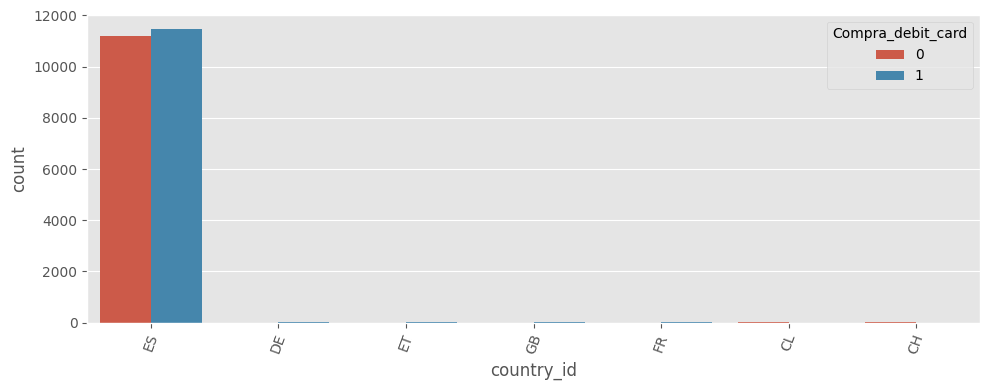

,Num_clientes,Num_compras,Porcentaje_compra
country_id,,,
ES,22644,11458,0.506006
GB,3,3,1.000000
DE,2,2,1.000000
CH,1,0,0.000000
CL,1,0,0.000000
ET,1,1,1.000000
FR,1,1,1.000000


In [214]:
analisis_cat(df, 'country_id', TARGET)

In [215]:
# la consideramos no explicativa debido a la poca varianza de la misma respecto del target, a parte su contenido está intrínseco en su
# mayoría en region_code

no_explicativas.append('country_id')

#### region_code

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_3120\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


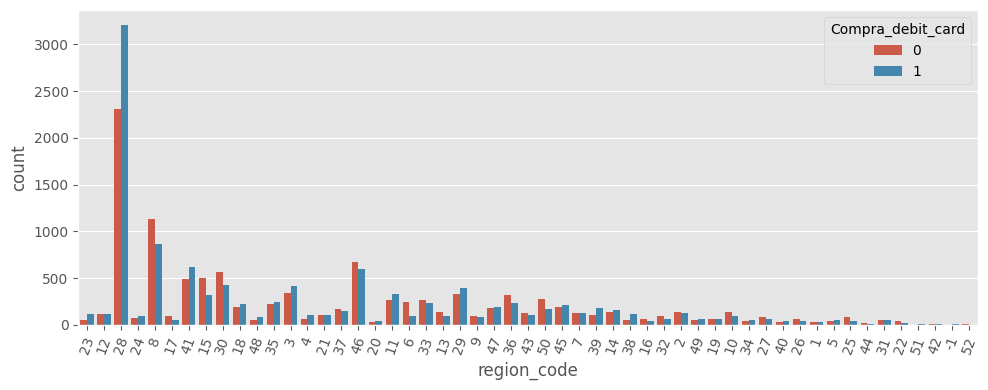

,Num_clientes,Num_compras,Porcentaje_compra
region_code,,,
28,5519,3208,0.581265
8,1992,862,0.432731
46,1279,602,0.470680
41,1113,617,0.554358
30,987,424,0.429585
15,823,316,0.383961
3,757,419,0.553501
29,733,398,0.542974
11,598,334,0.558528


In [216]:
analisis_cat(df, 'region_code', TARGET)

Debido al gran número de categorías vamos a realizar lo que se conoce como un target_encoding. Esto consiste en reemplazar los valores categóricos de la variable por un valor numérico, en este caso, el porcentaje de compra asociado a cada región. Esto mantiene la relación directa entre la región y el target sin aumentar mucho la dimensionalidad del modelo (no hay necesidad de aplicar OHE a la variable)

In [217]:
# Cálculo de la tasa de compra por región
region_target_mean = df.groupby('region_code')[TARGET].mean()

# Reemplaza la variable de región con la tasa media de compra por región
df['region_encoded'] = df['region_code'].map(region_target_mean)

# añadimos la variable original a la lista de variables no explicativas
no_explicativas.append('region_code')

#### gender

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_3120\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


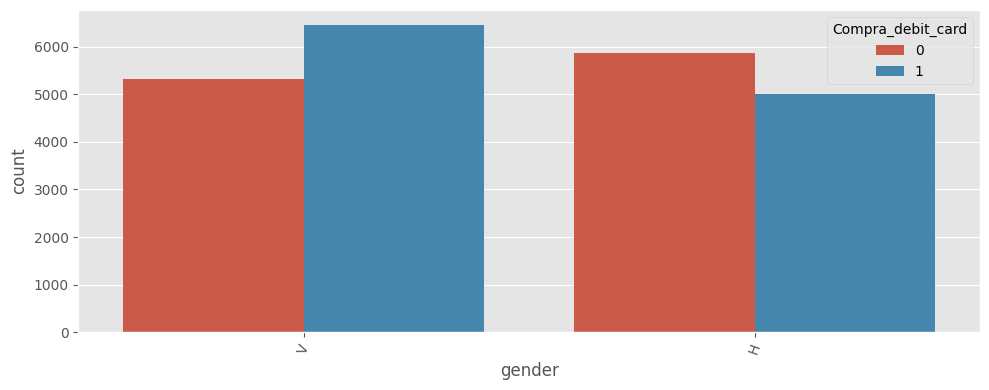

,Num_clientes,Num_compras,Porcentaje_compra
gender,,,
V,11773,6451,0.547949
H,10880,5014,0.460846


In [218]:
analisis_cat(df, 'gender', TARGET)

#### deceased

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_3120\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


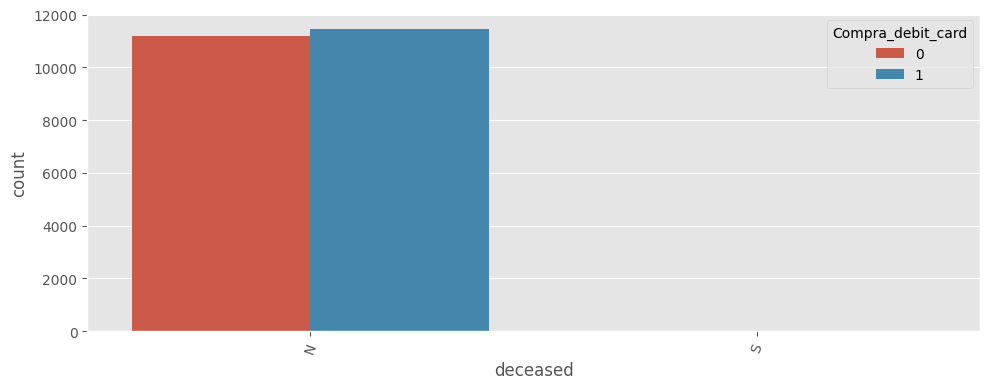

,Num_clientes,Num_compras,Porcentaje_compra
deceased,,,
N,22651,11465,0.506159
S,2,0,0.000000


In [219]:
analisis_cat(df, 'deceased', TARGET)

In [220]:
# tenemos solo dos fallecidos por lo que la consideramos variable no explicativa

no_explicativas.append('deceased')

#### segment

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_3120\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


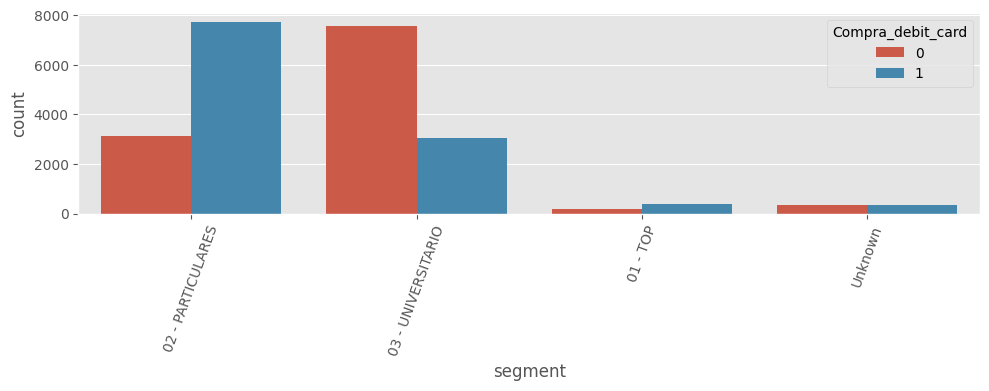

,Num_clientes,Num_compras,Porcentaje_compra
segment,,,
02 - PARTICULARES,10832,7717,0.712426
03 - UNIVERSITARIO,10590,3029,0.286025
Unknown,677,340,0.502216
01 - TOP,554,379,0.684116


In [221]:
analisis_cat(df, 'segment', TARGET)

In [222]:
# ponemos la variable más bonita

df['segment'] = np.where(df['segment']=='03 - UNIVERSITARIO','Universitario',df['segment'])
df['segment'] = np.where(df['segment']=='02 - PARTICULARES','Particulares',df['segment'])
df['segment'] = np.where(df['segment']=='01 - TOP','Top',df['segment'])

df['segment'].value_counts()

segment
Particulares     10832
Universitario    10590
Unknown            677
Top                554
Name: count, dtype: int64

#### entry_channel

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_3120\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


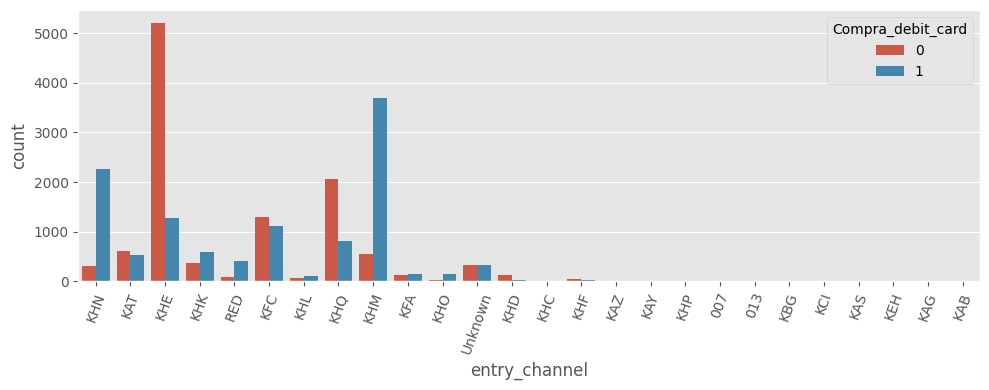

,Num_clientes,Num_compras,Porcentaje_compra
entry_channel,,,
KHE,6485,1274,0.196453
KHM,4241,3696,0.871493
KHQ,2855,802,0.280911
KHN,2557,2259,0.883457
KFC,2409,1118,0.464093
KAT,1147,536,0.467306
KHK,950,591,0.622105
Unknown,669,336,0.502242
RED,503,414,0.823062


In [223]:
analisis_cat(df, 'entry_channel', TARGET)

In [224]:
# agrupamos aquellos canales con menos de 200 clientes bajo el nombre de Others

def setOthers(dataframe, column, min_count):
    """
    Esta función toma una columna categórica en un DataFrame y reemplaza aquellas categorías cuya frecuencia es 
    menor que un umbral especificado (`min_count`) con la categoría 'Others'. Luego, la columna se convierte en 
    un tipo categórico con las categorías filtradas y 'Others'. Finalmente, las categorías no especificadas 
    explícitamente son reemplazadas por 'Others'.

    Parámetros:
    df (pd.DataFrame): El DataFrame que contiene la columna a transformar.
    columna (str): El nombre de la columna en el DataFrame que queremos transformar.
    min_count (int): El umbral de frecuencia mínima, es decir, el número mínimo de máquinas que una categoría debe tener para no ser agrupada en 'Others'.
    
    Retorna:
    pd.Series: Una Serie con la columna transformada, donde las categorías con frecuencia menor que `min_count` se han agrupado bajo 'Others'.
    """
    # Obtener el recuento de valores de la columna
    value_counts = dataframe[column].value_counts()
    # Filtrar las categorías que superan el umbral (min_count)
    top_categories = value_counts[value_counts >= min_count].index.to_list()
    # Añadir la categoría 'Others' al listado
    top_categories.append('Others')
    dataframe[column] = pd.Categorical(dataframe[column], categories=top_categories)
    # asignar a los nulos (categorías que no se encuentran en el top_categories) la categoría Others
    dataframe[column] = dataframe[column].fillna('Others')
    return dataframe[column]

setOthers(df, 'entry_channel', 200)
explore_cat_values(df,'entry_channel',TARGET)

,Num_clientes,Num_compras,Porcentaje_compra
entry_channel,,,
KHE,6485,1274,0.196453
KHM,4241,3696,0.871493
KHQ,2855,802,0.280911
KHN,2557,2259,0.883457
KFC,2409,1118,0.464093
KAT,1147,536,0.467306
KHK,950,591,0.622105
Unknown,669,336,0.502242
Others,576,295,0.512153


#### tipo_cliente

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_3120\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


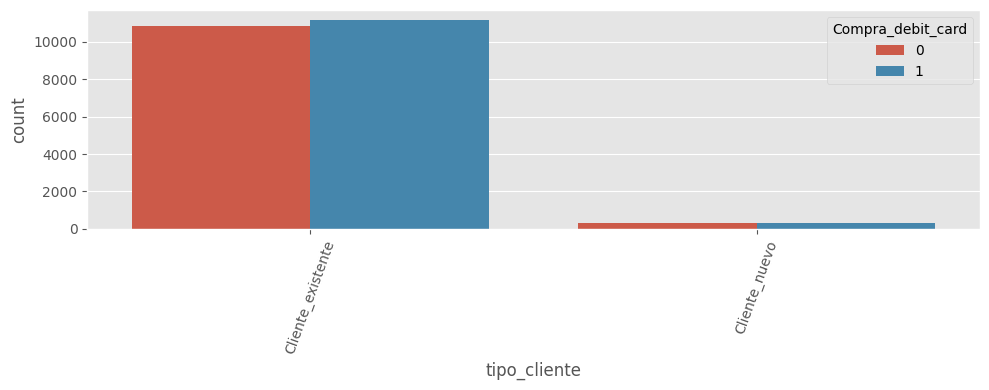

,Num_clientes,Num_compras,Porcentaje_compra
tipo_cliente,,,
Cliente_existente,22003,11142,0.506385
Cliente_nuevo,650,323,0.496923


In [225]:
analisis_cat(df, 'tipo_cliente', TARGET)

In [226]:
no_explicativas.append('tipo_cliente')

### Análisis numéricas

In [227]:
numericas

['age',
 'salary',
 'entry_date_year',
 'entry_date_month',
 'pk_partition_month',
 'em_acount_consecutive_months',
 'pension_plan_consecutive_months',
 'payroll_consecutive_months',
 'payroll_account_consecutive_months',
 'emc_account_consecutive_months',
 'credit_card_consecutive_months',
 'long_term_deposit_consecutive_months',
 'securities_consecutive_months',
 'funds_consecutive_months',
 'mortgage_consecutive_months',
 'num_accounts',
 'meses_antigüedad',
 'days_since_last_purchase']

Creamos una fución que nos permite plotear un histograma, un boxplot y un violinplot que nos ayudaran a obtener información útil sobre la distribución de las variables numéricas y su relación con el target. El boxplot indica la distribución de la variable numérica y el violinplot nos muestra la distribución de dicha variable en relación con el target.

In [228]:
def plot_num(dataframe, column, target_column):
    """
    Genera tres gráficos para visualizar la distribución de una variable numérica y su relación con una variable objetivo.

    Parámetros:
    dataframe (pd.DataFrame): El dataframe que contiene los datos.
    column (str): El nombre de la columna numérica a explorar.
    target_column (str): El nombre de la columna objetivo que se analizará en relación con la columna numérica.

    Retorna:
    None: La función muestra tres gráficos y no devuelve ningún valor.

    Descripción:
    La función genera una figura con tres subplots:
    - El primer subplot muestra un histograma de la distribución de la variable numérica.
    - El segundo subplot muestra un diagrama de cajas (boxplot) de la variable numérica.
    - El tercer subplot muestra un diagrama de violines (violinplot) de la variable objetivo en relación con la variable numérica.
    """
    plt.figure(figsize=(22,9))
    
    # Primer gráfico: Histograma de la distribución de la variable numérica
    ax1 = plt.subplot(3,1,1)
    sns.histplot(data=dataframe, x=column, bins=30, ax=ax1)
    ax1.set_xlabel('')
    
    # Segundo gráfico: Boxplot de la variable numérica
    ax2 = plt.subplot(3,1,2)
    sns.boxplot(data=dataframe, x=column, ax=ax2)
    ax2.set_xlabel('')
    
    # Tercer gráfico: Boxplot de la variable objetivo en relación con la variable numérica
    ax3 = plt.subplot(3,1,3)
    sns.violinplot(data=dataframe, x=target_column, y=column, ax=ax3)
    
    plt.tight_layout()
    plt.show()

#### age

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


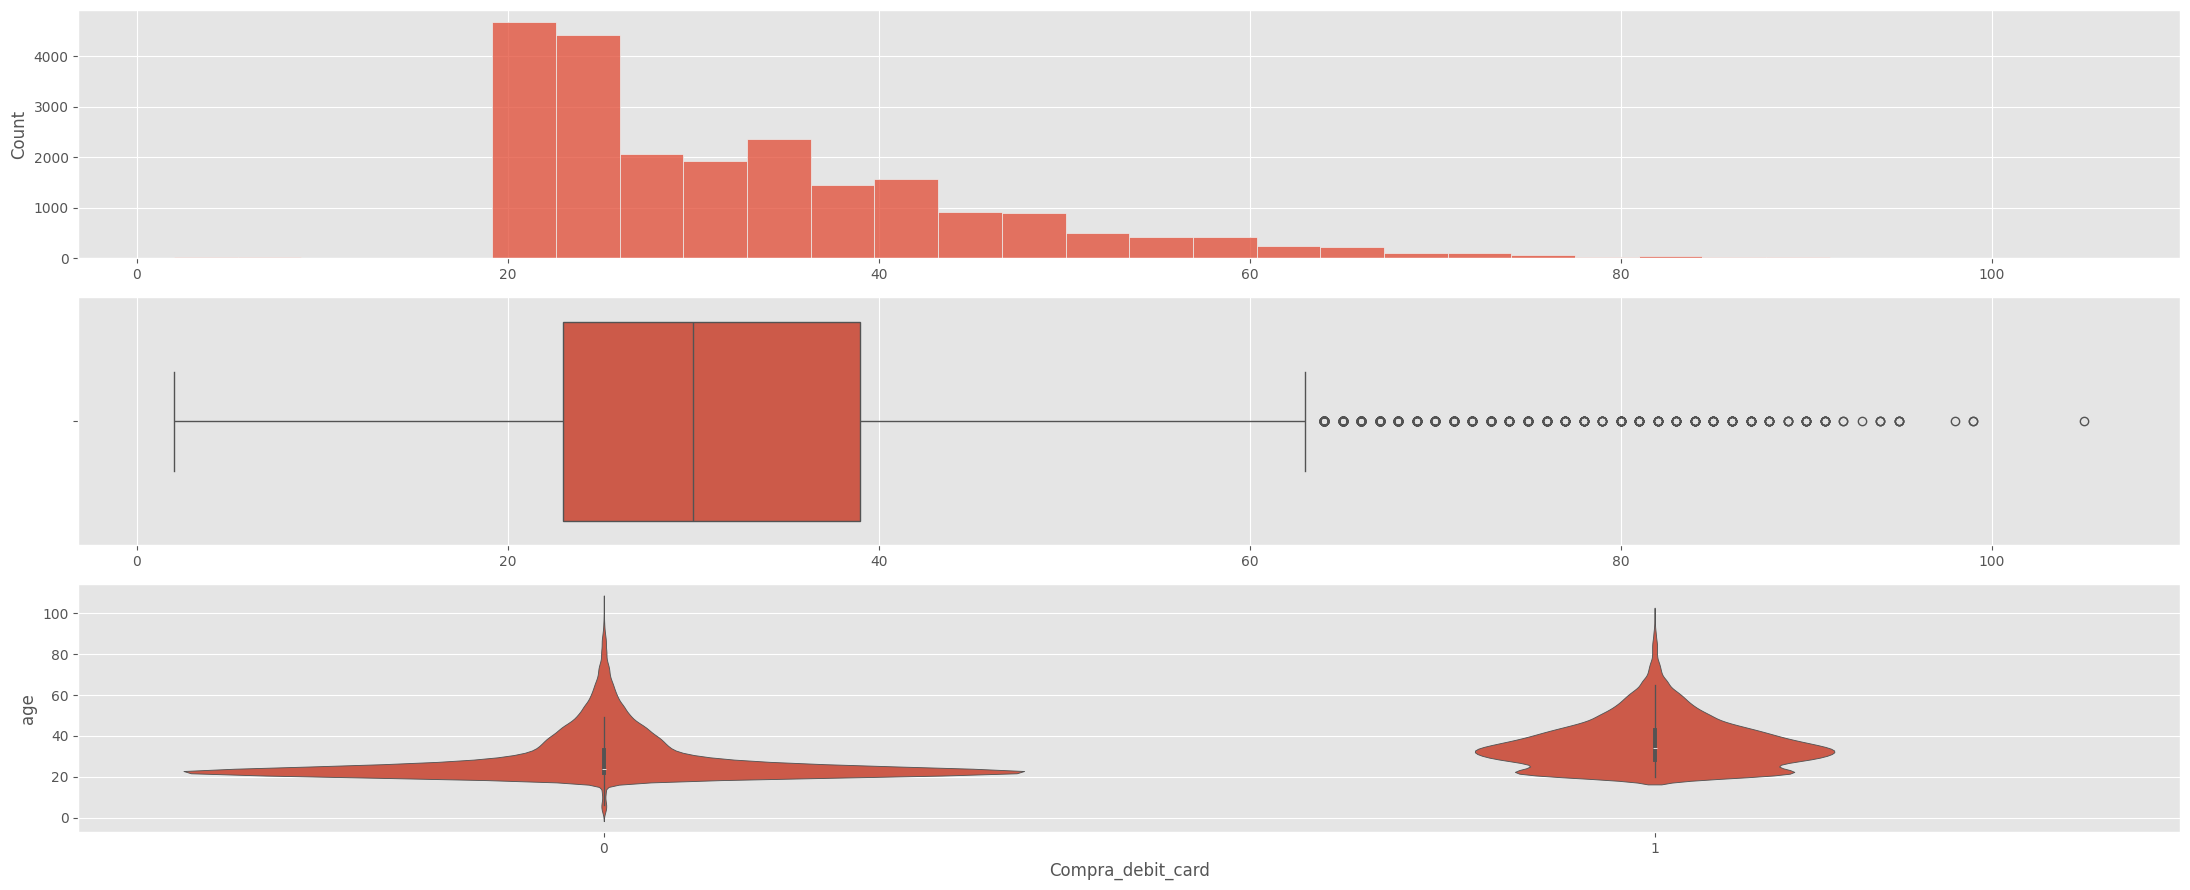

In [229]:
plot_num(df, 'age', TARGET)

#### salary

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


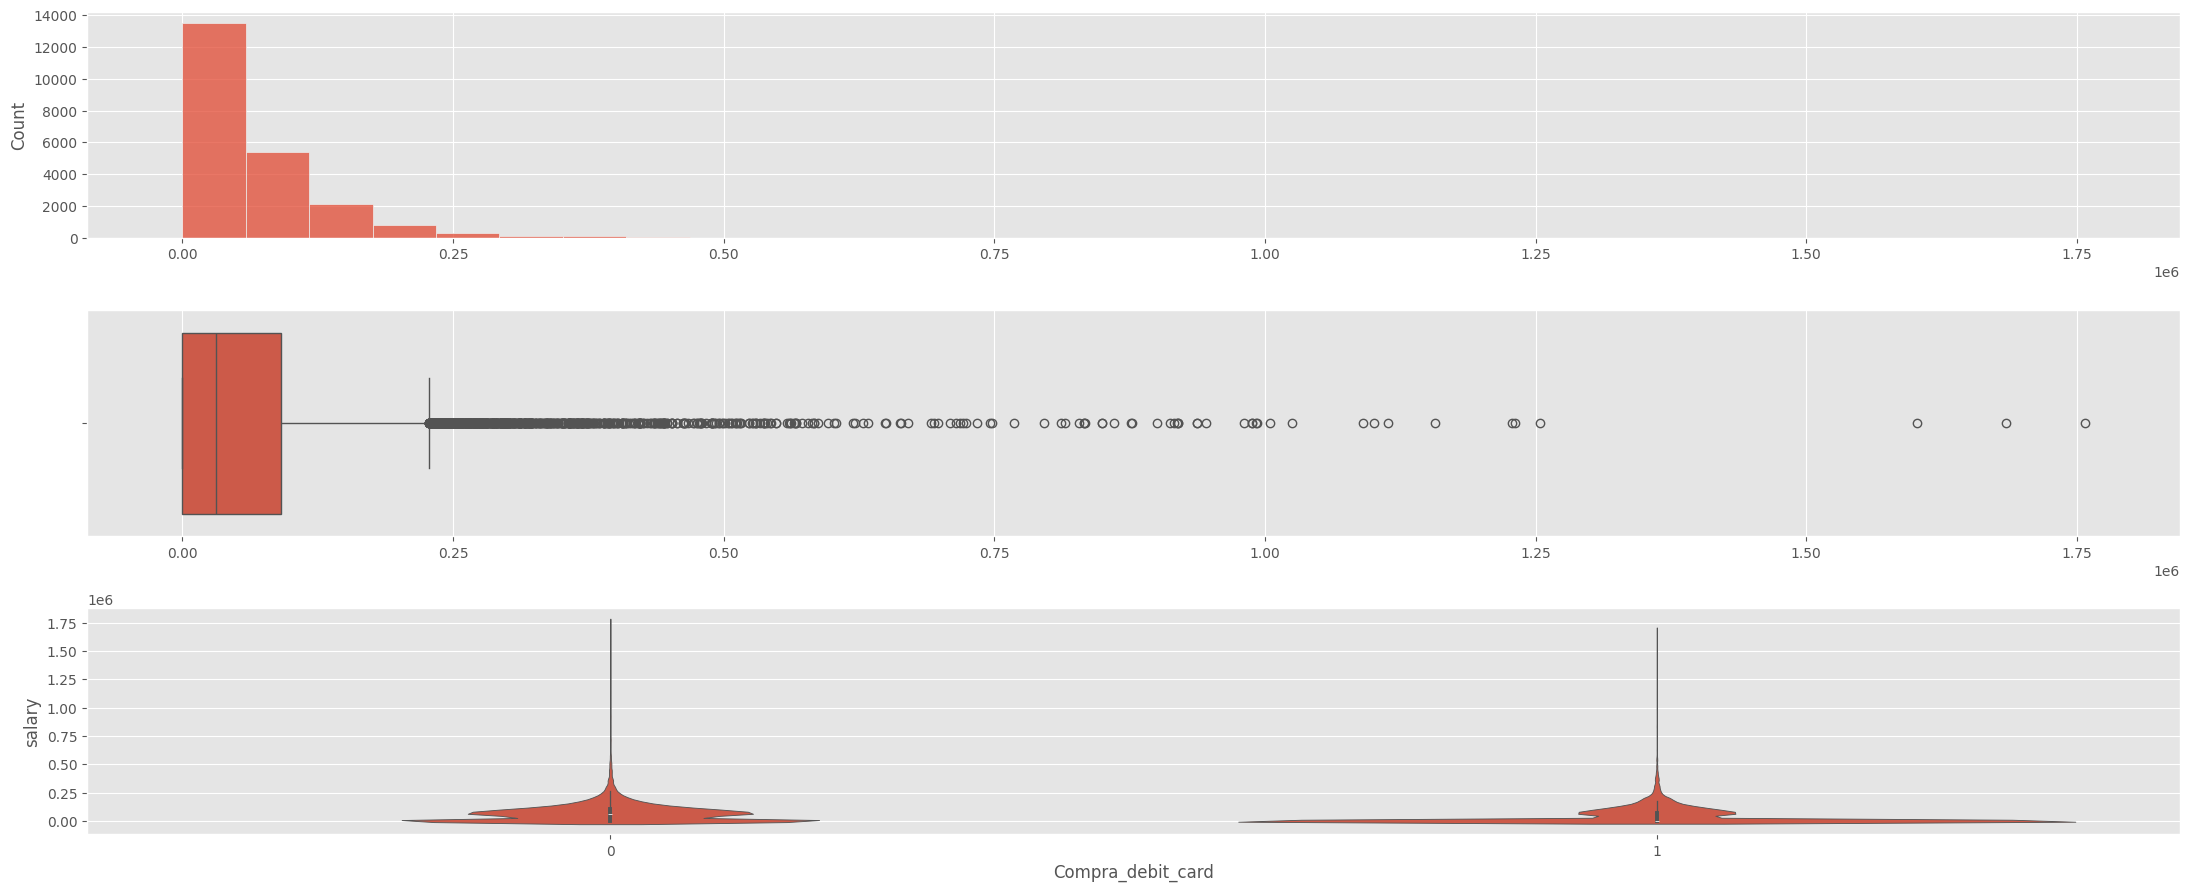

In [230]:
plot_num(df[df['salary']<2e6], 'salary', TARGET)

#### entry_date_year

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


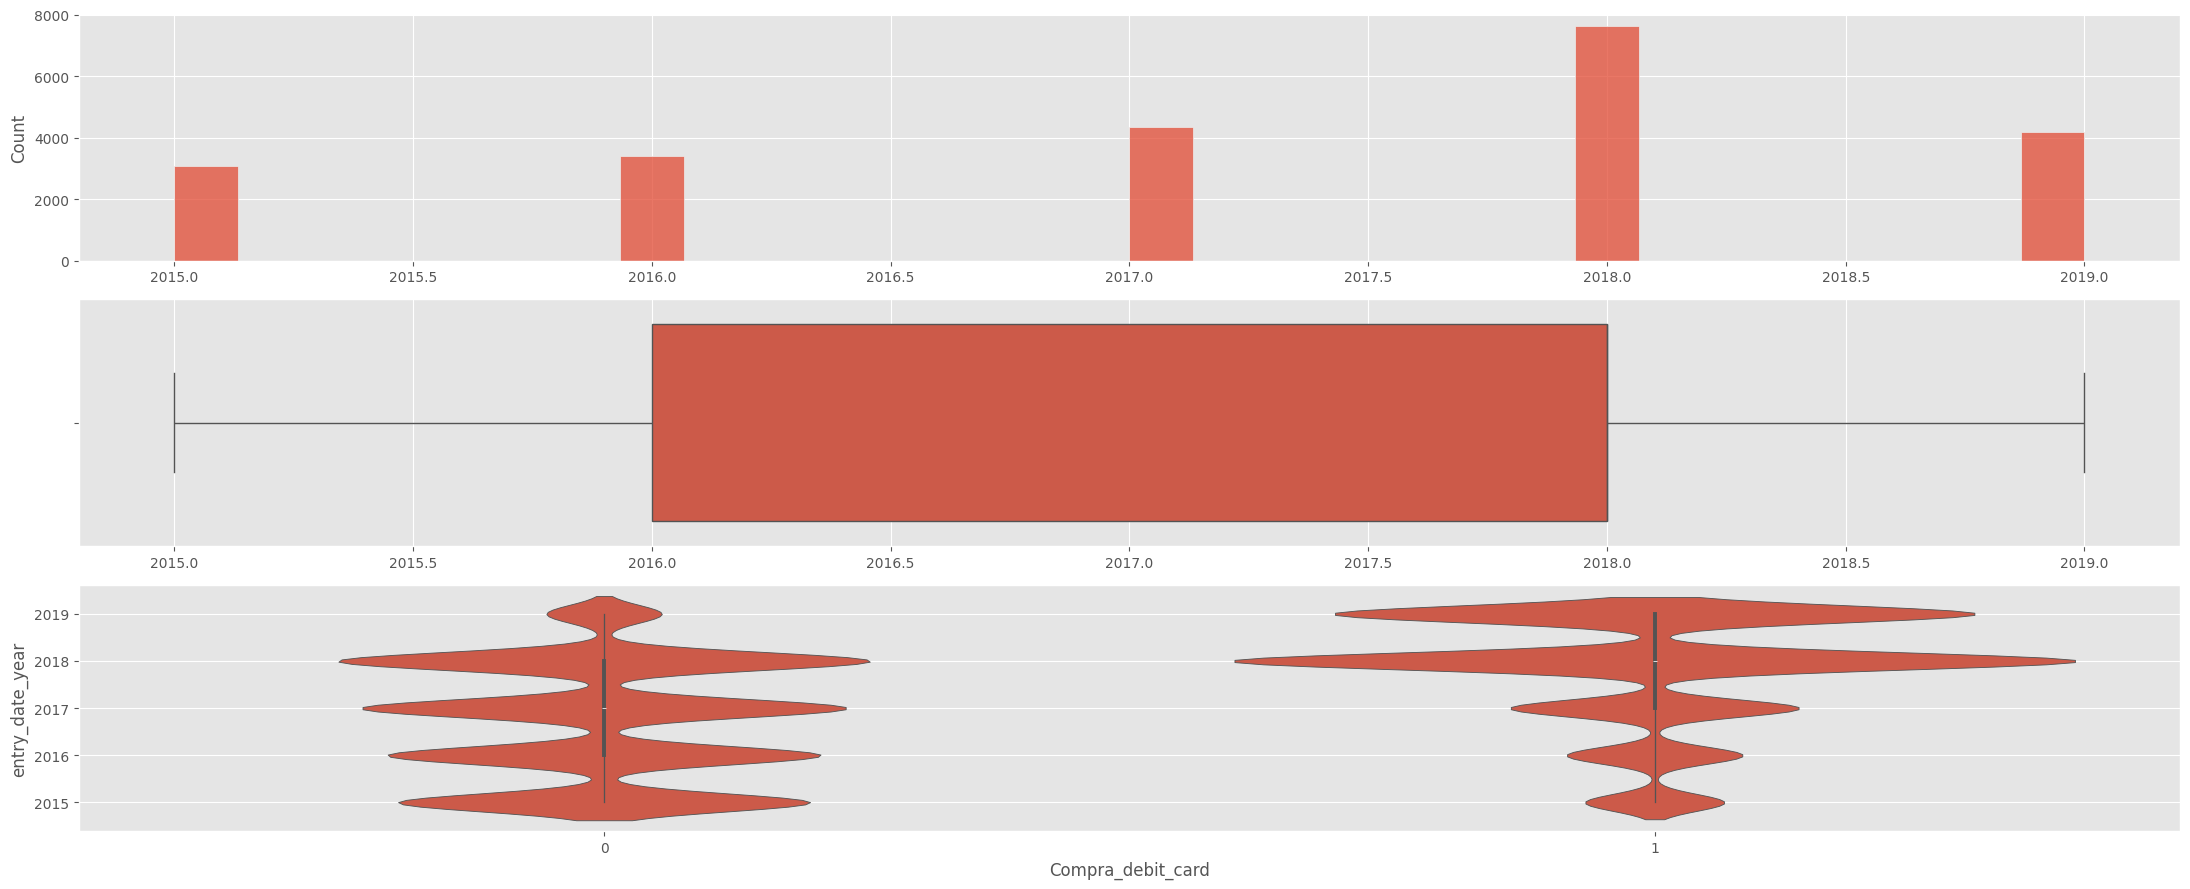

In [231]:
plot_num(df, 'entry_date_year', TARGET)

#### entry_date_month

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


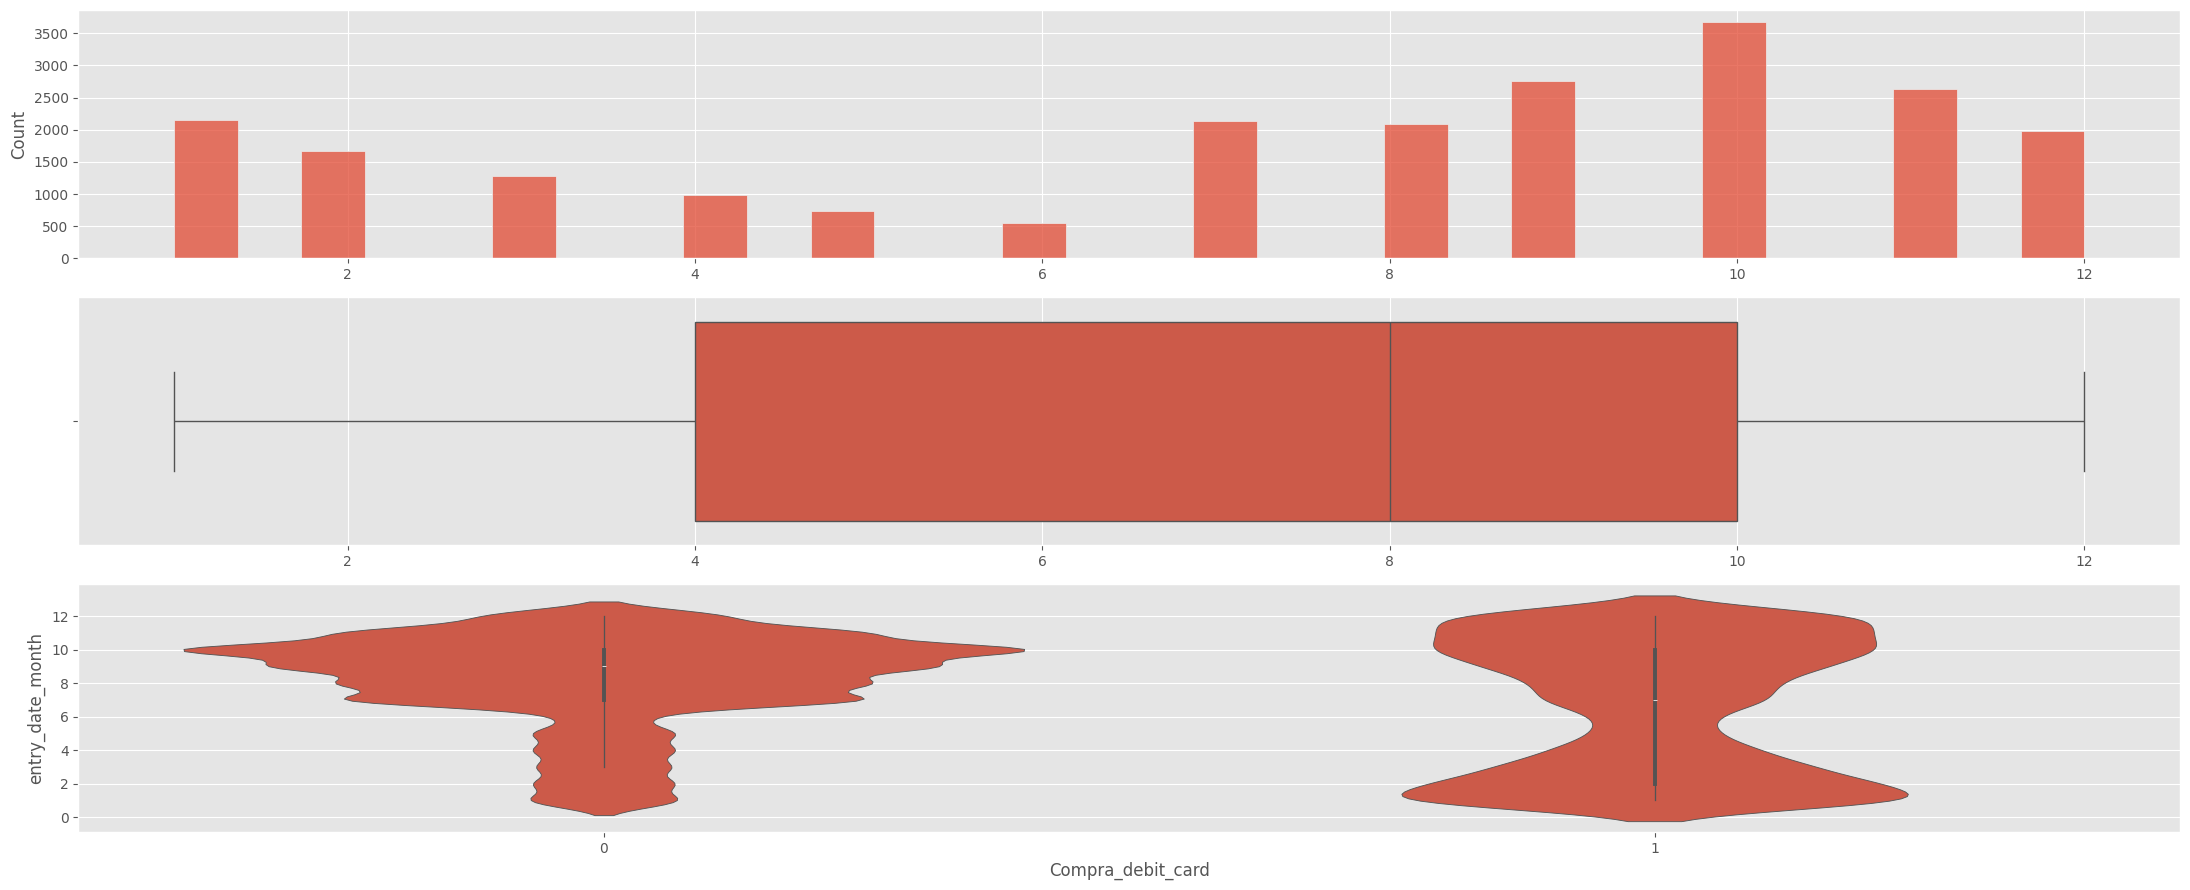

In [232]:
plot_num(df, 'entry_date_month', TARGET)

#### pk_partition_month

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


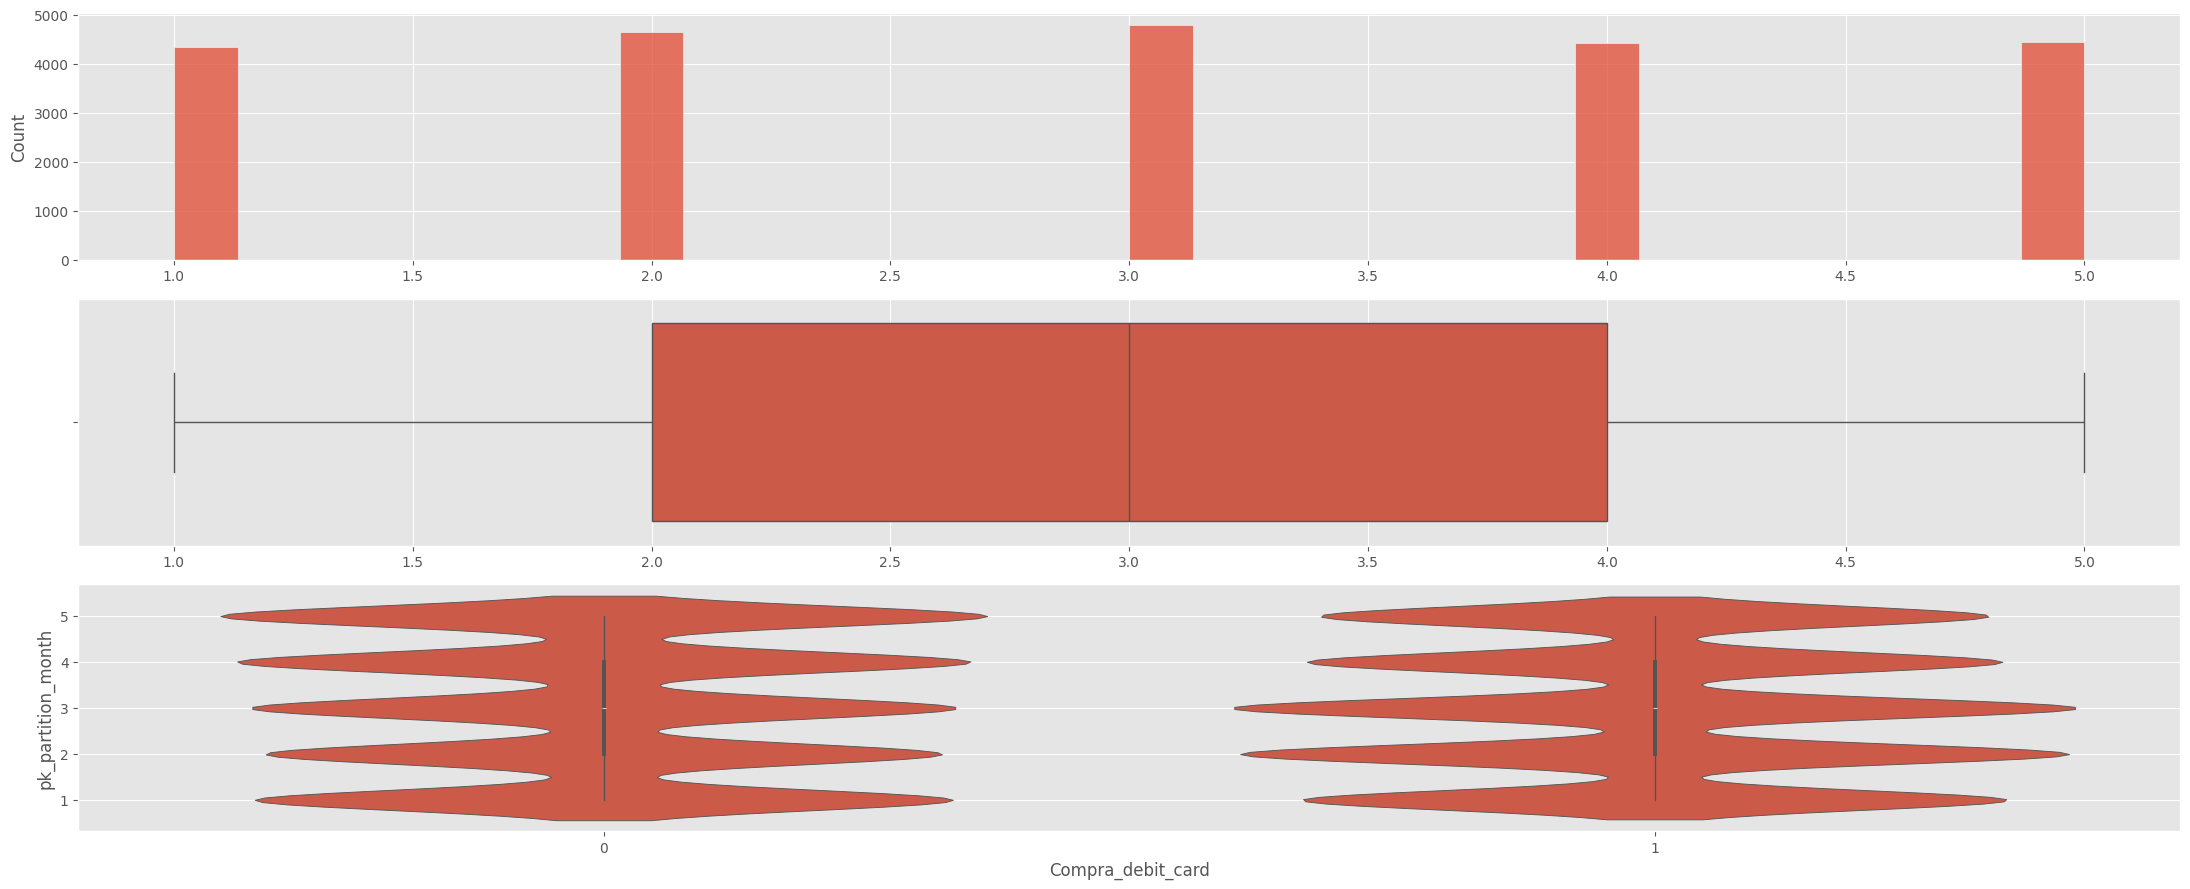

In [233]:
plot_num(df, 'pk_partition_month', TARGET)

In [234]:
# vemos que los violinplots no se diferencian mucho lo que indica que el mes no influye mucho en el TARGET

no_explicativas.append('pk_partition_month')

#### em_acount_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


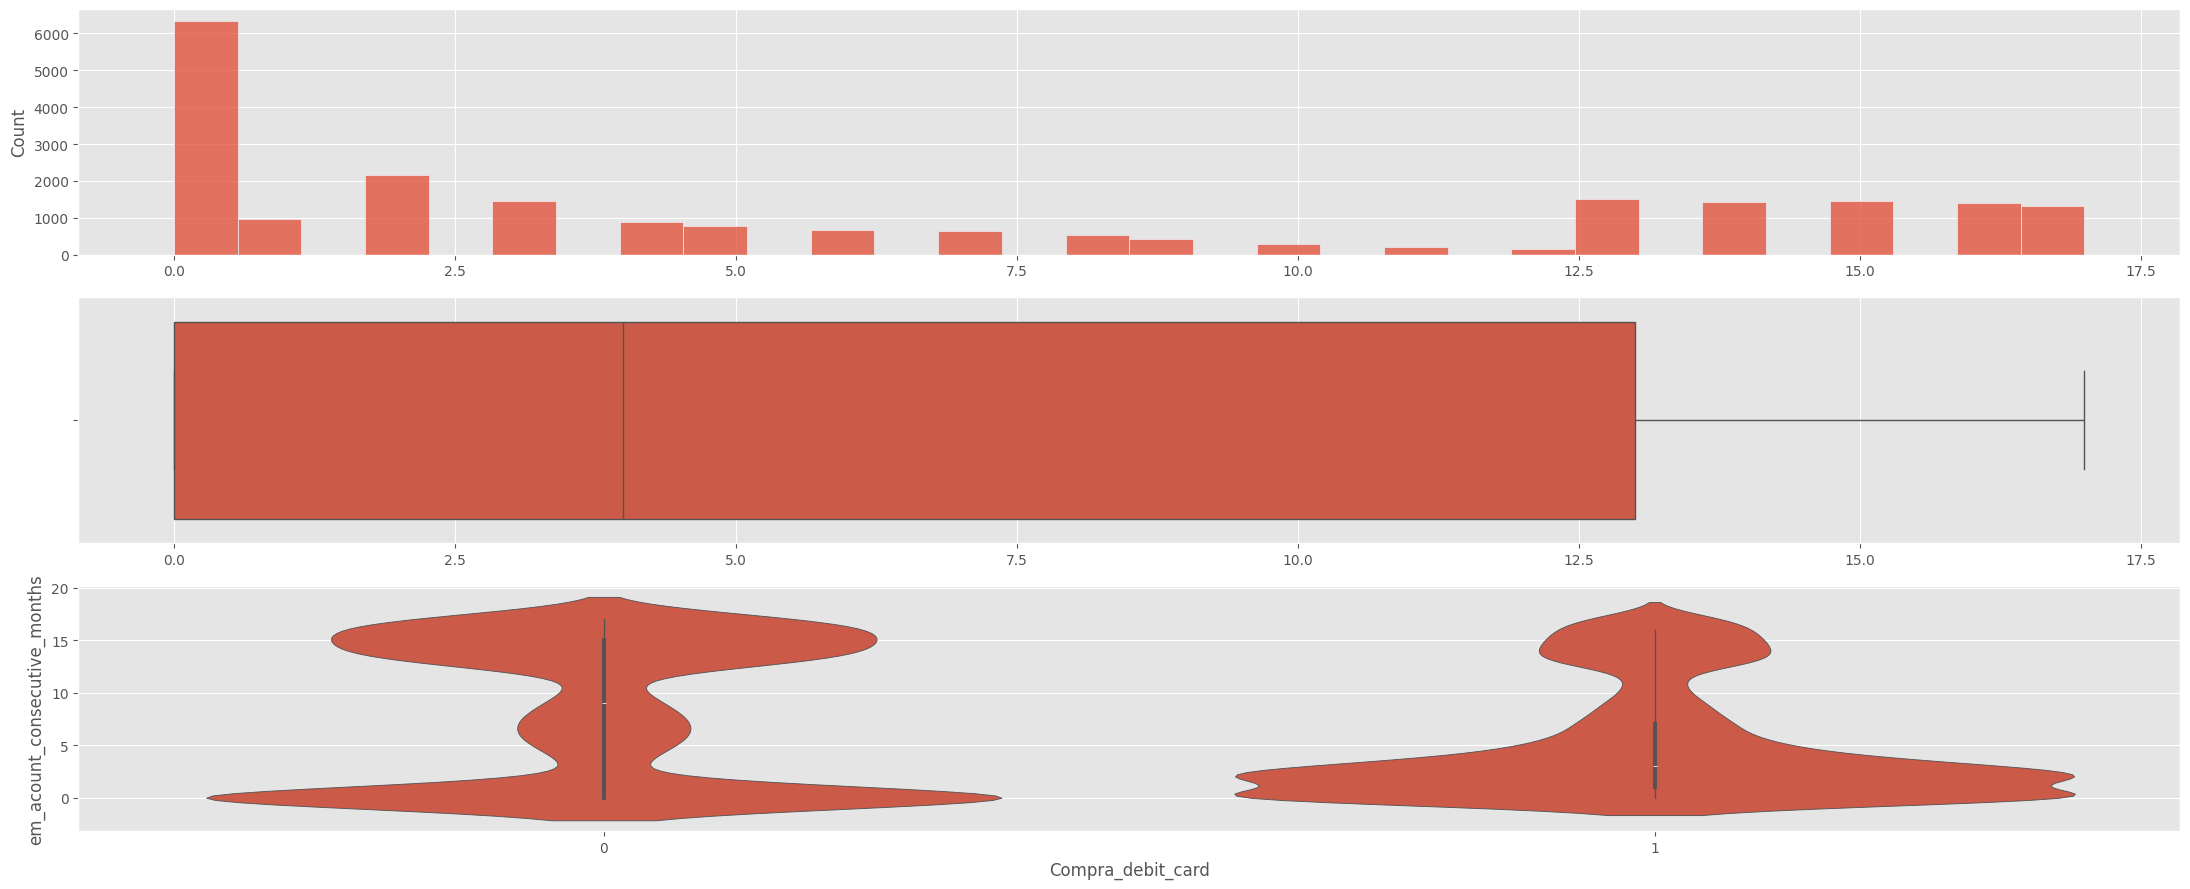

In [235]:
plot_num(df, 'em_acount_consecutive_months', TARGET)

#### pension_plan_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


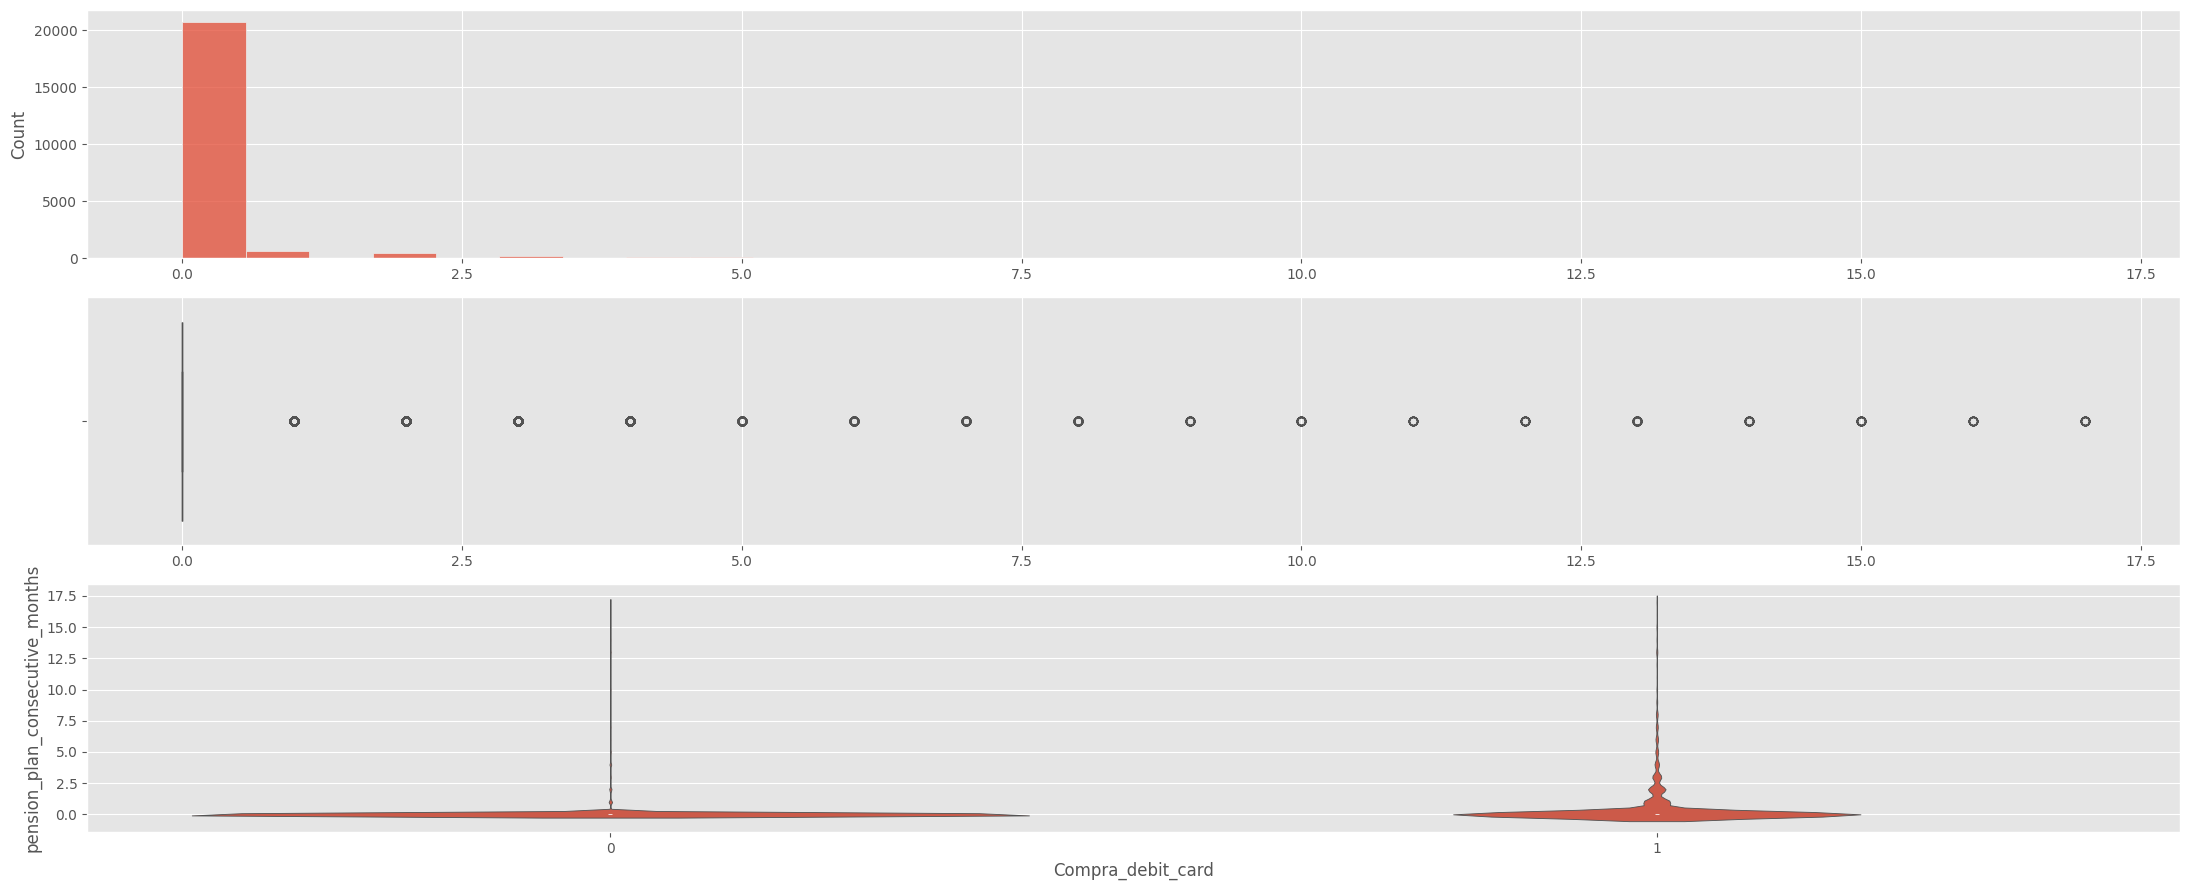

In [236]:
plot_num(df, 'pension_plan_consecutive_months', TARGET)

In [237]:
df['pension_plan_consecutive_months'].value_counts()

pension_plan_consecutive_months
0     20751
1       678
2       447
3       230
4       127
5        80
6        67
7        55
8        47
13       36
9        24
10       23
14       20
15       19
17       15
12       14
11       10
16       10
Name: count, dtype: int64

#### payroll_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


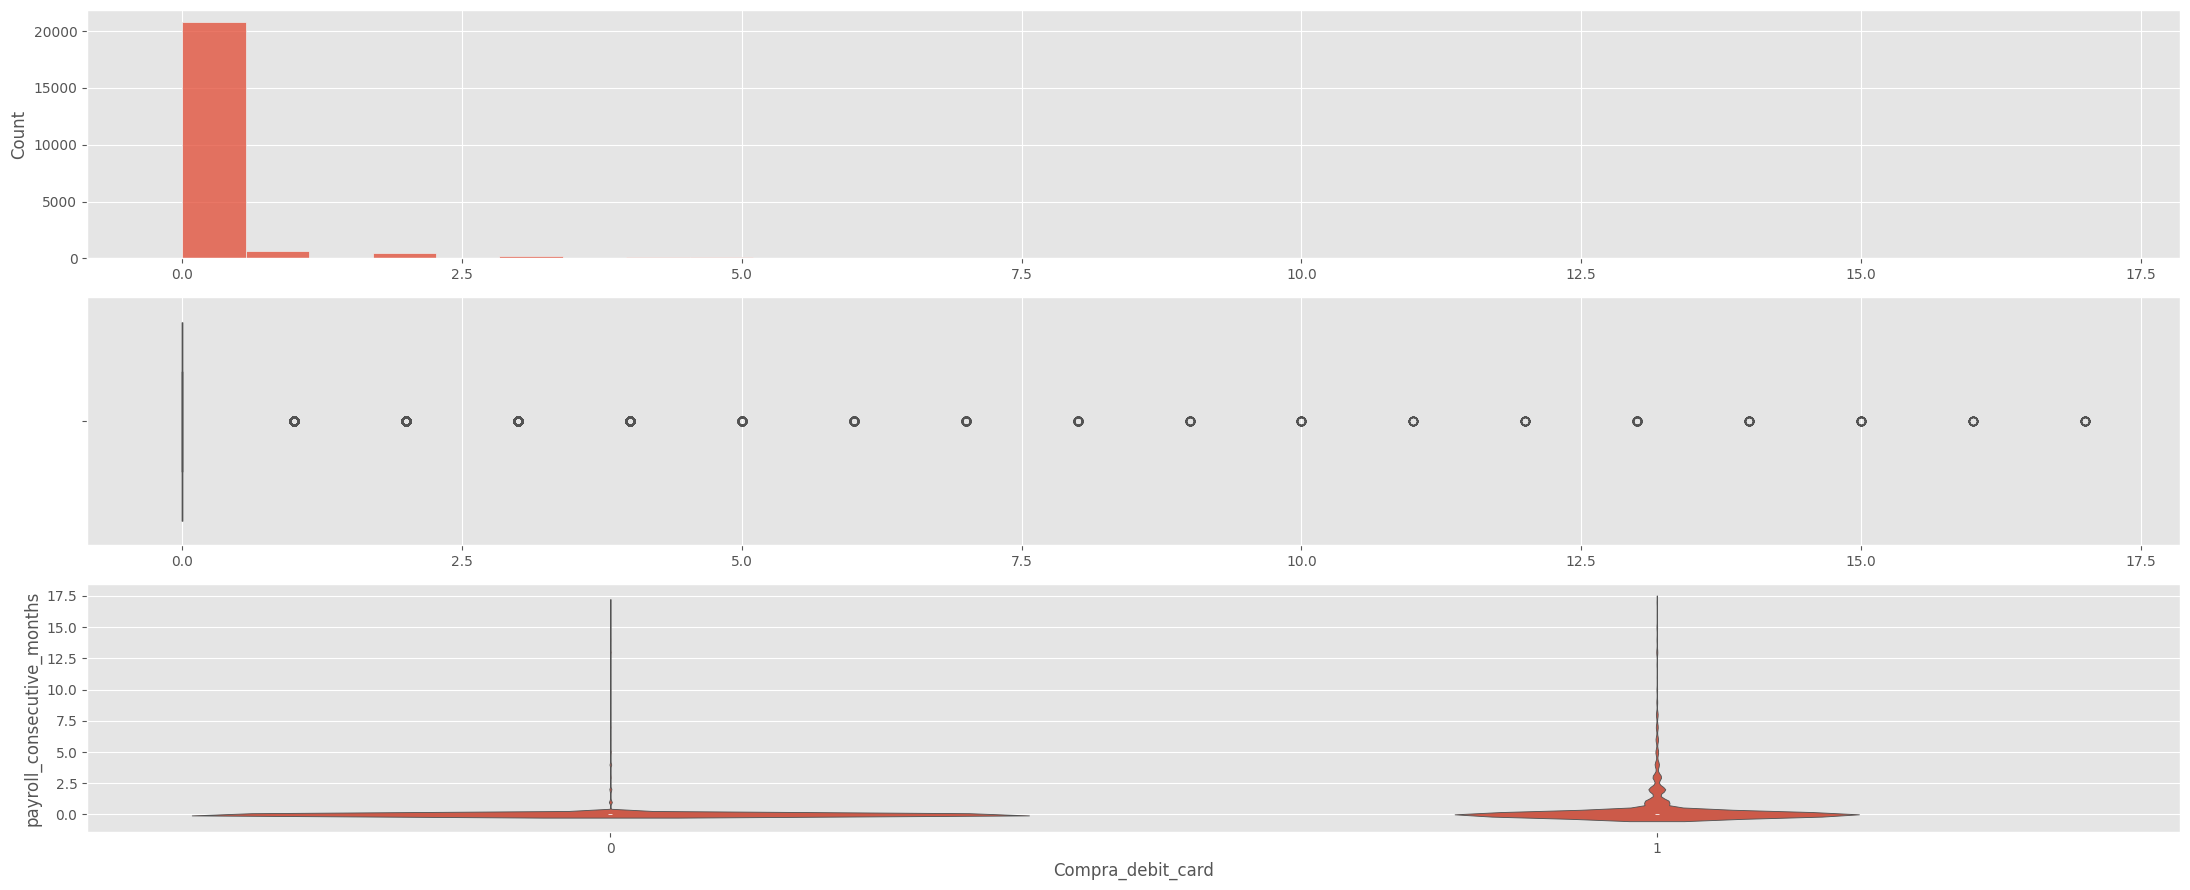

In [238]:
plot_num(df, 'payroll_consecutive_months', TARGET)

#### payroll_account_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


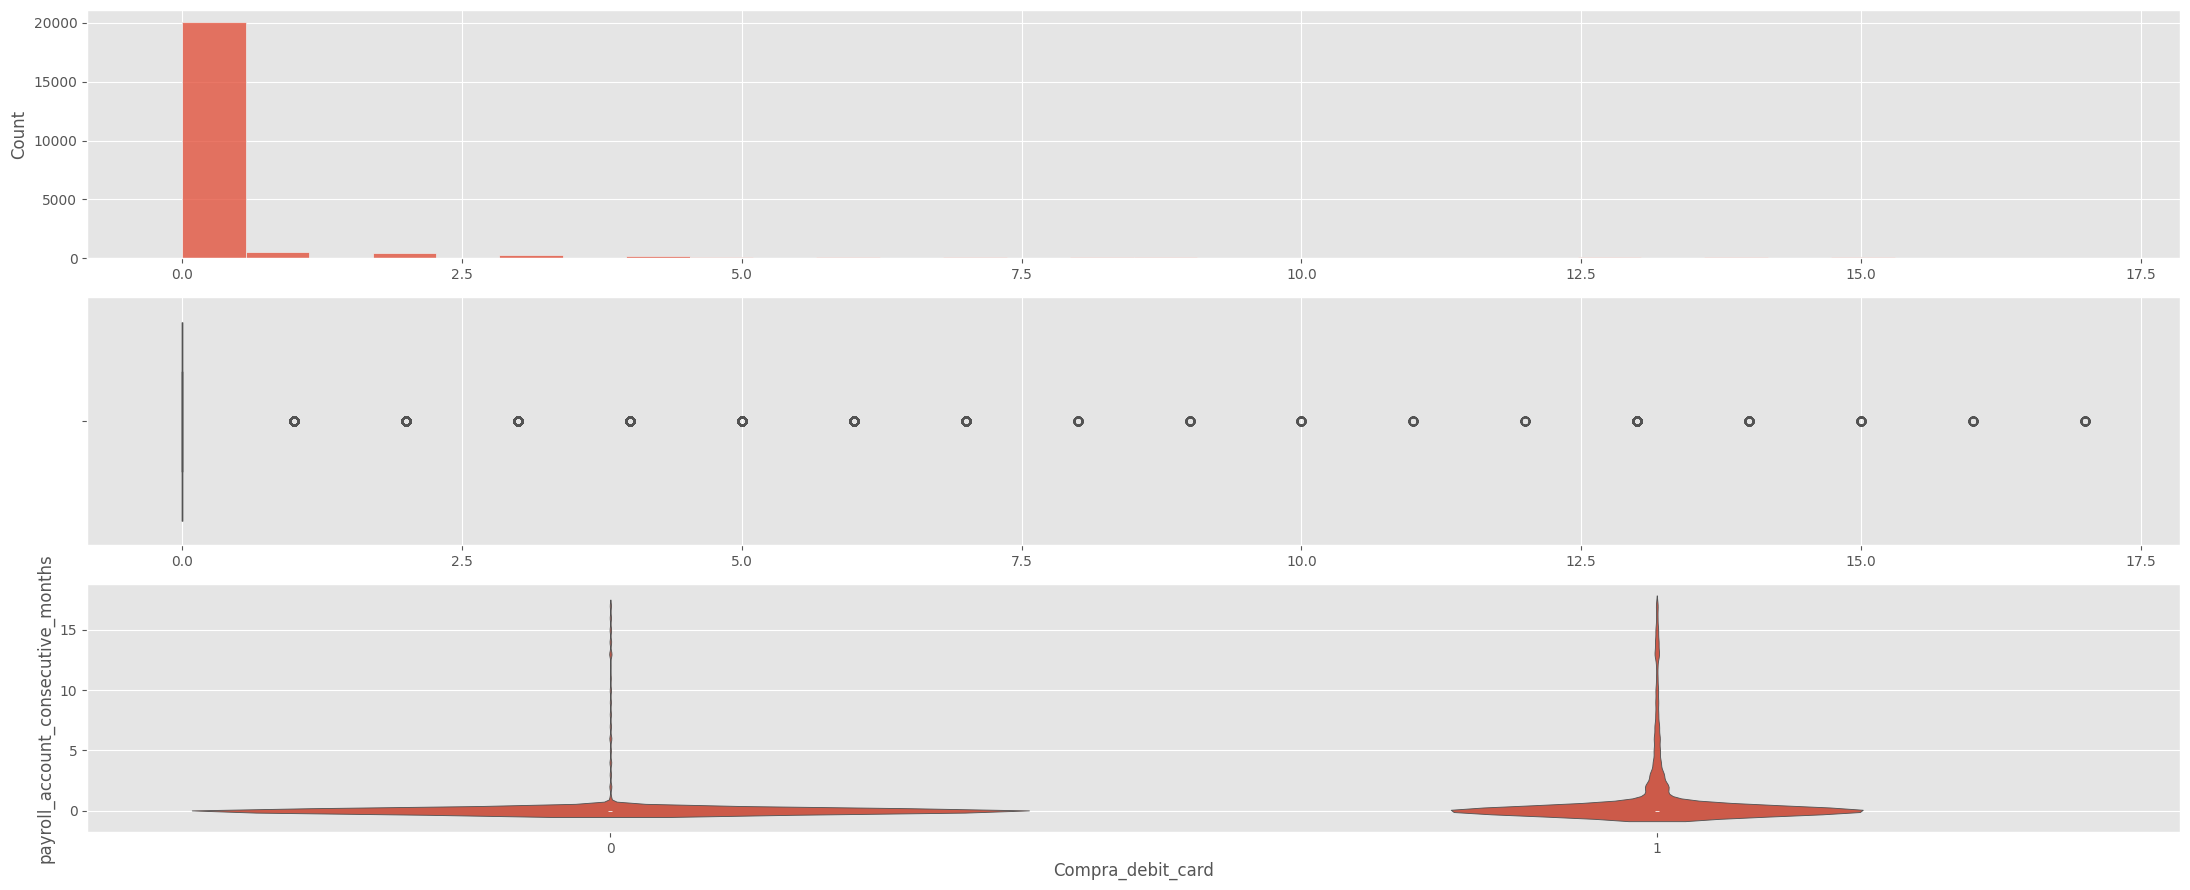

In [239]:
plot_num(df, 'payroll_account_consecutive_months', TARGET)

#### emc_account_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


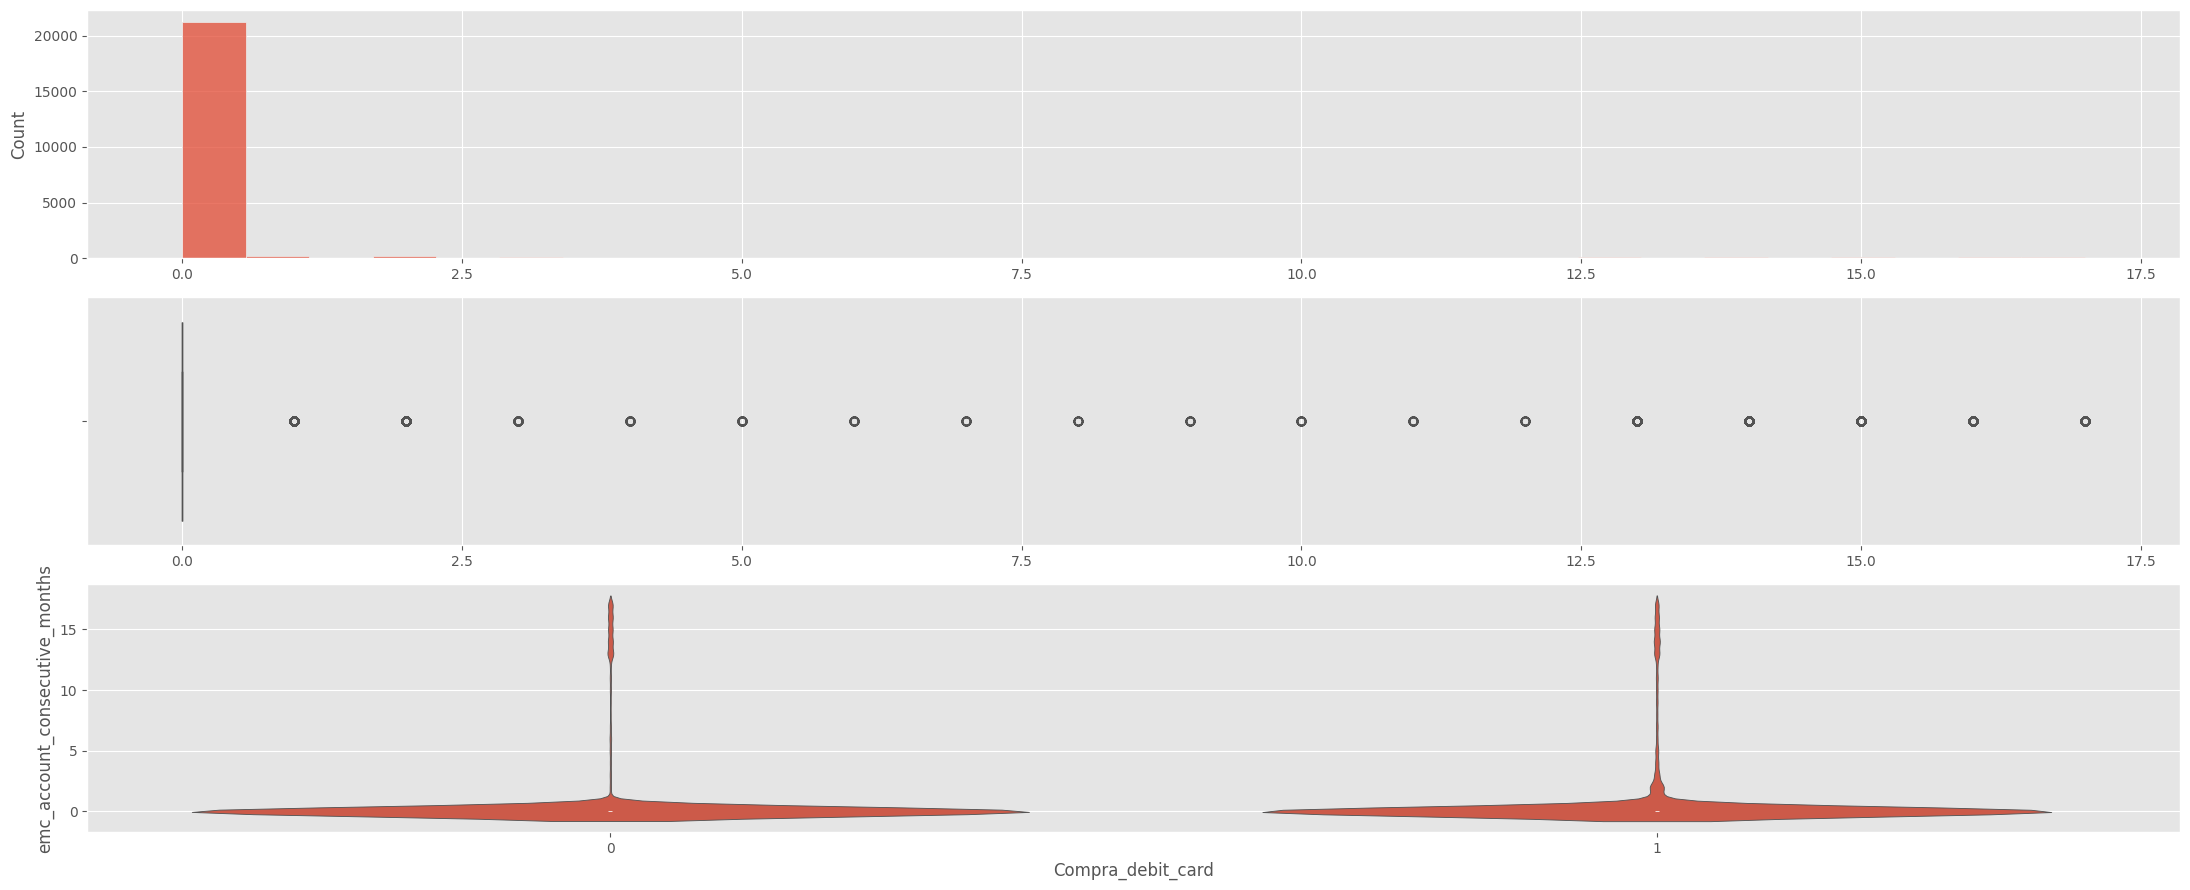

In [240]:
plot_num(df, 'emc_account_consecutive_months', TARGET)

#### credit_card_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


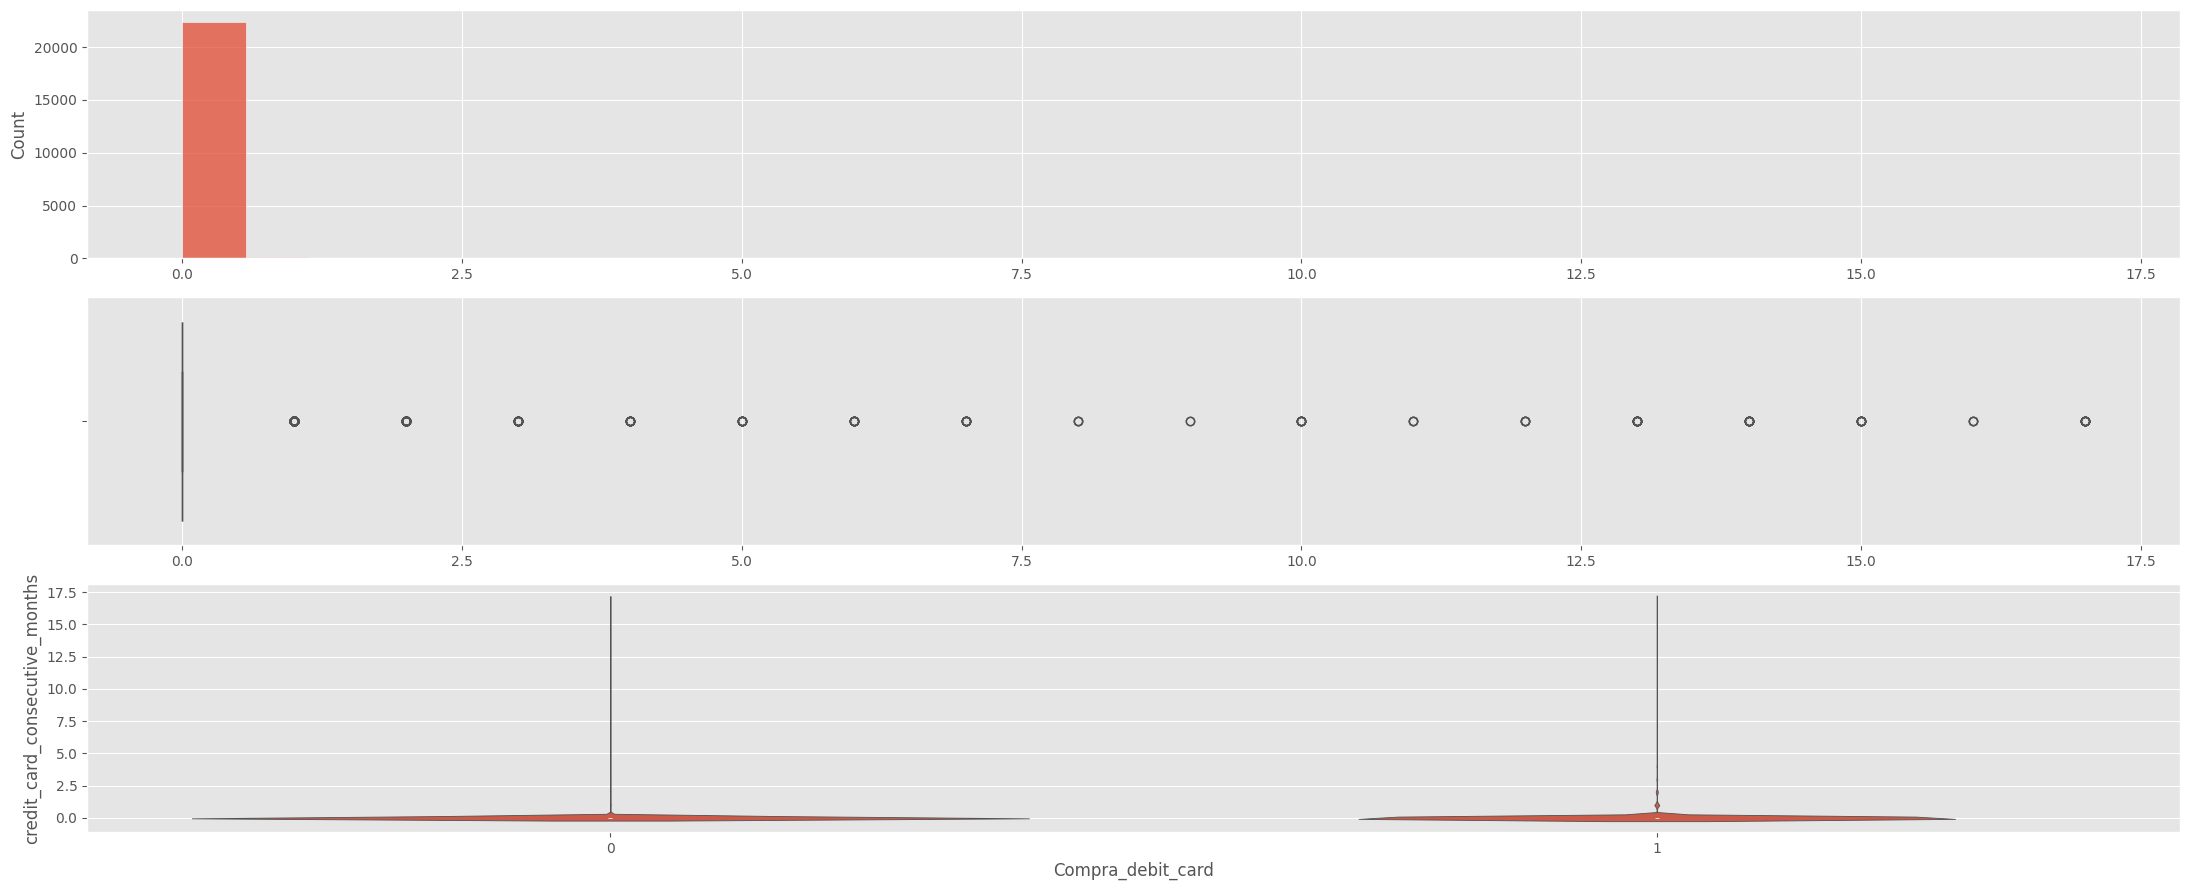

In [241]:
plot_num(df, 'credit_card_consecutive_months', TARGET)

In [242]:
no_explicativas.append('credit_card_consecutive_months')

#### long_term_deposit_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


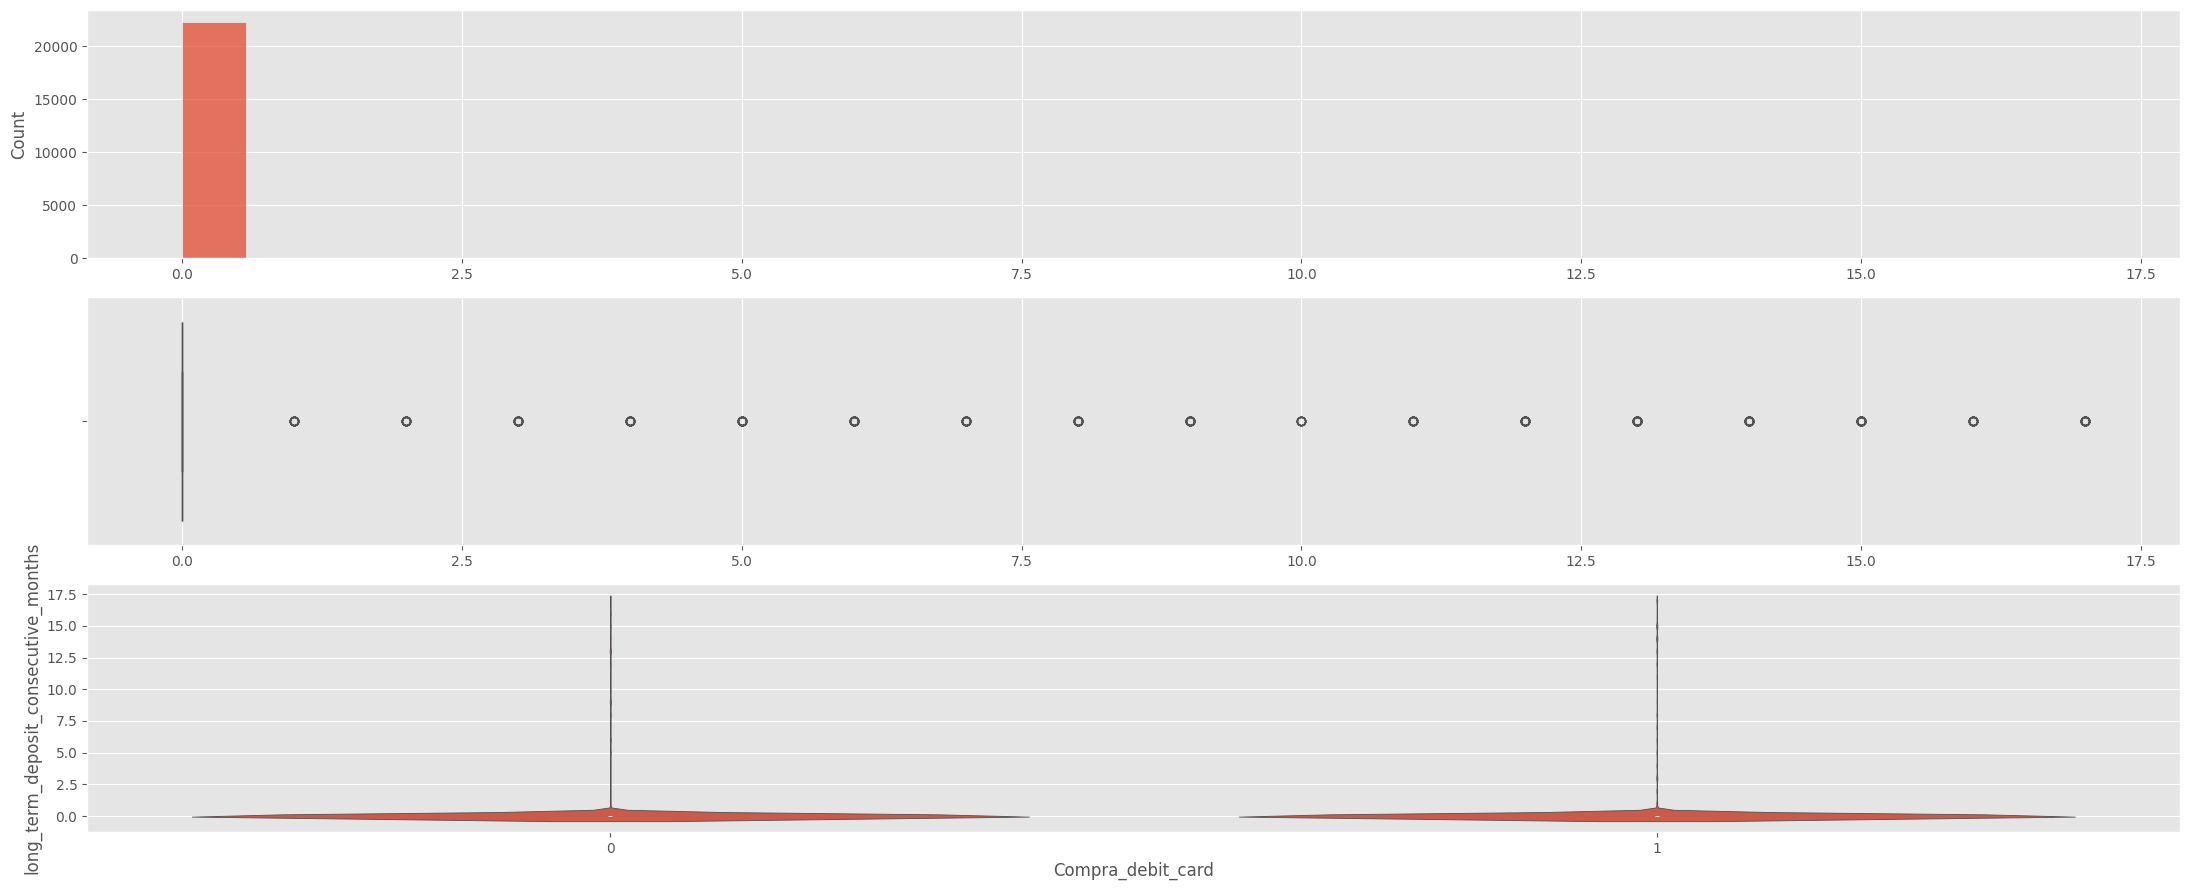

In [243]:
plot_num(df, 'long_term_deposit_consecutive_months', TARGET)

In [244]:
no_explicativas.append('long_term_deposit_consecutive_months')

#### securities_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


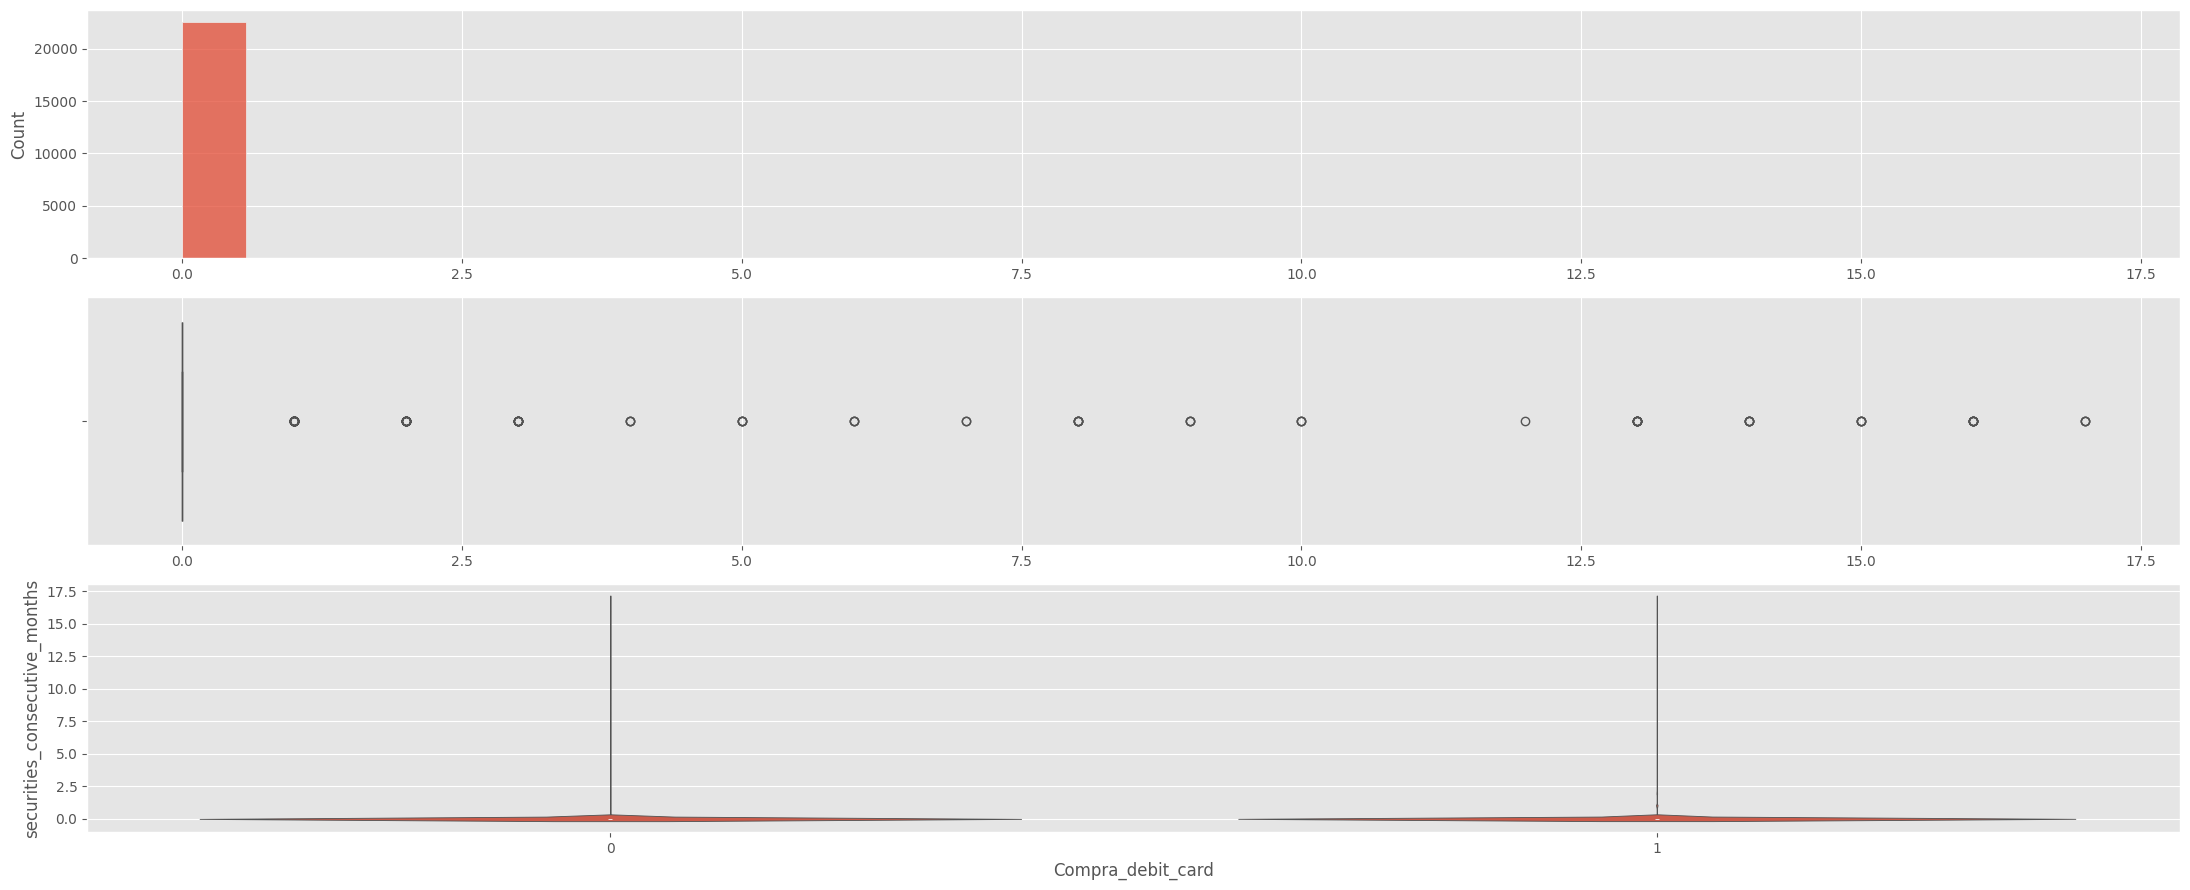

In [245]:
plot_num(df, 'securities_consecutive_months', TARGET)

In [246]:
no_explicativas.append('securities_consecutive_months')

#### funds_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


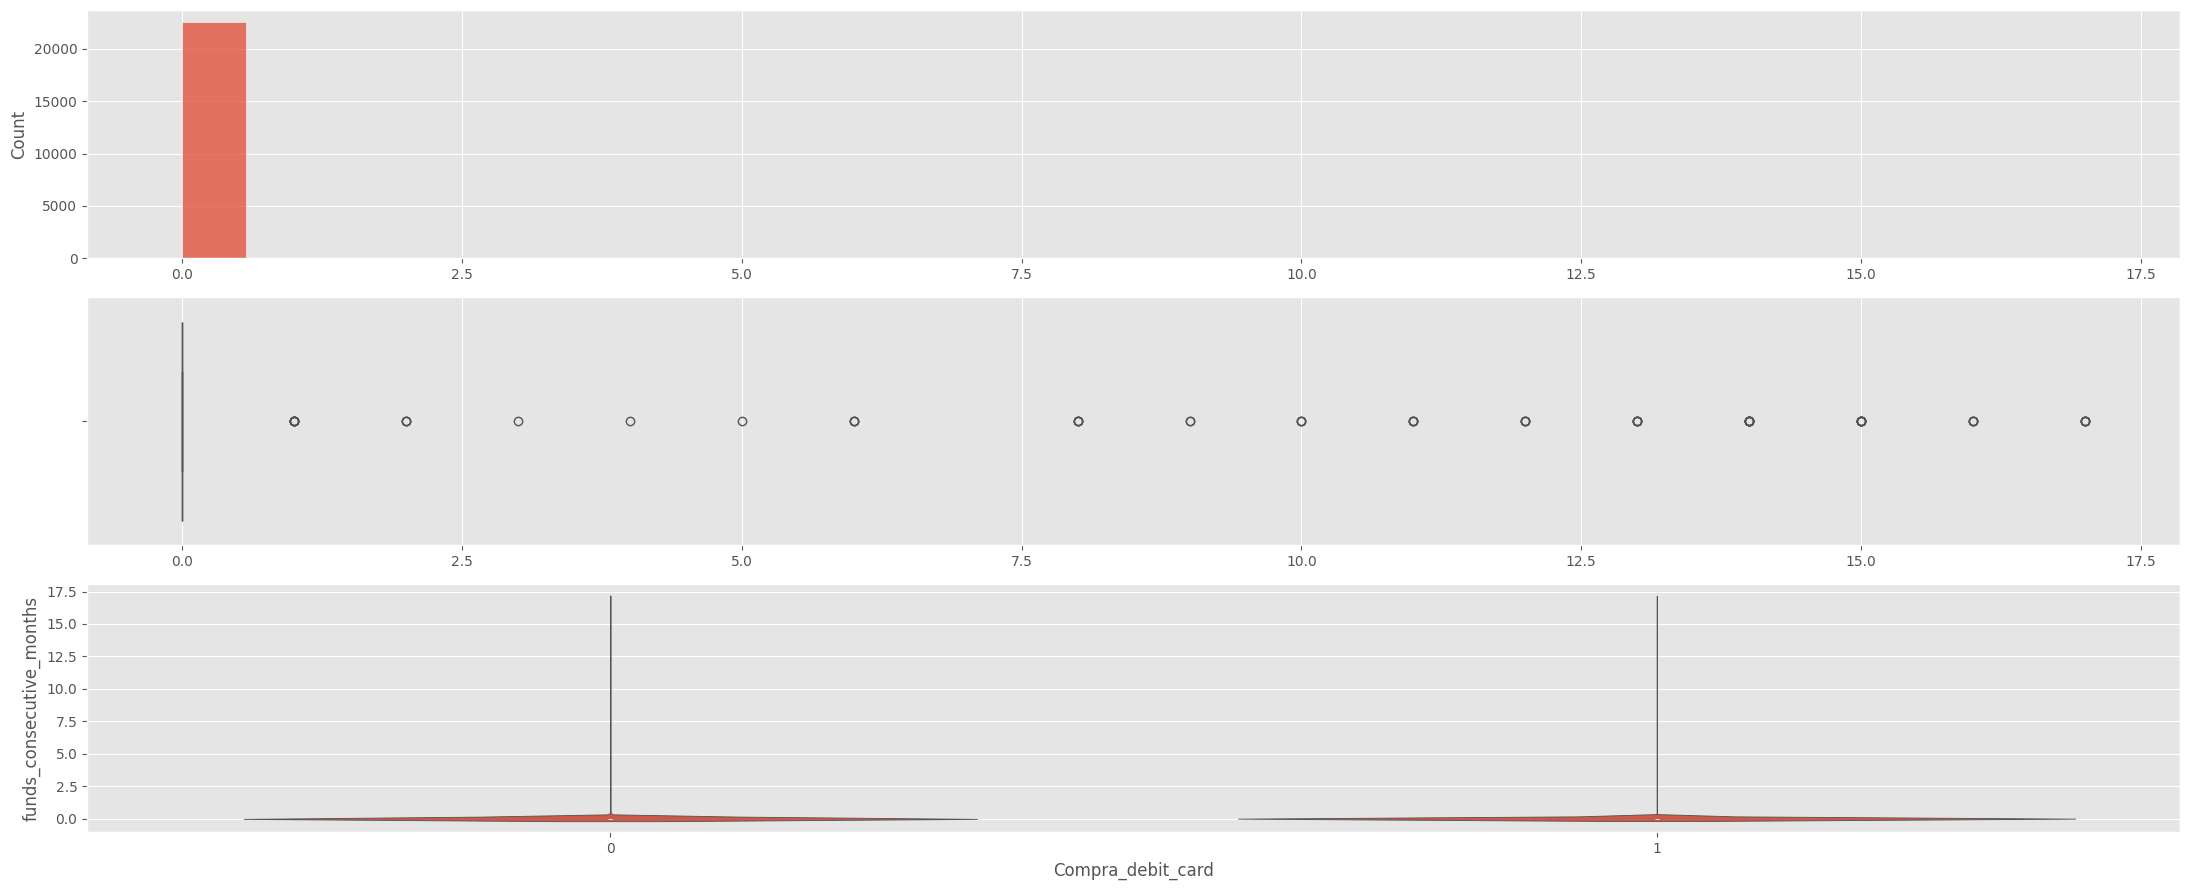

In [247]:
plot_num(df, 'funds_consecutive_months', TARGET)

In [248]:
no_explicativas.append('funds_consecutive_months')

#### mortgage_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


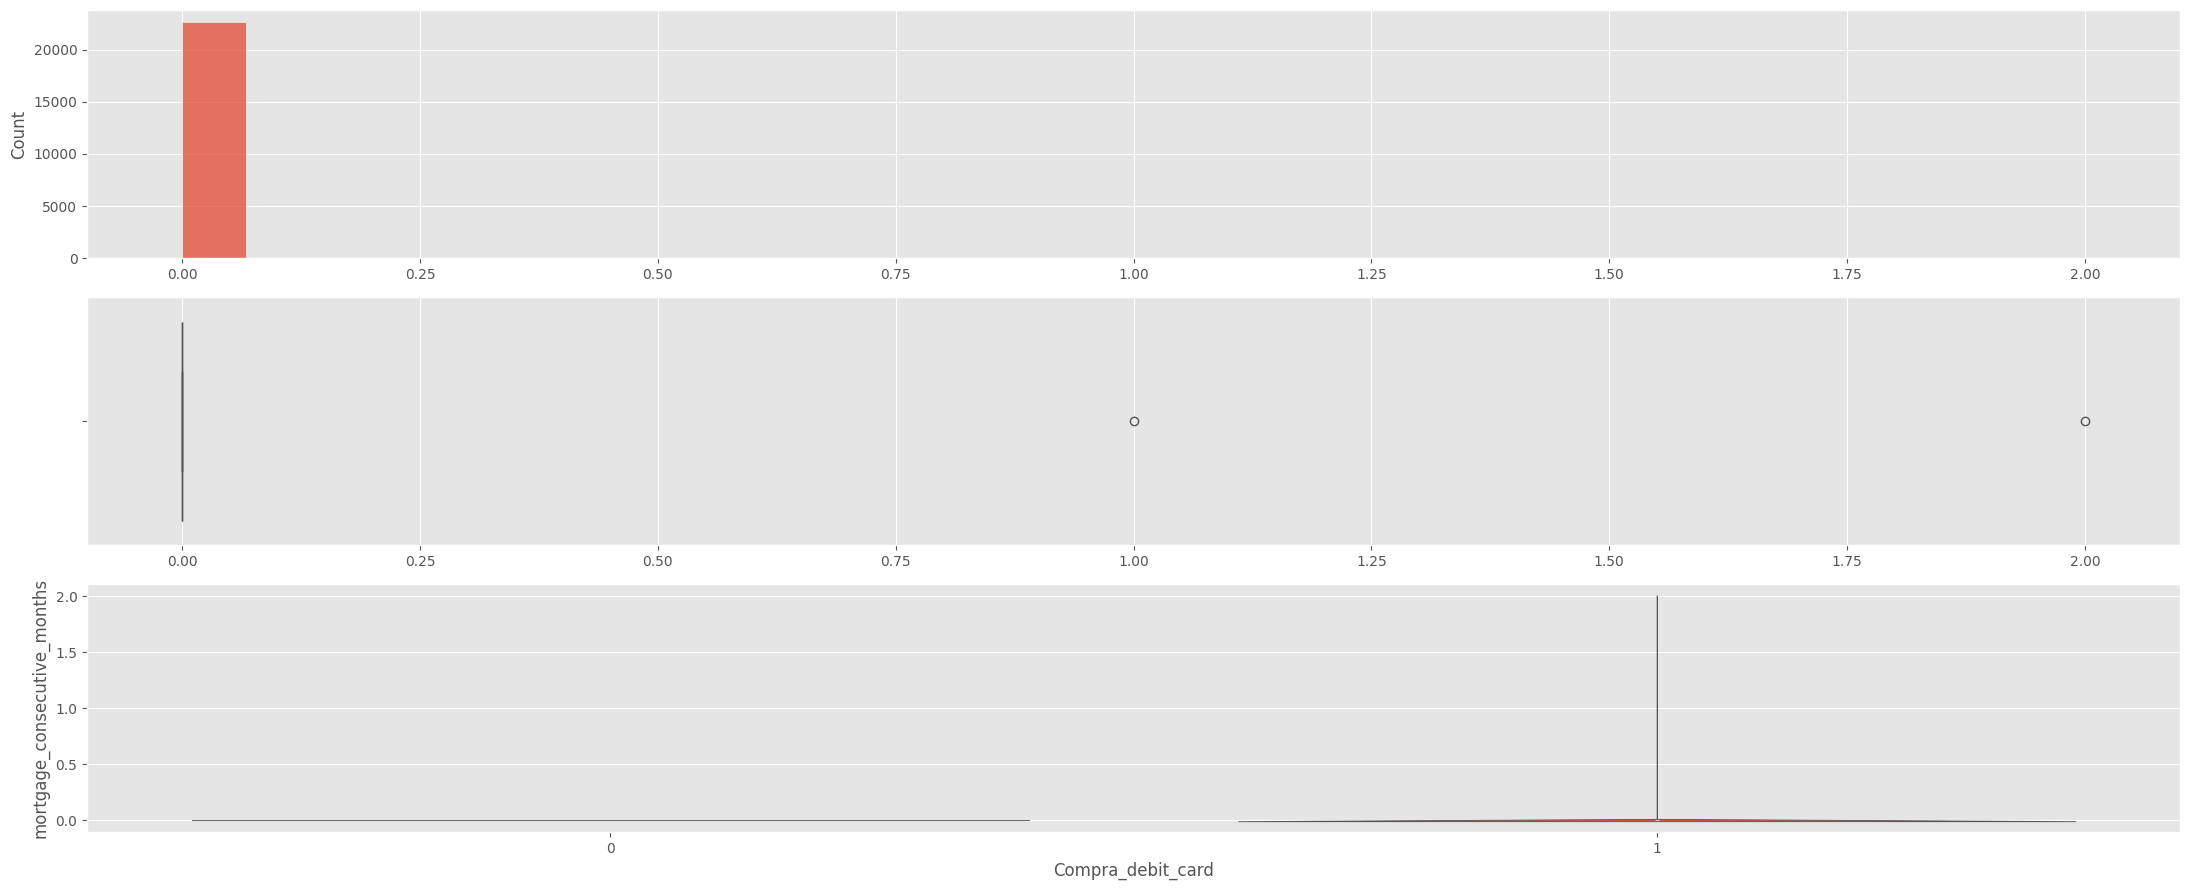

In [249]:
plot_num(df, 'mortgage_consecutive_months', TARGET)

In [250]:
no_explicativas.append('mortgage_consecutive_months')

#### num_accounts

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


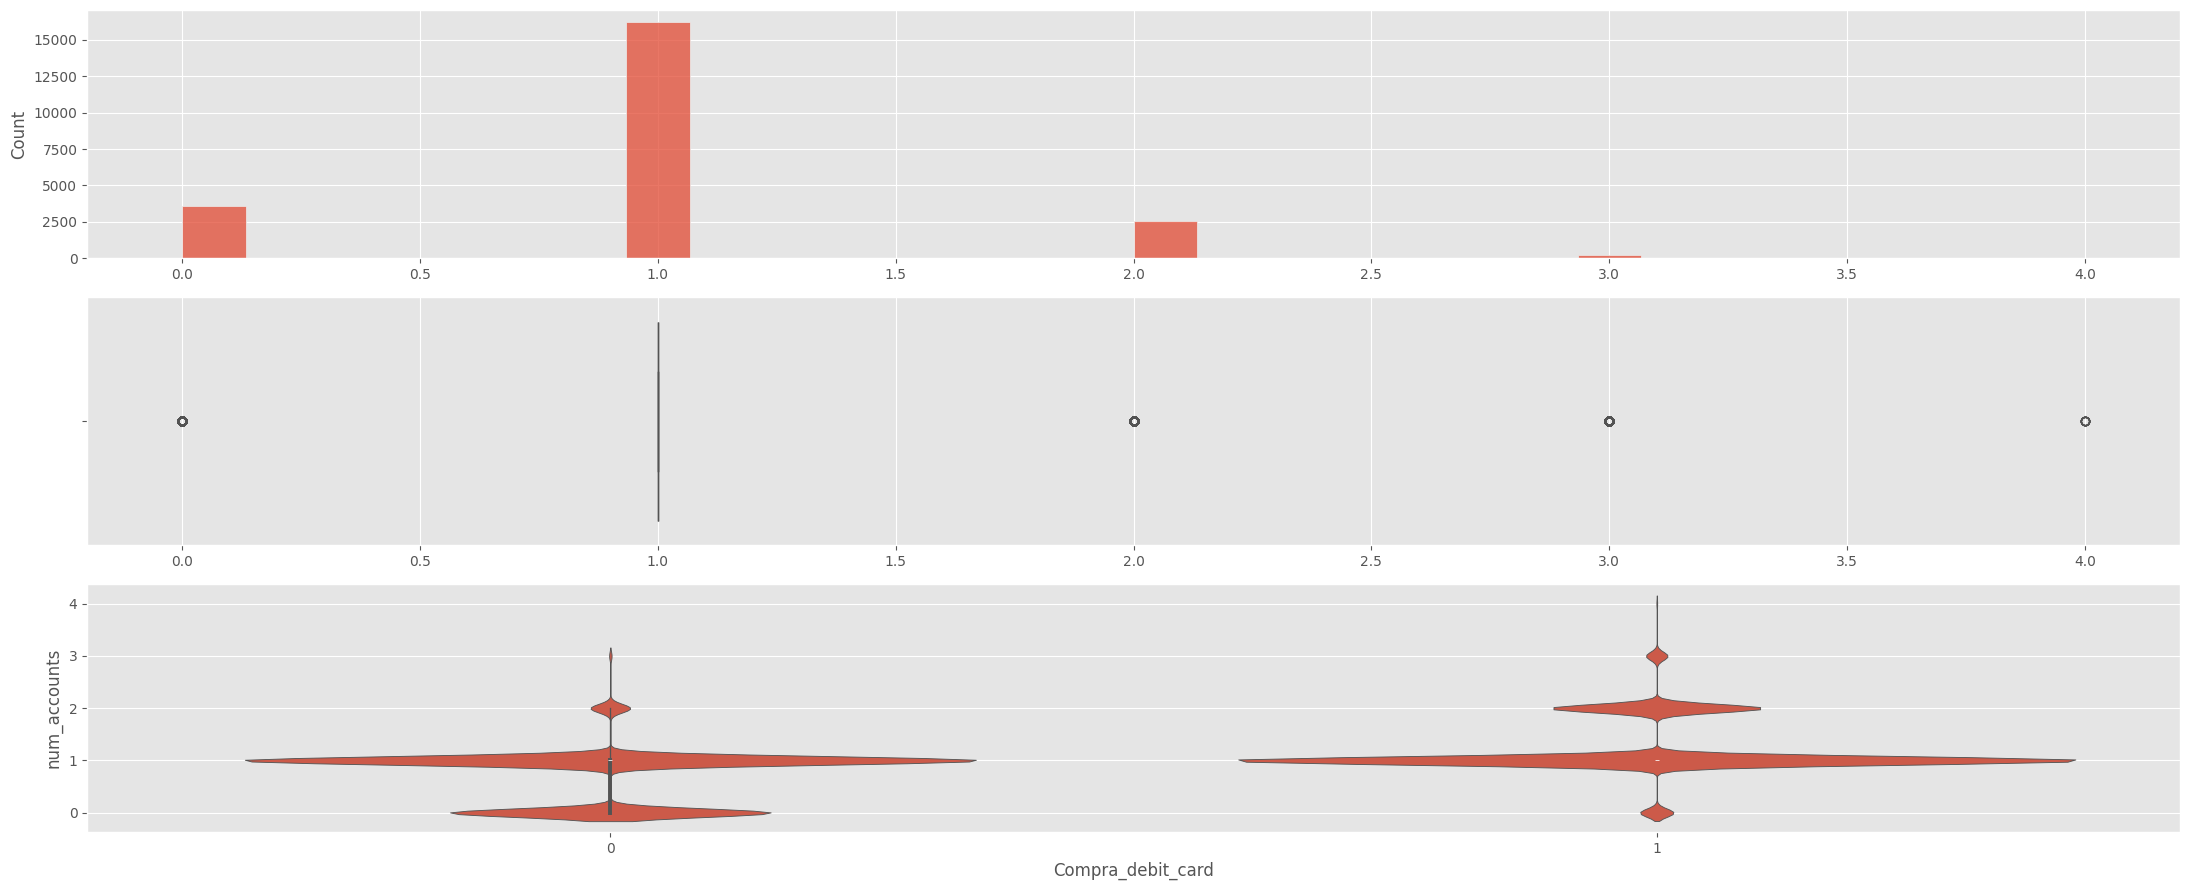

In [251]:
plot_num(df, 'num_accounts', TARGET)

#### meses_antigüedad

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


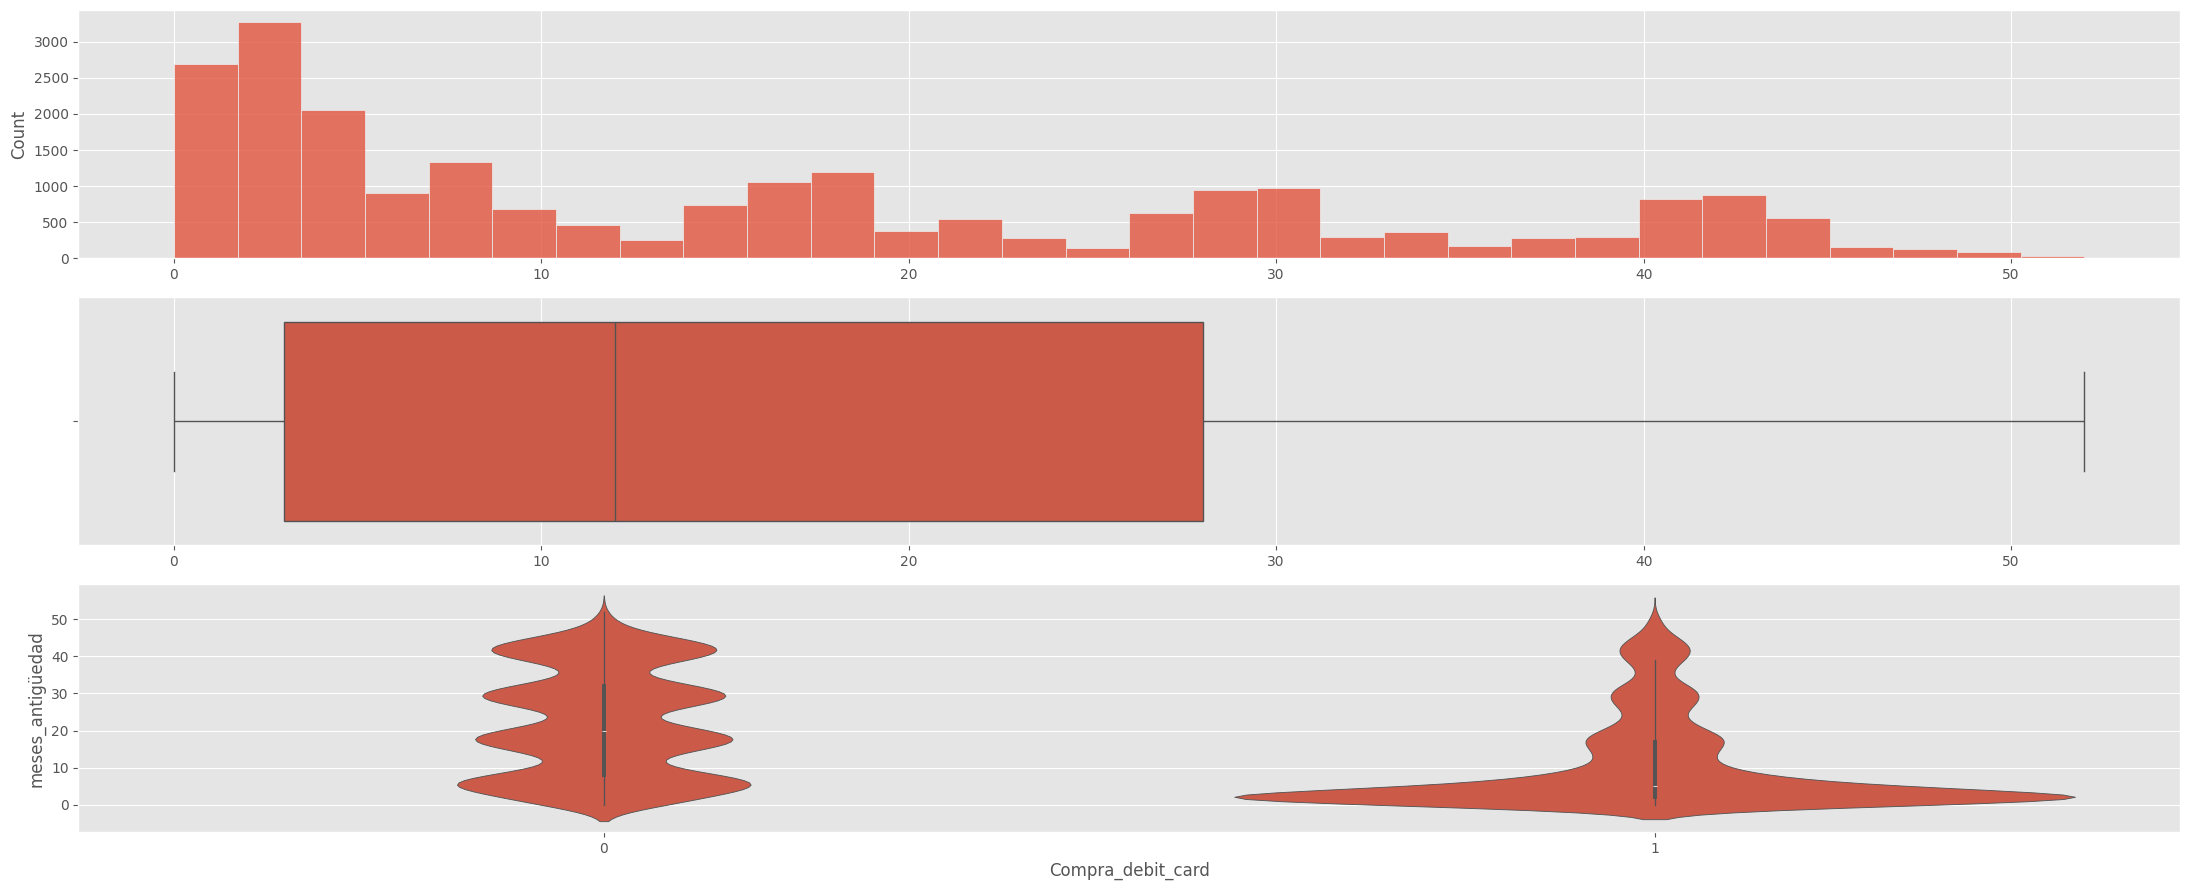

In [252]:
plot_num(df, 'meses_antigüedad', TARGET)

#### days_since_last_purchase

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


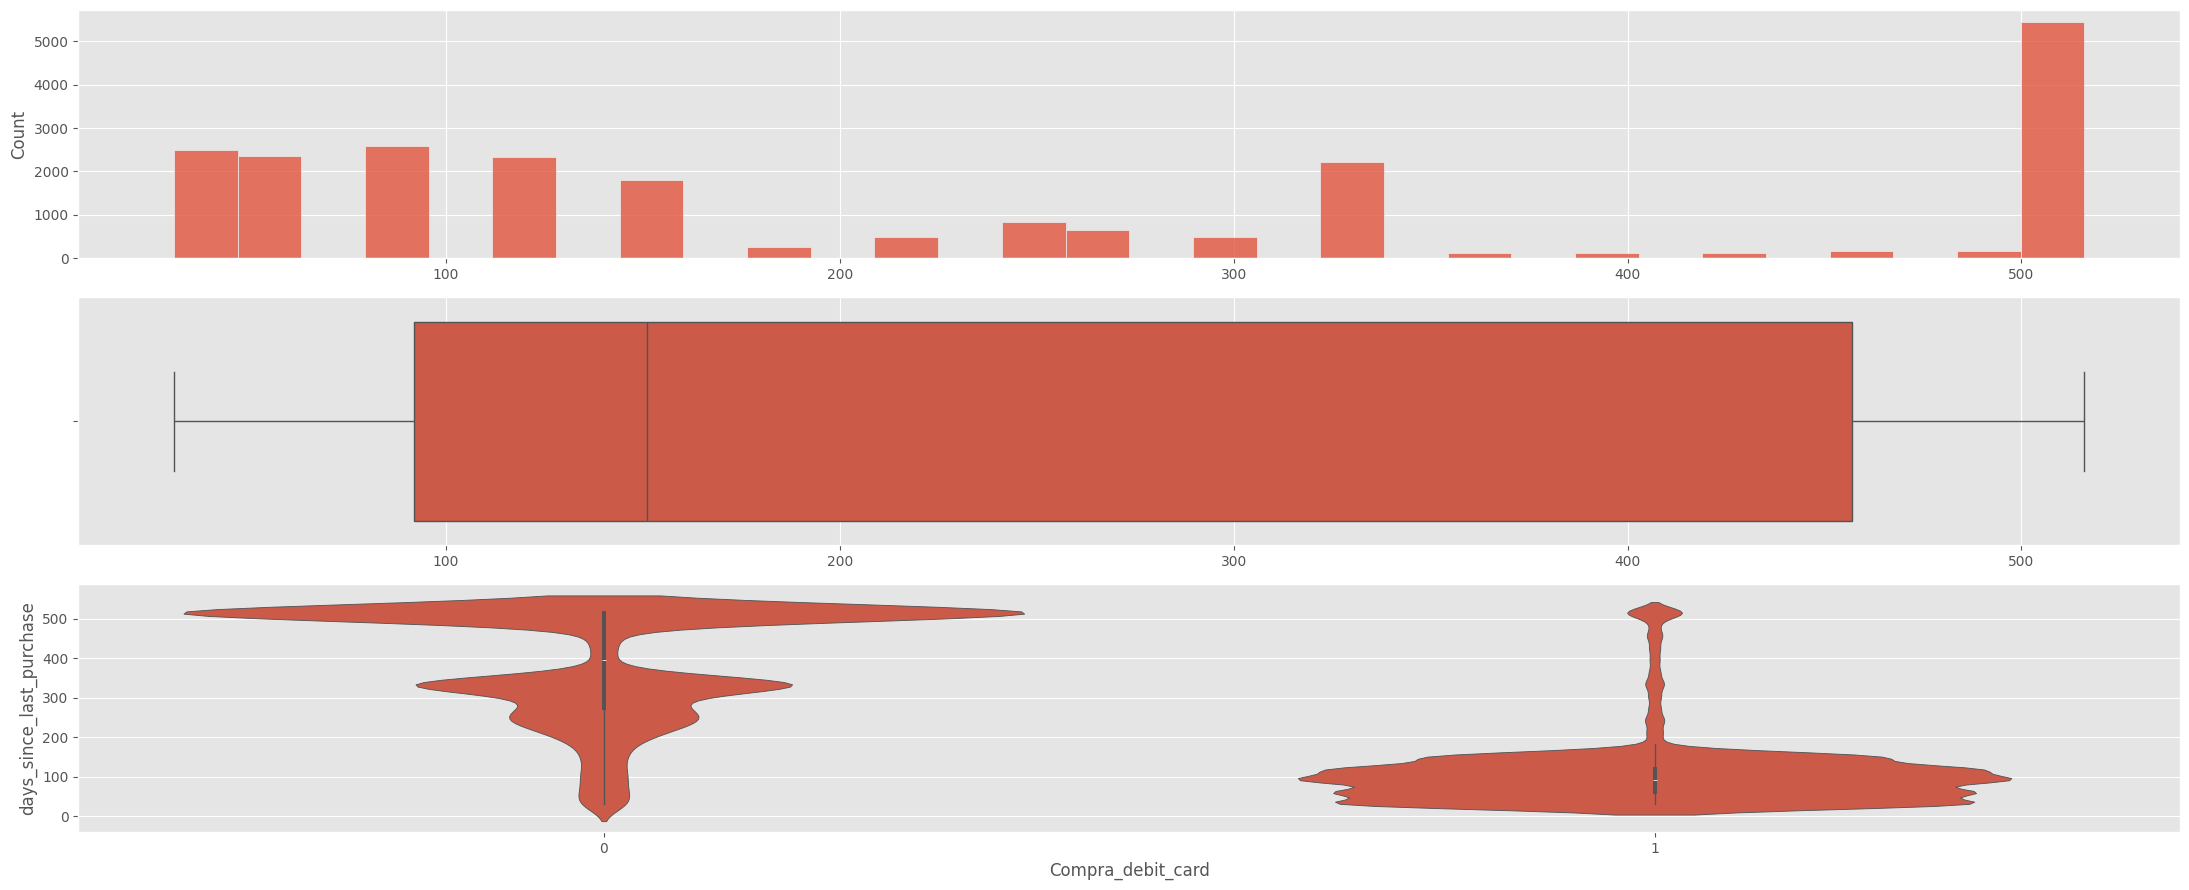

In [253]:
plot_num(df, 'days_since_last_purchase', TARGET)

In [254]:
#no_explicativas.append('days_since_last_purchase')

### Booleanas

In [255]:
booleanas

['active_customer',
 'short_term_deposit_consecutive_months',
 'loans_consecutive_months',
 'has_account',
 'has_pension_plan',
 'has_investment',
 'has_loan',
 'has_credit_card_debt',
 'num_debt_products']

Todas las variables que vamos a analizar a continuación son variables booleanas, lo que significa que no hace falta aplicar el OneHotEncoding y unicamente vamos a discutir si se trata de variables relevantes para nuestro modelo o no.

#### active_customer

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_3120\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


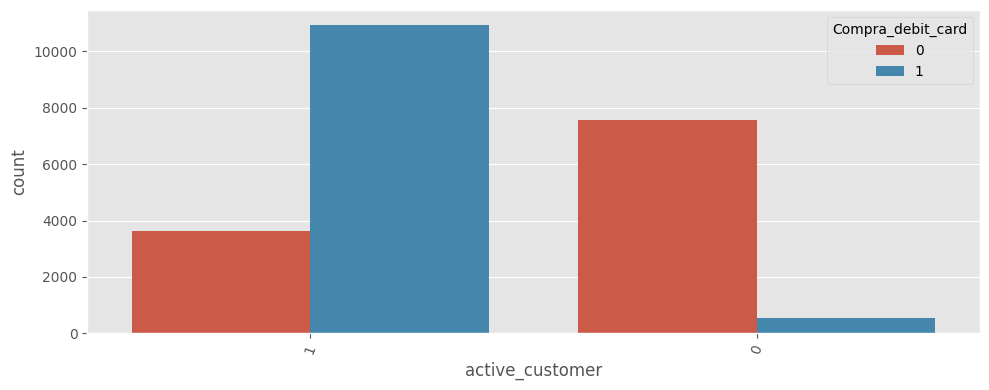

,Num_clientes,Num_compras,Porcentaje_compra
active_customer,,,
1,14560,10925,0.750343
0,8093,540,0.066724


In [256]:
analisis_cat(df, 'active_customer', TARGET)

#### short_term_deposit_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_3120\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


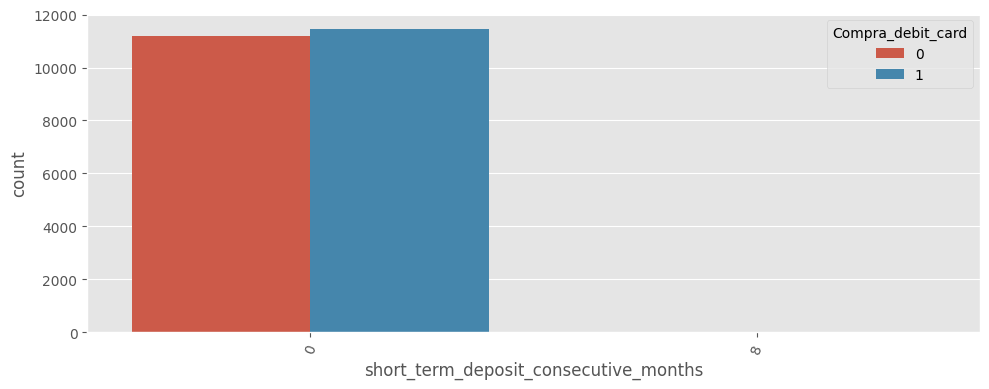

,Num_clientes,Num_compras,Porcentaje_compra
short_term_deposit_consecutive_months,,,
0,22652,11465,0.506136
8,1,0,0.000000


In [257]:
analisis_cat(df, 'short_term_deposit_consecutive_months', TARGET)

In [258]:
no_explicativas.append('short_term_deposit_consecutive_months')

#### loans_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_3120\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


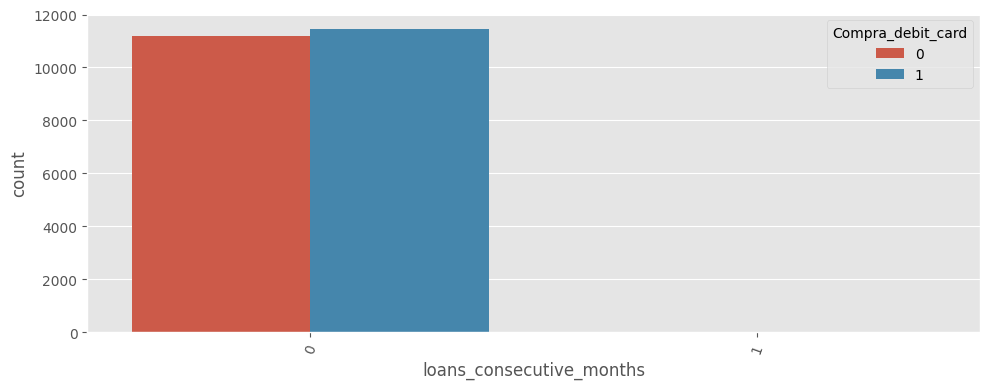

,Num_clientes,Num_compras,Porcentaje_compra
loans_consecutive_months,,,
0,22652,11464,0.506092
1,1,1,1.000000


In [259]:
analisis_cat(df, 'loans_consecutive_months', TARGET)

In [260]:
no_explicativas.append('loans_consecutive_months')

#### has_account

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_3120\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


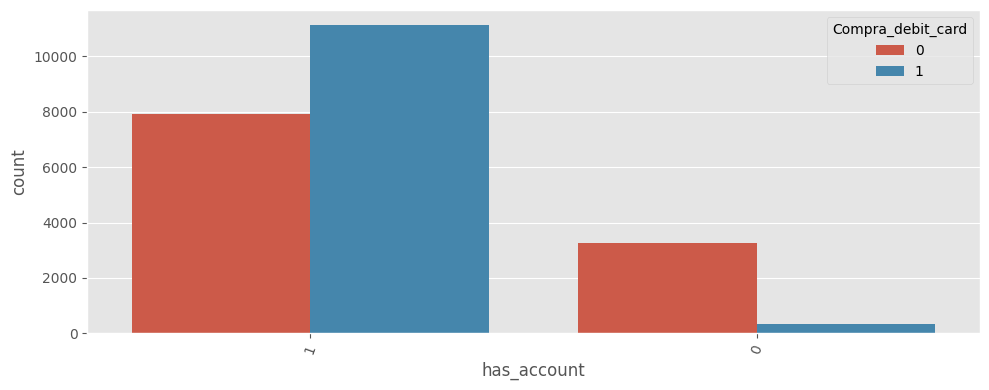

,Num_clientes,Num_compras,Porcentaje_compra
has_account,,,
1,19055,11123,0.583731
0,3598,342,0.095053


In [261]:
analisis_cat(df, 'has_account', TARGET)

#### has_pension_plan

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_3120\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


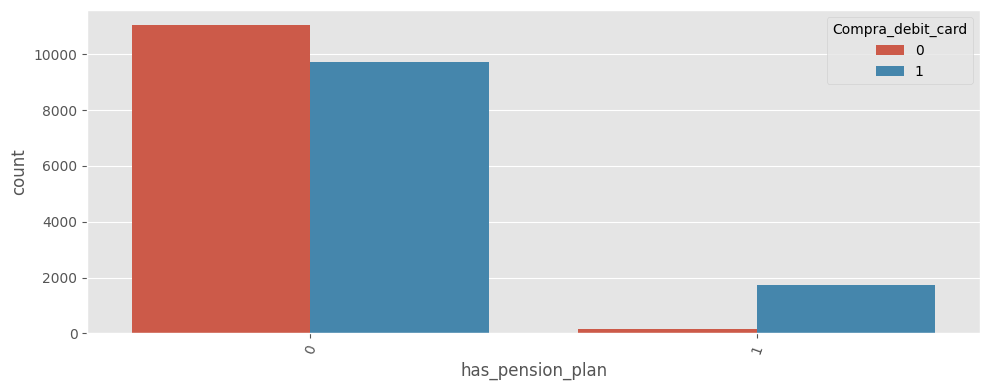

,Num_clientes,Num_compras,Porcentaje_compra
has_pension_plan,,,
0,20751,9719,0.468363
1,1902,1746,0.917981


In [262]:
analisis_cat(df, 'has_pension_plan', TARGET)

#### has_investment

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_3120\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


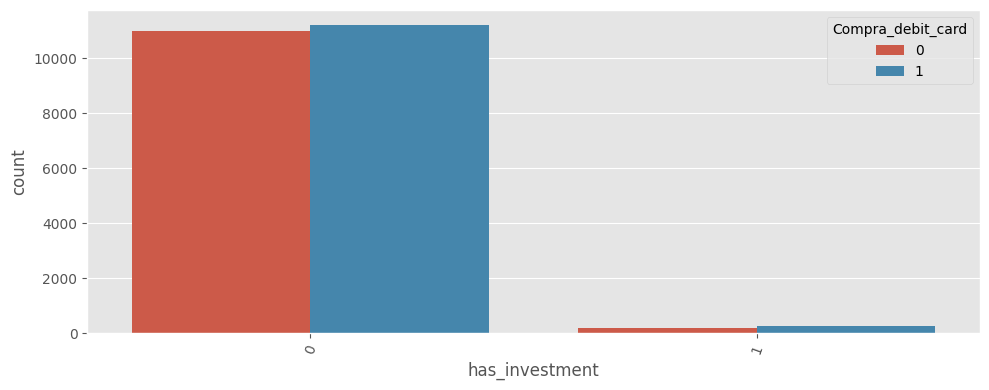

,Num_clientes,Num_compras,Porcentaje_compra
has_investment,,,
0,22184,11195,0.504643
1,469,270,0.575693


In [263]:
analisis_cat(df, 'has_investment', TARGET)

In [264]:
no_explicativas.append('has_investment')

#### has_loan

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_3120\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


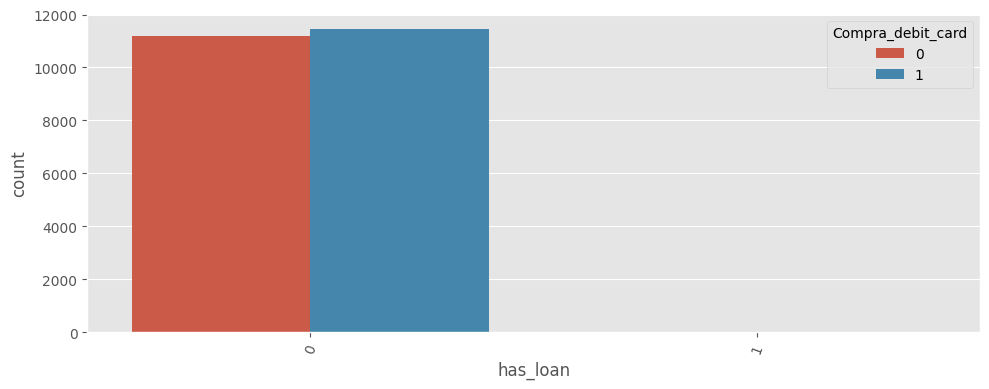

,Num_clientes,Num_compras,Porcentaje_compra
has_loan,,,
0,22650,11462,0.506049
1,3,3,1.000000


In [265]:
analisis_cat(df, 'has_loan', TARGET)

In [266]:
no_explicativas.append('has_loan')

#### has_credit_card_debt

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_3120\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


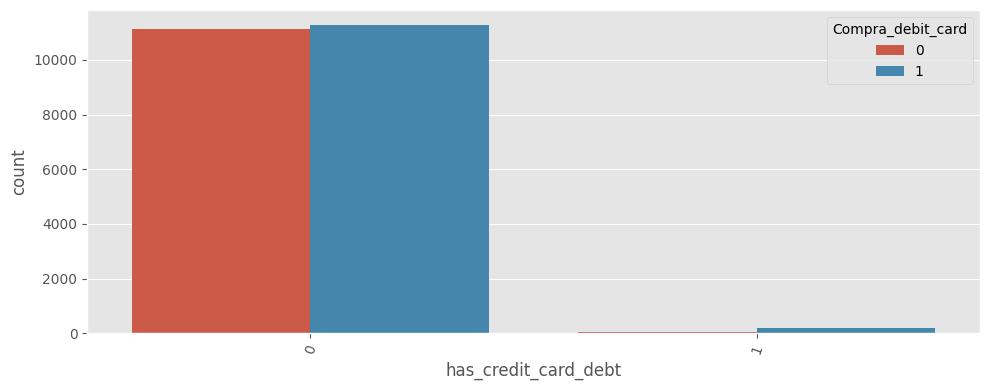

,Num_clientes,Num_compras,Porcentaje_compra
has_credit_card_debt,,,
0,22399,11266,0.502969
1,254,199,0.783465


In [267]:
analisis_cat(df, 'has_credit_card_debt', TARGET)

In [268]:
no_explicativas.append('has_credit_card_debt')

#### num_debt_products

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_3120\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


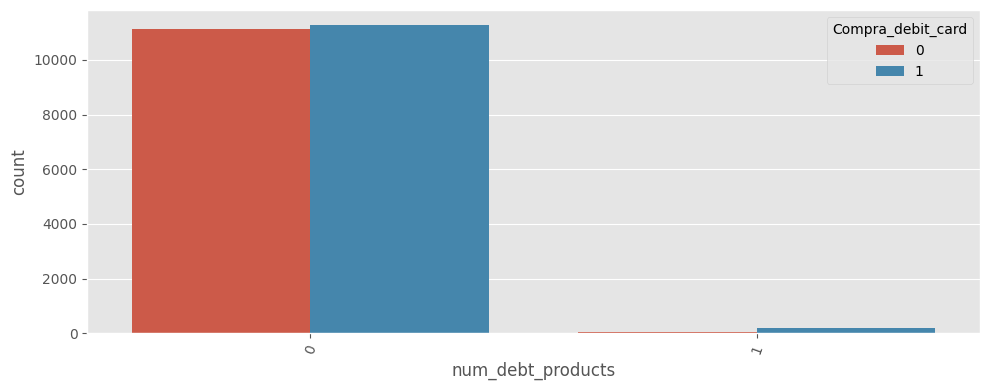

,Num_clientes,Num_compras,Porcentaje_compra
num_debt_products,,,
0,22399,11266,0.502969
1,254,199,0.783465


In [269]:
analisis_cat(df, 'num_debt_products', TARGET)

In [270]:
no_explicativas.append('num_debt_products')

<a id='analisis_multivariante'></a>
## Análisis Multivariante
[Volver al índice](#index)

En este apartado analizamos la distribución de variables 2 a 2 y analizamos la correlación que puede existir entre ellas.

Pero antes eliminamos aquellas variables que hemos considerado no explicativas.

In [271]:
no_explicativas

['country_id',
 'region_code',
 'deceased',
 'tipo_cliente',
 'pk_partition_month',
 'credit_card_consecutive_months',
 'long_term_deposit_consecutive_months',
 'securities_consecutive_months',
 'funds_consecutive_months',
 'mortgage_consecutive_months',
 'short_term_deposit_consecutive_months',
 'loans_consecutive_months',
 'has_investment',
 'has_loan',
 'has_credit_card_debt',
 'num_debt_products']

In [272]:
df = df.drop(columns=no_explicativas)

In [273]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22653 entries, 1517558 to 1546388
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   gender                              22653 non-null  object  
 1   age                                 22653 non-null  int64   
 2   salary                              22653 non-null  float64 
 3   entry_channel                       22653 non-null  category
 4   active_customer                     22653 non-null  int32   
 5   segment                             22653 non-null  object  
 6   entry_date_year                     22653 non-null  int32   
 7   entry_date_month                    22653 non-null  int32   
 8   Compra_debit_card                   22653 non-null  int64   
 9   em_acount_consecutive_months        22653 non-null  int64   
 10  pension_plan_consecutive_months     22653 non-null  int64   
 11  payroll_consecutive_month

In [274]:
numericas,categoricas,booleanas = obtener_lista_variables(df)
print(f'Variables numéricas ({len(numericas)}): {numericas}')
print(f'Variables categóricas ({len(categoricas)}):{categoricas}')
print(f'Variables booleanas ({len(booleanas)}):{booleanas}')

Variables numéricas (13): ['age', 'salary', 'entry_date_year', 'entry_date_month', 'em_acount_consecutive_months', 'pension_plan_consecutive_months', 'payroll_consecutive_months', 'payroll_account_consecutive_months', 'emc_account_consecutive_months', 'num_accounts', 'meses_antigüedad', 'days_since_last_purchase', 'region_encoded']
Variables categóricas (3):['gender', 'entry_channel', 'segment']
Variables booleanas (3):['active_customer', 'has_account', 'has_pension_plan']


In [275]:
from scipy.stats import chi2_contingency

def relacion_categoricas(col_1,col_2):
    """
    Calcula y muestra el coeficiente de Cramér V para medir la asociación entre dos variables categóricas.

    Parámetros:
    col_1 (str): El nombre de la primera columna categórica.
    col_2 (str): El nombre de la segunda columna categórica.

    Retorna:
    None: La función imprime el coeficiente de Cramér V, una medida de asociación entre las dos variables categóricas.
    """
    tabla_contingencia = pd.crosstab(df[col_1], df[col_2])
    chi2, p, dof, ex = chi2_contingency(tabla_contingencia)
    n = tabla_contingencia.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(tabla_contingencia.shape) - 1)))
    print(f'El coeficiente de Cramér V entre {col_1} y {col_2} es de: {cramers_v}')

Vamos a comenzar viendo si ciertas variables estudiadas anteriormente son independientes o no. Para ello hacemos uso de la función **relacion_categoricas** que nos permite calcular el coeficiente de Cramér, el cuál nos da una idea de la independencia entre dos variables categóricas.

Si el coeficiente es igual a 1, las variables son dependientes entre sí, indicando que están fuertemente relacionadas. Por otro lado, cuanto más cercano a 0 sea el coeficiente, más independencia hay entre las dos variables, por lo que no están relacionadas entre sí.

In [276]:
categoricas

['gender', 'entry_channel', 'segment']

In [277]:
print('\n','Relación entre distintas variables categóricas:','\n')
relacion_categoricas('gender','entry_channel')
relacion_categoricas('gender','segment')
relacion_categoricas('segment','entry_channel')


 Relación entre distintas variables categóricas: 

El coeficiente de Cramér V entre gender y entry_channel es de: 0.1371610307185526
El coeficiente de Cramér V entre gender y segment es de: 0.10819287642352915
El coeficiente de Cramér V entre segment y entry_channel es de: 0.7463175932912601


Por otro lado, para las variables numéricas, vamos a crear un dataset con aquellas variables que nos interesan y mediante un heatmap de la matriz de correlación vamos a ser capaces de visualizar la correlación entre las distintas variables.

In [278]:
todas_numericas = df[numericas+booleanas]
corr_numericas = todas_numericas.corr() 
corr_numericas.style.background_gradient(cmap='coolwarm')

,age,salary,entry_date_year,entry_date_month,em_acount_consecutive_months,pension_plan_consecutive_months,payroll_consecutive_months,payroll_account_consecutive_months,emc_account_consecutive_months,num_accounts,meses_antigüedad,days_since_last_purchase,region_encoded,active_customer,has_account,has_pension_plan
age,1.000000,-0.037385,0.204416,-0.262402,-0.210655,0.033627,0.027092,0.041679,0.177175,0.121129,-0.154501,-0.246711,0.136598,0.267681,0.036036,0.073549
salary,-0.037385,1.000000,-0.172639,0.039812,0.104865,0.021791,0.021201,0.034576,0.040710,-0.012898,0.174941,0.133805,0.009049,-0.059160,-0.026751,-0.009001
entry_date_year,0.204416,-0.172639,1.000000,-0.418176,-0.497841,-0.025396,-0.025153,-0.080002,-0.157450,0.061963,-0.967295,-0.610062,0.122003,0.320784,0.076163,0.078876
entry_date_month,-0.262402,0.039812,-0.418176,1.000000,0.189988,-0.026274,-0.026392,-0.015577,-0.042291,-0.084745,0.191028,0.263121,-0.069905,-0.230431,-0.056848,-0.063240
em_acount_consecutive_months,-0.210655,0.104865,-0.497841,0.189988,1.000000,-0.198078,-0.195471,-0.260268,0.036103,0.166306,0.498984,0.472097,-0.164246,-0.106031,0.446240,-0.281678
pension_plan_consecutive_months,0.033627,0.021791,-0.025396,-0.026274,-0.198078,1.000000,0.993882,0.617859,0.068000,0.426233,0.034562,-0.126218,0.049372,0.154501,0.090002,0.684792
payroll_consecutive_months,0.027092,0.021201,-0.025153,-0.026392,-0.195471,0.993882,1.000000,0.611433,0.066046,0.426181,0.034251,-0.124415,0.048173,0.152129,0.088706,0.674284
payroll_account_consecutive_months,0.041679,0.034576,-0.080002,-0.015577,-0.260268,0.617859,0.611433,1.000000,0.083836,0.365602,0.090304,-0.068219,0.049703,0.187749,0.114166,0.505983
emc_account_consecutive_months,0.177175,0.040710,-0.157450,-0.042291,0.036103,0.068000,0.066046,0.083836,1.000000,0.357839,0.181187,0.031390,0.064907,0.117455,0.091202,0.028299
num_accounts,0.121129,-0.012898,0.061963,-0.084745,0.166306,0.426233,0.426181,0.365602,0.357839,1.000000,-0.046317,-0.230372,0.039165,0.496488,0.752553,0.599264


In [279]:
tabla_correlacion = corr_numericas.stack().reset_index()
tabla_correlacion.columns = ['Variable 1', 'Variable 2', 'Correlación']

# Filtrar los valores duplicados y las autocorrelaciones
tabla_correlacion = tabla_correlacion[tabla_correlacion['Variable 1'] != tabla_correlacion['Variable 2']]
tabla_correlacion['abs_Correlación'] = tabla_correlacion['Correlación'].abs()
tabla_correlacion = tabla_correlacion.drop_duplicates(subset=['Correlación'])

# Ordenar los valores por la correlación absoluta
tabla_correlacion = tabla_correlacion.sort_values(by='abs_Correlación', ascending=False)

# Mostrar las correlaciones más altas, tanto positivas como negativas
tabla_correlacion.head(10)

,Variable 1,Variable 2,Correlación,abs_Correlación
86,pension_plan_consecutive_months,payroll_consecutive_months,0.993882,0.993882
42,entry_date_year,meses_antigüedad,-0.967295,0.967295
158,num_accounts,has_account,0.752553,0.752553
95,pension_plan_consecutive_months,has_pension_plan,0.684792,0.684792
111,payroll_consecutive_months,has_pension_plan,0.674284,0.674284
87,pension_plan_consecutive_months,payroll_account_consecutive_months,0.617859,0.617859
103,payroll_consecutive_months,payroll_account_consecutive_months,0.611433,0.611433
43,entry_date_year,days_since_last_purchase,-0.610062,0.610062
159,num_accounts,has_pension_plan,0.599264,0.599264
171,meses_antigüedad,days_since_last_purchase,0.582962,0.582962


In [280]:
correlacion_alta = tabla_correlacion[tabla_correlacion['abs_Correlación']>0.90]['Variable 1'].to_list()
print(f'Se eliminan las siguientes variables debido a su alta correlación con otras columnas: {correlacion_alta}')
df = df.drop(columns= correlacion_alta)

Se eliminan las siguientes variables debido a su alta correlación con otras columnas: ['pension_plan_consecutive_months', 'entry_date_year']


# DATA PREPARATION

Una vez tenemos limpio el dataset y lo tenemos listo para preprocesar vamos a únicamente a estandarizar aquellas variables numéricas que lo requieren. 
Vamos a realizar este paso para tener un dataset de entrenamiento para los modelos de LightGBM y CatBoost que, pese a tratar con variables categóricas sin problema, se recomienda que las variables numéricas si se encuentren estandariazdas/normalizadas. Una vez estandarizadas las variables numéricas, vamos a aplicar un OHE a aquellas variables categóricas que lo necesiten, para tener los datasets preparados para aplicar tanto el modelo de Regresión Logística como el XGBoost.

A su vez, vamos a crear el dataframe sobre el que aplicaremos el modelo final, es decir, aquellos clientes que tenemos en la base de datos del mes de junio y no poseen el producto. Este dataset no contará con el TARGET ya que es la columna a predecir del mismo.

In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22653 entries, 1517558 to 1546388
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   gender                              22653 non-null  object  
 1   age                                 22653 non-null  int64   
 2   salary                              22653 non-null  float64 
 3   entry_channel                       22653 non-null  category
 4   active_customer                     22653 non-null  int32   
 5   segment                             22653 non-null  object  
 6   entry_date_month                    22653 non-null  int32   
 7   Compra_debit_card                   22653 non-null  int64   
 8   em_acount_consecutive_months        22653 non-null  int64   
 9   payroll_consecutive_months          22653 non-null  int64   
 10  payroll_account_consecutive_months  22653 non-null  int64   
 11  emc_account_consecutive_m

In [282]:
numericas,categoricas,booleanas = obtener_lista_variables(df)
print(f'Variables numéricas ({len(numericas)}): {numericas}')
print(f'Variables categóricas ({len(categoricas)}):{categoricas}')
print(f'Variables booleanas ({len(booleanas)}):{booleanas}')

Variables numéricas (11): ['age', 'salary', 'entry_date_month', 'em_acount_consecutive_months', 'payroll_consecutive_months', 'payroll_account_consecutive_months', 'emc_account_consecutive_months', 'num_accounts', 'meses_antigüedad', 'days_since_last_purchase', 'region_encoded']
Variables categóricas (3):['gender', 'entry_channel', 'segment']
Variables booleanas (3):['active_customer', 'has_account', 'has_pension_plan']


<a id='dataframe_predecir'></a>
## Creación del dataframe a predecir
[Volver al índice](#index)

En este apartado vamos a crear el dataframe con las fechas de junio. Para ello vamos a considerar que los clientes son los mismos que en mayo ya que nuestros modelos se basan en los datos que tenemos de los clientes el mes anterior. A su vez, de todos los clientes de mayo debemos eliminar aquellos que han comprado o tienen el producto ya que consideramos que el 100% de clientes mantienen el producto y no se dan de baja del mismo, por lo tanto no lo pueden volver a comprar. Una vez creado este dataframe seguirá el mismo procesamiento de las variables para poder aplicarle el modelo final una vez escogido.

In [283]:
info_clientes_2['entry_date'+'_year'] = info_clientes_2['entry_date'].dt.year
info_clientes_2['entry_date'+'_month'] = info_clientes_2['entry_date'].dt.month
info_clientes_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2177407 entries, 0 to 2177406
Data columns (total 66 columns):
 #   Column                                 Dtype         
---  ------                                 -----         
 0   pk_cid                                 int64         
 1   pk_partition                           datetime64[ns]
 2   country_id                             object        
 3   region_code                            int32         
 4   gender                                 object        
 5   age                                    int64         
 6   deceased                               object        
 7   salary                                 float64       
 8   age_group                              object        
 9   salary_bracket                         category      
 10  em_acount_consecutive_months           int64         
 11  debit_card_consecutive_months          int64         
 12  pension_plan_consecutive_months        int64         
 1

In [284]:
# comenzamos escogiendo los datos de todos los clientes de mayo que no poseen el producto
clientes_junio = info_clientes_2[info_clientes_2['pk_partition']=='2019-05-01']
clientes_junio_con_producto = clientes_junio[clientes_junio[producto]==1]
clientes_junio_sin_producto = clientes_junio[clientes_junio[producto]==0]
print(f'En junio tenemos un total de {clientes_junio.shape[0]}','\n',
      f'de los cuales poseen el producto {clientes_junio_con_producto.shape[0]}','\n',
      f'y sin producto {clientes_junio_sin_producto.shape[0]}')

En junio tenemos un total de 442995 
 de los cuales poseen el producto 43261 
 y sin producto 399734


Sobre aquellos clientes que no poseen el producto es sobre los que vamos aplicar el modelo de propensión a compra definitivo. De este modo obtendremos aquellos clientes más propensos a obtener el producto.

In [285]:
# necesitamos que el dataset tenga las mismas columnas que el dataset que vamos a implementarle al modelo, por lo tanto 
# obtenemos las columnas en común
columnas_comunes = clientes_junio_sin_producto.columns.intersection(df.columns).to_list()

# nos quedamos unicamente con las columnas comunes a ambos
clientes_junio_sin_producto = clientes_junio_sin_producto[columnas_comunes+['pk_cid','region_code']]
clientes_junio_sin_producto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399734 entries, 1734412 to 2177406
Data columns (total 18 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   gender                              399734 non-null  object 
 1   age                                 399734 non-null  int64  
 2   salary                              262717 non-null  float64
 3   em_acount_consecutive_months        399734 non-null  int64  
 4   payroll_consecutive_months          399734 non-null  int64  
 5   payroll_account_consecutive_months  399734 non-null  int64  
 6   emc_account_consecutive_months      399734 non-null  int64  
 7   has_account                         399734 non-null  int64  
 8   has_pension_plan                    399734 non-null  int32  
 9   num_accounts                        399734 non-null  int64  
 10  entry_channel                       399734 non-null  object 
 11  active_customer         

In [286]:
# ahora debemos tratar cada columna de la misma manera que hemos tratado el resto de variables

# a los nulos le imputamos el valor -1
clientes_junio_sin_producto['salary'] = np.where(clientes_junio_sin_producto['salary'].isna(),-1,clientes_junio_sin_producto['salary'])
clientes_junio_sin_producto['days_since_last_purchase'] = np.where(clientes_junio_sin_producto['days_since_last_purchase'].isna(),-1,clientes_junio_sin_producto['days_since_last_purchase'])

# reemplazamos la variable de región con la tasa media de compra por región
clientes_junio_sin_producto['region_encoded'] = clientes_junio_sin_producto['region_code'].map(region_target_mean)
clientes_junio_sin_producto = clientes_junio_sin_producto.drop(columns=['region_code'])

# ponemos la variable más bonita

clientes_junio_sin_producto['segment'] = np.where(clientes_junio_sin_producto['segment']=='03 - UNIVERSITARIO','Universitario',clientes_junio_sin_producto['segment'])
clientes_junio_sin_producto['segment'] = np.where(clientes_junio_sin_producto['segment']=='02 - PARTICULARES','Particulares',clientes_junio_sin_producto['segment'])
clientes_junio_sin_producto['segment'] = np.where(clientes_junio_sin_producto['segment']=='01 - TOP','Top',clientes_junio_sin_producto['segment'])

# necesitamos tener los mismos canales que en el dataset procesado
allowed_categories = ['KHE', 'KHM', 'KHQ', 'KHN', 'KFC', 'KAT', 'KHK', 'Unknown', 'Others', 'RED', 'KFA']

# reemplazamos las categorías no permitidas por 'Others'
clientes_junio_sin_producto['entry_channel'] = clientes_junio_sin_producto['entry_channel'].apply(lambda x: x if x in allowed_categories else 'Others')

# por úlimo establecemos el pk_cid como el index
clientes_junio_sin_producto.set_index('pk_cid',inplace=True)


In [287]:
clientes_junio_sin_producto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399734 entries, 657826 to 1550586
Data columns (total 17 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   gender                              399734 non-null  object 
 1   age                                 399734 non-null  int64  
 2   salary                              399734 non-null  float64
 3   em_acount_consecutive_months        399734 non-null  int64  
 4   payroll_consecutive_months          399734 non-null  int64  
 5   payroll_account_consecutive_months  399734 non-null  int64  
 6   emc_account_consecutive_months      399734 non-null  int64  
 7   has_account                         399734 non-null  int64  
 8   has_pension_plan                    399734 non-null  int32  
 9   num_accounts                        399734 non-null  int64  
 10  entry_channel                       399734 non-null  object 
 11  active_customer          

<a id='transformacion'></a>
## Transformación de atributos
[Volver al índice](#index)

En este apartado aplicamos el OneHotEncoding y el Ordinal Encoding sobre aquellas variables que lo requieran tanto en el dataset que usaremos para entrenar los modelos como en el dataset final sobre el que haremos la predicción.

In [288]:
categoricas

['gender', 'entry_channel', 'segment']

In [289]:
numericas

['age',
 'salary',
 'entry_date_month',
 'em_acount_consecutive_months',
 'payroll_consecutive_months',
 'payroll_account_consecutive_months',
 'emc_account_consecutive_months',
 'num_accounts',
 'meses_antigüedad',
 'days_since_last_purchase',
 'region_encoded']

In [290]:
# comenzamos aplicando StandardScaler a aquellas variables numéricas para que a los modelos les resulte más fácil encontrar patrones
scaler = StandardScaler()
# Aplicar el escalado solo a las columnas numéricas tanto del dataframe de 'entrenamiento' como el de junio
df[numericas] = scaler.fit_transform(df[numericas])
clientes_junio_sin_producto[numericas] = scaler.fit_transform(clientes_junio_sin_producto[numericas])

In [291]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
age,22653.0,-8.217993e-17,1.000022,-2.464554,-0.796846,-0.240943,0.473789,5.715156
salary,22653.0,-8.782588e-18,1.000022,-0.307488,-0.307488,-0.147866,0.152056,110.754005
active_customer,22653.0,6.427405e-01,0.479203,0.000000,0.000000,1.000000,1.000000,1.000000
entry_date_month,22653.0,-1.154283e-16,1.000022,-1.781779,-0.939141,0.184376,0.746135,1.307894
Compra_debit_card,22653.0,5.061140e-01,0.499974,0.000000,0.000000,1.000000,1.000000,1.000000
em_acount_consecutive_months,22653.0,-8.531657e-17,1.000022,-1.026933,-1.026933,-0.393772,1.030839,1.663999
payroll_consecutive_months,22653.0,2.258380e-17,1.000022,-0.204140,-0.204140,-0.204140,-0.204140,12.144989
payroll_account_consecutive_months,22653.0,-2.383845e-17,1.000022,-0.262731,-0.262731,-0.262731,-0.262731,7.018880
emc_account_consecutive_months,22653.0,-4.767691e-17,1.000022,-0.209883,-0.209883,-0.209883,-0.209883,6.408712
has_account,22653.0,8.411689e-01,0.365527,0.000000,1.000000,1.000000,1.000000,1.000000


In [292]:
df.head()

,gender,age,salary,entry_channel,active_customer,segment,entry_date_month,Compra_debit_card,em_acount_consecutive_months,payroll_consecutive_months,payroll_account_consecutive_months,emc_account_consecutive_months,has_account,has_pension_plan,num_accounts,meses_antigüedad,days_since_last_purchase,region_encoded
cid,,,,,,,,,,,,,,,,,,
1517558,V,0.632618,-0.307488,KHN,1,Particulares,1.307894,1,-0.710352,-0.20414,-0.262731,-0.209883,1,0,0.039488,-1.054340,-1.007431,1.939935
1161959,H,-0.558602,-0.109460,KAT,0,Universitario,0.184376,0,1.030839,-0.20414,-0.262731,-0.209883,1,0,0.039488,0.878981,1.484603,-0.181164
1100492,H,-0.796846,-0.130175,KHE,0,Universitario,1.027014,0,1.030839,-0.20414,-0.262731,-0.209883,1,0,0.039488,1.500405,1.484603,0.942360
1391462,V,1.188520,0.044452,KHN,0,Top,-0.939141,1,-1.026933,-0.20414,-0.262731,-0.209883,0,0,-1.731852,-0.501963,0.153693,0.901857
1391434,V,1.823838,-0.307488,KHK,1,Particulares,-0.939141,1,-1.026933,-0.20414,0.165599,-0.209883,1,0,0.039488,-0.501963,-0.344714,-0.920194


En este momento ya tenemos el dataframe procesado para los modelos que soportan categorías como son LightGBM y CatBoost. Por lo tanto realizaremos una copia de este dataframe para usarlo en el entrenamiento de dichos modelos.

In [293]:
df_cat_procesado = df.copy()
junio_procesado = clientes_junio_sin_producto.copy()

In [294]:
#df_cat_procesado.to_pickle('df_cat_procesado.pkl')

In [295]:
def dummie(dataframe, columnas, col_dummie=None):
    """
    Genera columnas dummies a partir de una o varias columnas categóricas en un DataFrame, añade las dummies generadas al DataFrame original y elimina las columnas originales.

    Parámetros:
    dataframe (pd.DataFrame): El DataFrame sobre el cual se va a aplicar la transformación. 
    columnas (str o list): El nombre de una columna o una lista de columnas categóricas que se van a transformar en dummies. 
    col_dummie (str, optional): El nombre de la columna dummy específica que se desea añadir al DataFrame. 
                                Si se especifica, solo esa columna dummy se añadirá al DataFrame.
                                Si no se especifica (None), se añadirán todas las columnas dummies generadas.
        
    Retorna:
    pd.DataFrame: Un nuevo DataFrame con las columnas dummies añadidas y las columnas originales eliminadas.
    """
    # Convertir 'columnas' a lista si no lo es
    if isinstance(columnas, str):
        columnas = [columnas]
    
    for columna in columnas:
        # Aplicamos el OneHotEncoding
        _dummy_dataset = pd.get_dummies(dataframe[columna], prefix=columna)

        # Si se especifica una columna en particular, seleccionamos solo esa
        if col_dummie is not None:
            _dummy_dataset = _dummy_dataset[[col_dummie]]

        # Añadimos las columnas dummies al dataframe original
        dataframe = pd.concat([dataframe, _dummy_dataset.astype(int)], axis=1)

        # Eliminamos la columna original
        dataframe = dataframe.drop(columns=[columna])
    
    return dataframe

Comenzamos aplicando el OneHotEncoding a través de la función *dummie* que nos transforma los valores de la columna a distintas columnas booleanas y elimina la variable original del dataset.

In [296]:
df = dummie(df,categoricas)
clientes_junio = dummie(clientes_junio_sin_producto,categoricas)

In [297]:
correlacion_final = df.corr() 
#correlacion_final.style.background_gradient(cmap='coolwarm')

In [298]:
corr_long = correlacion_final.stack().reset_index()
corr_long.columns = ['Variable 1', 'Variable 2', 'Correlación']

# Filtrar los valores duplicados y las autocorrelaciones
corr_long = corr_long[corr_long['Variable 1'] != corr_long['Variable 2']]
corr_long['abs_Correlación'] = corr_long['Correlación'].abs()
corr_long = corr_long.drop_duplicates(subset=['Correlación'])

# Ordenar los valores por la correlación absoluta
corr_long = corr_long.sort_values(by='abs_Correlación', ascending=False)

# Mostrar las correlaciones más altas, tanto positivas como negativas
corr_long.head(30)

,Variable 1,Variable 2,Correlación,abs_Correlación
496,gender_H,gender_V,-1.000000,1.000000
799,entry_channel_Unknown,segment_Unknown,0.986236,0.986236
926,segment_Particulares,segment_Universitario,-0.896907,0.896907
141,Compra_debit_card,days_since_last_purchase,-0.768991,0.768991
299,has_account,num_accounts,0.752553,0.752553
30,age,segment_Universitario,-0.676553,0.676553
202,payroll_consecutive_months,has_pension_plan,0.674284,0.674284
68,active_customer,Compra_debit_card,0.655219,0.655219
574,entry_channel_KHE,segment_Universitario,0.612715,0.612715
199,payroll_consecutive_months,payroll_account_consecutive_months,0.611433,0.611433


Debido a el tratamiento realizado sobre las variables, las categorías que surgen tras realizar el OneHotEncoding pueden tener altas relaciones como es el caso de la variable gender. Es por ello que hemos realizado esta comprobación final, para asegurarnos de prescindir de estas variables con correlaciones tan altas. 

Pasamos por lo tanto a eliminar una de las dos variables en aquellas que poseen más de un 90% de correlación:

In [299]:
correlacion_alta = corr_long[corr_long['abs_Correlación']>0.90]['Variable 2'].to_list()
correlacion_alta

['gender_V', 'segment_Unknown']

In [300]:
df = df.drop(columns= correlacion_alta)
clientes_junio = clientes_junio.drop(columns = correlacion_alta)

In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22653 entries, 1517558 to 1546388
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age                                 22653 non-null  float64
 1   salary                              22653 non-null  float64
 2   active_customer                     22653 non-null  int32  
 3   entry_date_month                    22653 non-null  float64
 4   Compra_debit_card                   22653 non-null  int64  
 5   em_acount_consecutive_months        22653 non-null  float64
 6   payroll_consecutive_months          22653 non-null  float64
 7   payroll_account_consecutive_months  22653 non-null  float64
 8   emc_account_consecutive_months      22653 non-null  float64
 9   has_account                         22653 non-null  int64  
 10  has_pension_plan                    22653 non-null  int32  
 11  num_accounts                        22

In [302]:
df.head()

,age,salary,active_customer,entry_date_month,Compra_debit_card,em_acount_consecutive_months,payroll_consecutive_months,payroll_account_consecutive_months,emc_account_consecutive_months,has_account,has_pension_plan,num_accounts,meses_antigüedad,days_since_last_purchase,region_encoded,gender_H,entry_channel_KHE,entry_channel_KHM,entry_channel_KHQ,entry_channel_KHN,entry_channel_KFC,entry_channel_KAT,entry_channel_KHK,entry_channel_Unknown,entry_channel_RED,entry_channel_KFA,entry_channel_Others,segment_Particulares,segment_Top,segment_Universitario
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1517558,0.632618,-0.307488,1,1.307894,1,-0.710352,-0.20414,-0.262731,-0.209883,1,0,0.039488,-1.054340,-1.007431,1.939935,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1161959,-0.558602,-0.109460,0,0.184376,0,1.030839,-0.20414,-0.262731,-0.209883,1,0,0.039488,0.878981,1.484603,-0.181164,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1100492,-0.796846,-0.130175,0,1.027014,0,1.030839,-0.20414,-0.262731,-0.209883,1,0,0.039488,1.500405,1.484603,0.942360,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1391462,1.188520,0.044452,0,-0.939141,1,-1.026933,-0.20414,-0.262731,-0.209883,0,0,-1.731852,-0.501963,0.153693,0.901857,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1391434,1.823838,-0.307488,1,-0.939141,1,-1.026933,-0.20414,0.165599,-0.209883,1,0,0.039488,-0.501963,-0.344714,-0.920194,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [303]:
clientes_junio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399734 entries, 657826 to 1550586
Data columns (total 29 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age                                 399734 non-null  float64
 1   salary                              399734 non-null  float64
 2   em_acount_consecutive_months        399734 non-null  float64
 3   payroll_consecutive_months          399734 non-null  float64
 4   payroll_account_consecutive_months  399734 non-null  float64
 5   emc_account_consecutive_months      399734 non-null  float64
 6   has_account                         399734 non-null  int64  
 7   has_pension_plan                    399734 non-null  int32  
 8   num_accounts                        399734 non-null  float64
 9   active_customer                     399734 non-null  float64
 10  meses_antigüedad                    399734 non-null  float64
 11  days_since_last_purchase 

In [304]:
clientes_junio.head()

,age,salary,em_acount_consecutive_months,payroll_consecutive_months,payroll_account_consecutive_months,emc_account_consecutive_months,has_account,has_pension_plan,num_accounts,active_customer,meses_antigüedad,days_since_last_purchase,entry_date_month,region_encoded,gender_H,entry_channel_KAT,entry_channel_KFA,entry_channel_KFC,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_Others,entry_channel_RED,entry_channel_Unknown,segment_Particulares,segment_Top,segment_Universitario
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
657826,1.189784,-0.126656,0.992378,-0.090326,-0.146563,-0.191497,1,0,0.458189,1.0,1.692975,0.908987,-1.120762,-1.895918,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
657817,0.195291,-0.438003,-1.251033,-0.090326,-0.146563,-0.191497,0,0,-1.454284,0.0,-1.671511,-2.523732,-1.120762,-0.761834,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
657905,4.587635,0.442201,0.992378,-0.090326,-0.146563,-0.191497,1,0,0.458189,1.0,0.221012,0.908987,-2.179817,1.069337,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0
657336,0.692537,-0.438003,-0.987102,-0.090326,-0.146563,-0.191497,1,0,0.458189,1.0,-1.531324,-2.311398,-1.826799,1.069337,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
657147,2.681523,0.161232,-1.251033,-0.090326,-0.146563,-0.191497,0,0,-1.454284,0.0,-0.059361,-0.372089,-0.767744,1.069337,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0


Por último, para no tener que correr todo el código en caso de modificaciones o errores en un futuro, procedemos a guardar el dataframe final como un pickle

In [305]:
#df.to_pickle('df_procesado_debit_card.pkl')

# MODELING

En este apartado vamos a preparar el dataset para aplicar distintos modelos que nos ayuden a resolver el problema de clasificación binaria al que nos enfrentamos. Para ello comenzaremos realizando la partición de datos en train, validation y test y finalmente implementaremos los modelos y evaluaremos su rendimiento para escoger el que mejor se adecúe a nuestro propósito.

Nos disponemos a crear una serie de funciones que nos ayuden a analizar cada uno de los modelos que usemos, su rendimiento y su eficacia a través de diferentes gráficas y métricas. 

In [306]:
def grafica_perdidas(modelo,columna1,columna2,func_perdidas):
    """
    Genera una gráfica de las pérdidas (losses) de entrenamiento y validación a lo largo del entrenamiento del modelo.

    Parámetros:
    -----------
    modelo(object):El modelo ya entrenado que contiene los resultados de evaluación en el atributo 'evals_result_'.
    columna1(str): El nombre de la columna que contiene las pérdidas de entrenamiento.
    columna2(str): El nombre de la columna que contiene las pérdidas de validación.
    func_perdidas(str): La métrica de evaluación a graficar (por ejemplo, 'logloss').

    Retorna:
    --------
    Esta función no retorna ningún valor, solo muestra la gráfica de las pérdidas de entrenamiento y validación.

    """
    results = modelo.evals_result_

    # Graficar las pérdidas de entrenamiento y validación
    plt.figure(figsize=(8,5))
    plt.plot(results[columna1][func_perdidas], label="Training loss")
    plt.plot(results[columna2][func_perdidas], label="Validation loss")
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss")
    plt.legend()
    plt.show()

In [307]:
def curva_roc_auc(Y_TEST,Y_PRED_PROBA,nombre_modelo):
    """
    Genera y muestra la curva ROC (Receiver Operating Characteristic) junto con el AUC (Area Under the Curve).

    Esta función calcula la curva ROC y el valor del AUC utilizando las etiquetas verdaderas y las probabilidades 
    predichas para la clase positiva. Luego, grafica la curva ROC para visualizar el rendimiento del modelo.

    Parámetros:
    -----------
    Y_TEST: dataframe -> Las etiquetas verdaderas del conjunto de prueba.
    Y_PRED_PROBA: dataframe -> Las probabilidades predichas de la clase positiva para el conjunto de prueba.

    Retorna:
    --------
    Esta función no retorna ningún valor, solo muestra la gráfica de la curva ROC con el AUC.

    """
    fpr, tpr, thresholds = metrics.roc_curve(Y_TEST, Y_PRED_PROBA)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{nombre_modelo} ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

In [308]:
def dataframe_resumen(Y_TEST,Y_TEST_PRED,Y_PRED_PROBA,product):
    """
    Crea un DataFrame que resume los resultados de las predicciones de compra de un producto, incluyendo el éxito de las predicciones y las probabilidades de compra.

    Esta función toma las etiquetas verdaderas, las predicciones y las probabilidades predichas, las combina en un solo DataFrame y calcula una columna de éxito, 
    que indica si la predicción fue correcta o no. También añade una columna con la probabilidad de compra del producto.

    Parámetros:
    -----------
    Y_TEST (DataFrame): DataFrame que contiene las etiquetas verdaderas de compra de los clientes.
    Y_TEST_PRED (DataFrame): DataFrame que contiene las predicciones del modelo (compra o no compra) para los clientes.
    Y_PRED_PROBA (DataFrame):DataFrame que contiene las probabilidades predichas de compra para el producto en cuestión.
    product (str): El nombre del producto para el cual se realizan las predicciones. Se utiliza para crear columnas específicas en el DataFrame de salida.

    Retorna:
    --------
    DataFrame: Un DataFrame que contiene las etiquetas verdaderas, las predicciones, una columna de éxito ('Success') y la probabilidad de compra para el producto dado.
    """
    results_df = Y_TEST.join(Y_TEST_PRED, how = 'inner')
    results_df['Success'] = (results_df['Compra_'+product] == results_df['Compra_predict']).astype(int)
    y_score = pd.DataFrame(Y_PRED_PROBA, index = Y_TEST.index, columns = ['Probabilidad_compra_'+product])
    results_df = results_df.join(y_score)
    return results_df

In [309]:
def resumen_metricas(modelo,Y_TEST,Y_TEST_PRED,X_TR,Y_TR,X_VAL,Y_VAL,X_TEST):
    """
    Muestra un resumen de las métricas de rendimiento del modelo, incluyendo la precisión y el informe de clasificación, 
    así como los scores en los conjuntos de entrenamiento, validación y prueba.

    Esta función calcula y muestra la precisión (accuracy) en el conjunto de prueba, imprime el informe de clasificación que incluye 
    precisión, recall y F1-score, y también muestra los scores del modelo en los conjuntos de entrenamiento, validación y prueba.

    Parámetros:
    -----------
    modelo (object):El modelo entrenado que se está evaluando, que debe implementar el método 'score()'.
    Y_TEST (DataFrame): DataFrame con las etiquetas verdaderas para el conjunto de prueba.
    Y_TEST_PRED (DataFrame): DataFrame con las predicciones realizadas por el modelo para el conjunto de prueba.
    X_TR (DataFrame): DataFrame con las características del conjunto de entrenamiento.
    Y_TR (DataFrame): DataFrame con las etiquetas verdaderas del conjunto de entrenamiento.
    X_VAL (DataFrame): DataFrame con las características del conjunto de validación.
    Y_VAL (DataFrame): DataFrame con las etiquetas verdaderas del conjunto de validación.
    X_TEST (DataFrame): DataFrame con las características del conjunto de prueba.

    Retorna:
    --------
    La función imprime las métricas de clasificación y los scores, pero no retorna ningún valor.
    """
    accuracy = metrics.accuracy_score(Y_TEST, Y_TEST_PRED)
    print(metrics.classification_report(Y_TEST, Y_TEST_PRED))

    print(f"Accuracy: {accuracy:.4f}",'\n')

    train_acc = modelo.score(X_TR, Y_TR)
    test_acc = modelo.score(X_TEST, Y_TEST)
    validation_acc = modelo.score(X_VAL,Y_VAL)

    print(f'El score en train es de: {train_acc}')
    print(f'El score en validation es de: {validation_acc}')
    print(f'El score en test es de: {test_acc}')

<a id='particionymuestreo'></a>
## Partición y muestreo del dataset
[Volver al índice](#index)

Sabemos que para entrenar un modelo debemos de dividir el dataset procesado en tres datasets diferentes:

- **Train**: La muestra de datos utilizada para ajustar el modelo.
- **Validation**: La muestra de datos utilizada para proporcionar una evaluación no sesgada del ajuste de un modelo en el conjunto de datos de entrenamiento mientras se ajustan los hiperparámetros del modelo. La evaluación se vuelve más sesgada a medida que la habilidad en el conjunto de datos de validación se incorpora a la configuración del modelo.
- **Test**: La muestra de datos utilizada para proporcionar una evaluación imparcial del ajuste final de un modelo en el conjunto de datos de entrenamiento.

Nuestro objetivo es determinar como de propenso es un cliente a comprar cierto producto en el siguiente mes. Es por ello que vamos a crear los datasets de train, test y validación en base al tiempo. Nuestro dataset se comprende entre el 2019-01-01 y 2019-05-01. Por lo tanto entrenaremos el modelo con los datos de los tres primeros meses, validaremos el mismo con el cuarto mes y finalmente testearemos el rendimiento del mismo en el último mes del que poseemos información.

In [310]:
# comenzamos incorporando la columna pk_partition que nos permitirá dividir el dataframe en train, test y validation según los meses
df = df.reset_index()

incorporar_fechas = df_fechas[['cid','pk_partition']]
df_final = pd.merge(df,incorporar_fechas,on='cid',how='left')
df_final.set_index('cid', inplace=True)

df_final.head()

,age,salary,active_customer,entry_date_month,Compra_debit_card,em_acount_consecutive_months,payroll_consecutive_months,payroll_account_consecutive_months,emc_account_consecutive_months,has_account,has_pension_plan,num_accounts,meses_antigüedad,days_since_last_purchase,region_encoded,gender_H,entry_channel_KHE,entry_channel_KHM,entry_channel_KHQ,entry_channel_KHN,entry_channel_KFC,entry_channel_KAT,entry_channel_KHK,entry_channel_Unknown,entry_channel_RED,entry_channel_KFA,entry_channel_Others,segment_Particulares,segment_Top,segment_Universitario,pk_partition
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1517558,0.632618,-0.307488,1,1.307894,1,-0.710352,-0.20414,-0.262731,-0.209883,1,0,0.039488,-1.054340,-1.007431,1.939935,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2019-01-01
1161959,-0.558602,-0.109460,0,0.184376,0,1.030839,-0.20414,-0.262731,-0.209883,1,0,0.039488,0.878981,1.484603,-0.181164,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2019-01-01
1100492,-0.796846,-0.130175,0,1.027014,0,1.030839,-0.20414,-0.262731,-0.209883,1,0,0.039488,1.500405,1.484603,0.942360,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2019-01-01
1391462,1.188520,0.044452,0,-0.939141,1,-1.026933,-0.20414,-0.262731,-0.209883,0,0,-1.731852,-0.501963,0.153693,0.901857,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2019-01-01
1391434,1.823838,-0.307488,1,-0.939141,1,-1.026933,-0.20414,0.165599,-0.209883,1,0,0.039488,-0.501963,-0.344714,-0.920194,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2019-01-01


In [311]:
print(f'Nuestro dataset va desde {df_final['pk_partition'].min()} hasta {df_final['pk_partition'].max()}')

Nuestro dataset va desde 2019-01-01 00:00:00 hasta 2019-05-01 00:00:00


In [312]:
def particion_dataset(dataframe,nombre,start_date,end_date):
    # train
    particion = dataframe[(dataframe['pk_partition']>=start_date)&(dataframe['pk_partition']<end_date)]
    print(f'Porcentaje de {nombre} sobre el dataset completo: {np.round((particion.shape[0]/dataframe.shape[0])*100,2)}%','\n')
    print(f'{nombre} va desde {particion['pk_partition'].min()} hasta {particion['pk_partition'].max()}','\n')

    #eliminamos la columna pk_partition y dividimos en columnas que son variables *X* y TARGET *y*
    particion = particion.drop(columns=['pk_partition'])

    X_particion = particion.drop(columns = [TARGET])
    y_particion = particion[[TARGET]]

    # nos aseguramos de que se han creado bien los datasets
    print('Tamaño de X_{nombre}: ', X_particion.shape)
    print('Tamaño de y_{nombre}: ', y_particion.shape)
    
    return X_particion,y_particion

In [313]:
X_train,y_train = particion_dataset(df_final,'train','2019-01-01','2019-04-01')

Porcentaje de train sobre el dataset completo: 60.87% 

train va desde 2019-01-01 00:00:00 hasta 2019-03-01 00:00:00 

Tamaño de X_{nombre}:  (13789, 29)
Tamaño de y_{nombre}:  (13789, 1)


In [314]:
X_validation,y_validation = particion_dataset(df_final,'validation','2019-04-01','2019-05-01')

Porcentaje de validation sobre el dataset completo: 19.52% 

validation va desde 2019-04-01 00:00:00 hasta 2019-04-01 00:00:00 

Tamaño de X_{nombre}:  (4421, 29)
Tamaño de y_{nombre}:  (4421, 1)


In [315]:
X_test,y_test = particion_dataset(df_final,'test','2019-05-01','2019-06-01')

Porcentaje de test sobre el dataset completo: 19.61% 

test va desde 2019-05-01 00:00:00 hasta 2019-05-01 00:00:00 

Tamaño de X_{nombre}:  (4443, 29)
Tamaño de y_{nombre}:  (4443, 1)


<a id='XGB'></a>
## XGBoost
[Volver al índice](#index)

En este apartado utilizamos el modelo XGBClassifier, que se caracteriza por ser un algoritmo de boosting basado en árboles de decisión. Este modelo es particularmente eficiente en tareas de clasificación al combinar múltiples árboles débiles para mejorar la precisión de las predicciones. Se realiza un ajuste de hiperparámetros como el número de árboles, la profundidad máxima de los árboles y la tasa de aprendizaje, con el objetivo de optimizar su rendimiento. La evaluación del modelo se lleva a cabo observando métricas clave como el accuracy, la curva ROC-AUC, y la función de pérdidas (log loss), para asegurar que el modelo generalice adecuadamente en los datos de validación.

In [316]:
modelo_xgb = xgb.XGBClassifier(eval_metric='logloss',objective ="binary:logistic",seed = 44)

In [317]:
# Ajustar los parámetros para el Grid Search
params_xgb = {
    "learning_rate": [0.008,0.01, 0.03], 
    "max_depth": [3, 5, 7],          
    #"colsample_bytree": [0.8, 0.9, 1],   
    "n_estimators": [200,250,300]           
}

# Configurar Grid Search con Validación Cruzada
grid_search_xgb = model_selection.GridSearchCV(estimator=modelo_xgb, 
                                           param_grid=params_xgb, 
                                           cv=5, scoring='accuracy', 
                                           n_jobs=-1, verbose=1)

# Entrenar usando Grid Search
grid_search_xgb.fit(X_train, y_train)

# Mejor combinación de parámetros
print("Best parameters found: ", grid_search_xgb.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
4 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site

Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


In [318]:
print("Mejor score: ",grid_search_xgb.best_score_)

Mejor score:  0.9546746195260637


In [319]:
model_XGBoost = grid_search_xgb.best_estimator_

In [320]:
model_XGBoost.fit(
    X_train, 
    y_train, 
    eval_set = [(X_train, y_train), (X_validation, y_validation)],
    verbose = False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

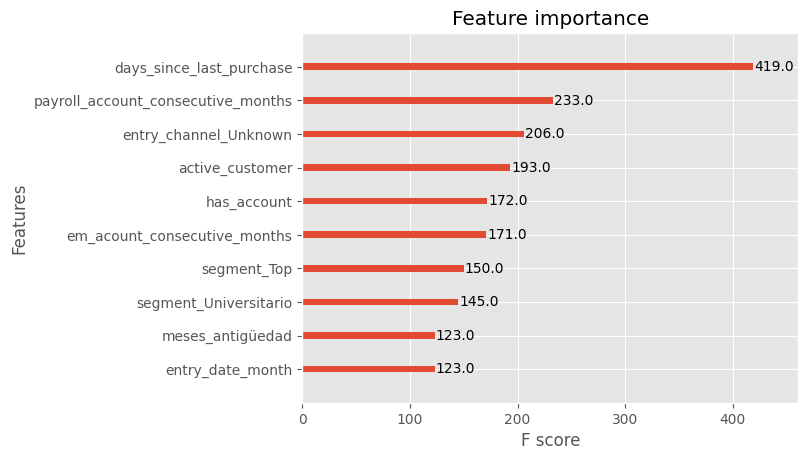

In [321]:
# Importancia de las variables
xgb.plot_importance(model_XGBoost, max_num_features=10)
plt.show()

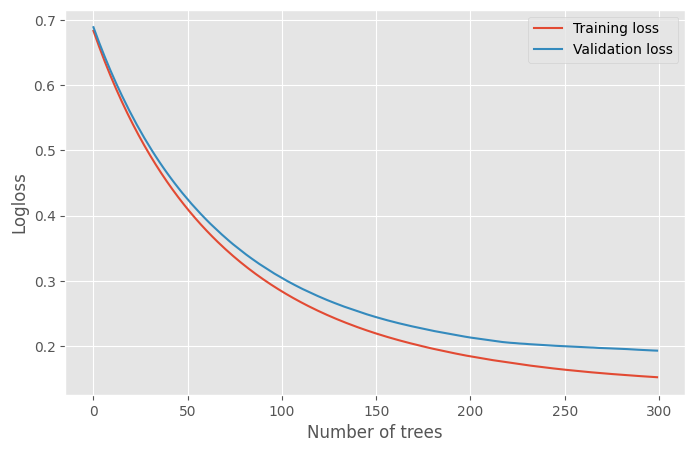

In [322]:
grafica_perdidas(model_XGBoost,"validation_0","validation_1","logloss")

In [323]:
# obtenemos las probabilidades y las predicciones de compra a partir del mejor modelo tras el grid search cross validation

y_test_pred_xgb = pd.DataFrame(model_XGBoost.predict(X_test), index = y_test.index, columns = ['Compra_predict'])
y_pred_proba_xgb = model_XGBoost.predict_proba(X_test)[:,1]

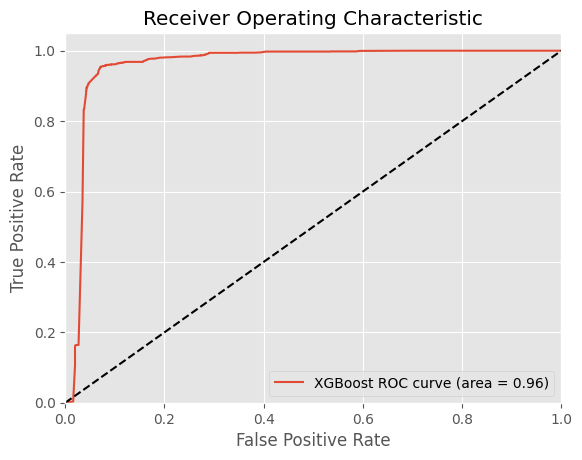

In [324]:
curva_roc_auc(y_test,y_pred_proba_xgb,'XGBoost')

In [325]:
resumen_xgb = dataframe_resumen(y_test,y_test_pred_xgb,y_pred_proba_xgb,producto)
resumen_xgb

,Compra_debit_card,Compra_predict,Success,Probabilidad_compra_debit_card
cid,,,,
1451798,1,1,1,0.941695
1104047,1,1,1,0.941695
1443548,1,1,1,0.941695
1443226,1,1,1,0.941695
866793,1,1,1,0.954118
...,...,...,...,...
1540186,1,1,1,0.940303
1540192,1,1,1,0.940303
1540238,1,1,1,0.940303


In [326]:
resumen_metricas(model_XGBoost,y_test,y_test_pred_xgb,X_train,y_train,X_validation,y_validation,X_test)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2394
           1       0.91      0.96      0.93      2049

    accuracy                           0.94      4443
   macro avg       0.94      0.94      0.94      4443
weighted avg       0.94      0.94      0.94      4443

Accuracy: 0.9372 

El score en train es de: 0.9571397490753499
El score en validation es de: 0.9466184121239538
El score en test es de: 0.937204591492235


<a id='LightGBM'></a>
## LightGBM
[Volver al índice](#index)

En este apartado utilizamos el modelo LightGBM, que se caracteriza por ser un algoritmo de boosting basado en gradientes, diseñado para entrenar de manera rápida y eficiente, incluso en datasets grandes. Su ventaja radica en la forma en que divide los datos, lo que acelera el proceso de entrenamiento sin perder precisión. Se ajustan hiperparámetros como el número de iteraciones, la tasa de aprendizaje, el número de hojas y la profundidad para mejorar su rendimiento. El modelo es evaluado a través de métricas como el accuracy, la curva ROC-AUC, y la gráfica de pérdidas, asegurando así un equilibrio entre la precisión y la eficiencia del modelo.

In [327]:
modelo_lgb = lgb.LGBMClassifier(objective="binary", random_state=44)

In [328]:
# Ajustar los parámetros para el Grid Search
params_lgb = {
    "num_leaves": [20, 31, 40],
    "max_depth": [5, 7, 10],
    "learning_rate": [0.01, 0.03, 0.1],
    "n_estimators": [100, 200, 300],
}

# Configurar Grid Search con Validación Cruzada
grid_search_lgb = model_selection.GridSearchCV(estimator=modelo_lgb, 
                                           param_grid=params_lgb, 
                                           cv=5, scoring='accuracy', 
                                           n_jobs=-1, verbose=1)

# Entrenar usando Grid Search
grid_search_lgb.fit(X_train, y_train)

# Mejor combinación de parámetros
print("Best parameters found: ", grid_search_lgb.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7287, number of negative: 6502
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 588
[LightGBM] [Info] Number of data points in the train set: 13789, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528465 -> initscore=0.113982
[LightGBM] [Info] Start training from score 0.113982
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, 'num_leaves': 20}


In [329]:
model_LGB = grid_search_lgb.best_estimator_

In [330]:
model_LGB.fit(
    X_train, 
    y_train, 
    eval_set = [(X_train, y_train), (X_validation, y_validation)]
)

[LightGBM] [Info] Number of positive: 7287, number of negative: 6502
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 588
[LightGBM] [Info] Number of data points in the train set: 13789, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528465 -> initscore=0.113982
[LightGBM] [Info] Start training from score 0.113982


c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(learning_rate=0.01, max_depth=10, n_estimators=300,
               num_leaves=20, objective='binary', random_state=44)

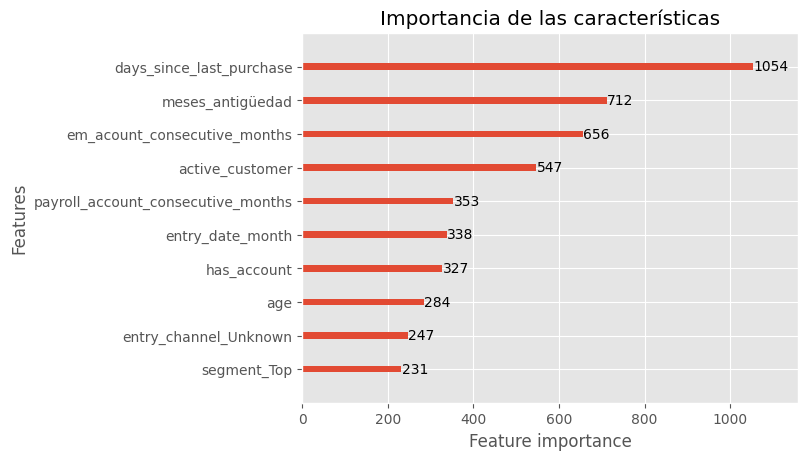

In [331]:
# Importancia de las variables
lgb.plot_importance(model_LGB, max_num_features=10)
plt.title("Importancia de las características")
plt.show()

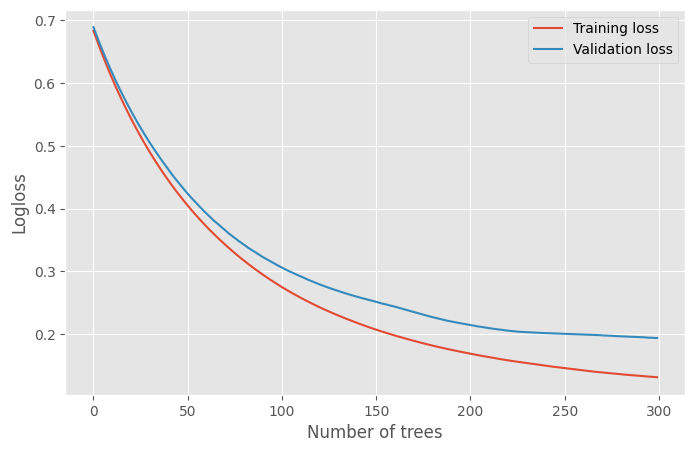

In [332]:
grafica_perdidas(model_LGB,'training','valid_1','binary_logloss')

In [333]:
# obtenemos las probabilidades y las predicciones de compra a partir del mejor modelo tras el grid search cross validation

y_test_pred_lgb = pd.DataFrame(model_LGB.predict(X_test), index = y_test.index, columns = ['Compra_predict'])
y_pred_proba_lgb = model_LGB.predict_proba(X_test)[:,1]

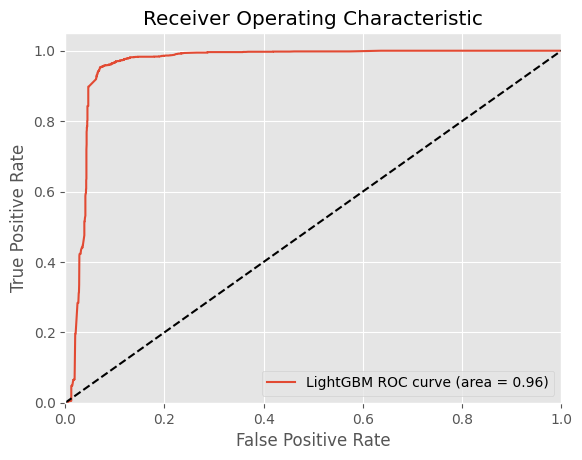

In [334]:
curva_roc_auc(y_test,y_pred_proba_lgb,'LightGBM')

In [335]:
resumen_lgb = dataframe_resumen(y_test,y_test_pred_lgb,y_pred_proba_lgb,producto)
resumen_lgb

,Compra_debit_card,Compra_predict,Success,Probabilidad_compra_debit_card
cid,,,,
1451798,1,1,1,0.892547
1104047,1,1,1,0.889163
1443548,1,1,1,0.888983
1443226,1,1,1,0.918111
866793,1,1,1,0.914777
...,...,...,...,...
1540186,1,1,1,0.945102
1540192,1,1,1,0.945102
1540238,1,1,1,0.945102


In [336]:
resumen_metricas(model_LGB,y_test,y_test_pred_lgb,X_train,y_train,X_validation,y_validation,X_test)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2394
           1       0.91      0.96      0.93      2049

    accuracy                           0.94      4443
   macro avg       0.94      0.94      0.94      4443
weighted avg       0.94      0.94      0.94      4443

Accuracy: 0.9379 

El score en train es de: 0.9586627021538908
El score en validation es de: 0.9459398326170549
El score en test es de: 0.937879810938555


<a id='CatBoost'></a>
## CatBoost
[Volver al índice](#index)

En este apartado utilizamos el modelo CatBoost, que se caracteriza por ser especialmente adecuado para trabajar con variables categóricas, lo que lo convierte en una excelente opción cuando se trabaja con este tipo de datos sin necesidad de preprocesamiento intensivo. Es por ello que realizamos un muestreo diferente al resto de modelos.

Los hiperparámetros ajustados incluyen tasa de aprendizaje, la profundidad y early_stopping_rounds que son claves para lograr un buen rendimiento. La evaluación se realiza observando el accuracy, la curva ROC-AUC y la función de pérdidas, asegurando que el modelo no solo sea preciso, sino también eficiente en términos de manejo de datos categóricos.

In [337]:
df_cat_procesado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22653 entries, 1517558 to 1546388
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   gender                              22653 non-null  object  
 1   age                                 22653 non-null  float64 
 2   salary                              22653 non-null  float64 
 3   entry_channel                       22653 non-null  category
 4   active_customer                     22653 non-null  int32   
 5   segment                             22653 non-null  object  
 6   entry_date_month                    22653 non-null  float64 
 7   Compra_debit_card                   22653 non-null  int64   
 8   em_acount_consecutive_months        22653 non-null  float64 
 9   payroll_consecutive_months          22653 non-null  float64 
 10  payroll_account_consecutive_months  22653 non-null  float64 
 11  emc_account_consecutive_m

In [338]:
# comenzamos incorporando la columna pk_partition que nos permitirá dividir el dataframe en train, test y validation según los meses
df_cat_procesado = df_cat_procesado.reset_index()

incorporar_fechas = df_fechas[['cid','pk_partition']]
df_final1 = pd.merge(df_cat_procesado,incorporar_fechas,on='cid',how='left')
df_final1[categoricas] = df_final1[categoricas].astype('category')

df_final1.set_index('cid', inplace=True)

df_final1.head()

,gender,age,salary,entry_channel,active_customer,segment,entry_date_month,Compra_debit_card,em_acount_consecutive_months,payroll_consecutive_months,payroll_account_consecutive_months,emc_account_consecutive_months,has_account,has_pension_plan,num_accounts,meses_antigüedad,days_since_last_purchase,region_encoded,pk_partition
cid,,,,,,,,,,,,,,,,,,,
1517558,V,0.632618,-0.307488,KHN,1,Particulares,1.307894,1,-0.710352,-0.20414,-0.262731,-0.209883,1,0,0.039488,-1.054340,-1.007431,1.939935,2019-01-01
1161959,H,-0.558602,-0.109460,KAT,0,Universitario,0.184376,0,1.030839,-0.20414,-0.262731,-0.209883,1,0,0.039488,0.878981,1.484603,-0.181164,2019-01-01
1100492,H,-0.796846,-0.130175,KHE,0,Universitario,1.027014,0,1.030839,-0.20414,-0.262731,-0.209883,1,0,0.039488,1.500405,1.484603,0.942360,2019-01-01
1391462,V,1.188520,0.044452,KHN,0,Top,-0.939141,1,-1.026933,-0.20414,-0.262731,-0.209883,0,0,-1.731852,-0.501963,0.153693,0.901857,2019-01-01
1391434,V,1.823838,-0.307488,KHK,1,Particulares,-0.939141,1,-1.026933,-0.20414,0.165599,-0.209883,1,0,0.039488,-0.501963,-0.344714,-0.920194,2019-01-01


In [339]:
X_train1,y_train1= particion_dataset(df_final1,'train','2019-01-01','2019-04-01')

Porcentaje de train sobre el dataset completo: 60.87% 

train va desde 2019-01-01 00:00:00 hasta 2019-03-01 00:00:00 

Tamaño de X_{nombre}:  (13789, 17)
Tamaño de y_{nombre}:  (13789, 1)


In [340]:
X_validation1,y_validation1 = particion_dataset(df_final1,'validation','2019-04-01','2019-05-01')

Porcentaje de validation sobre el dataset completo: 19.52% 

validation va desde 2019-04-01 00:00:00 hasta 2019-04-01 00:00:00 

Tamaño de X_{nombre}:  (4421, 17)
Tamaño de y_{nombre}:  (4421, 1)


In [341]:
X_test1,y_test1 = particion_dataset(df_final1,'test','2019-05-01','2019-06-01')

Porcentaje de test sobre el dataset completo: 19.61% 

test va desde 2019-05-01 00:00:00 hasta 2019-05-01 00:00:00 

Tamaño de X_{nombre}:  (4443, 17)
Tamaño de y_{nombre}:  (4443, 1)


In [342]:
model_cat = cat.CatBoostClassifier(
    iterations=500,
    random_seed=44,
    loss_function='Logloss',
    cat_features=['gender', 'segment', 'entry_channel', 'tipo_cliente']
)

In [343]:
# Ajustar los parámetros para el Grid Search
#params_cat = {
#    "learning_rate": [0.005,0.01, 0.1],
#    "depth": [5, 6, 7],
#    "early_stopping_rounds": [20, 50, 70]
#}

# Configurar Grid Search con Validación Cruzada
#grid_search_cat = model_selection.GridSearchCV(estimator=model_cat, 
#                                           param_grid=params_cat, 
#                                           cv=5, scoring='accuracy', 
#                                           n_jobs=-1, verbose=1)

# Entrenar usando Grid Search
#grid_search_cat.fit(X_train1, y_train1)

# Mejor combinación de parámetros
#print("Best parameters found: ", grid_search_cat.best_params_)
#print("Best score found: ", grid_search_cat.best_score_)

In [344]:
#model_cat = grid_search_cat.best_estimator_

In [345]:
model_cat = cat.CatBoostClassifier(
    iterations=500,
    random_seed=44,
    loss_function='Logloss',
    cat_features=['gender', 'segment', 'entry_channel'],
    depth = 6,
    early_stopping_rounds = 20,
    learning_rate = 0.005 #0.01
)

In [346]:
model_cat.fit(
          X_train1,
          y_train1, 
          eval_set=[(X_train1, y_train1), (X_validation1, y_validation1)], 
          use_best_model=True,
          plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6843928	test: 0.6843928	test1: 0.6845934	best: 0.6845934 (0)	total: 424ms	remaining: 3m 31s
1:	learn: 0.6769520	test: 0.6769520	test1: 0.6773637	best: 0.6773637 (1)	total: 498ms	remaining: 2m 4s
2:	learn: 0.6687690	test: 0.6687690	test1: 0.6694623	best: 0.6694623 (2)	total: 543ms	remaining: 1m 29s
3:	learn: 0.6620741	test: 0.6620741	test1: 0.6630316	best: 0.6630316 (3)	total: 586ms	remaining: 1m 12s
4:	learn: 0.6537294	test: 0.6537294	test1: 0.6550264	best: 0.6550264 (4)	total: 632ms	remaining: 1m 2s
5:	learn: 0.6459263	test: 0.6459263	test1: 0.6476372	best: 0.6476372 (5)	total: 697ms	remaining: 57.4s
6:	learn: 0.6389957	test: 0.6389957	test1: 0.6409430	best: 0.6409430 (6)	total: 741ms	remaining: 52.2s
7:	learn: 0.6322120	test: 0.6322120	test1: 0.6343291	best: 0.6343291 (7)	total: 788ms	remaining: 48.4s
8:	learn: 0.6245189	test: 0.6245228	test1: 0.6268510	best: 0.6268510 (8)	total: 844ms	remaining: 46s
9:	learn: 0.6170957	test: 0.6170986	test1: 0.6199689	best: 0.6199689 (9)

In [347]:
# Obtener la importancia de las características
feature_importances = model_cat.get_feature_importance()

# Mostrar la importancia de las características en un DataFrame
feature_names = X_train1.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Ordenar por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
15,days_since_last_purchase,69.421718
4,active_customer,8.348563
5,segment,4.296650
7,em_acount_consecutive_months,3.837836
13,num_accounts,3.362937
9,payroll_account_consecutive_months,2.347366
11,has_account,2.267149
3,entry_channel,1.658443
6,entry_date_month,1.594561
14,meses_antigüedad,1.032488


In [348]:
# obtenemos las probabilidades y las predicciones de compra a partir del mejor modelo tras el grid search cross validation

y_test_pred_cat = pd.DataFrame(model_cat.predict(X_test1), index = y_test1.index, columns = ['Compra_predict'])
y_pred_proba_cat = model_cat.predict_proba(X_test1)[:, 1]

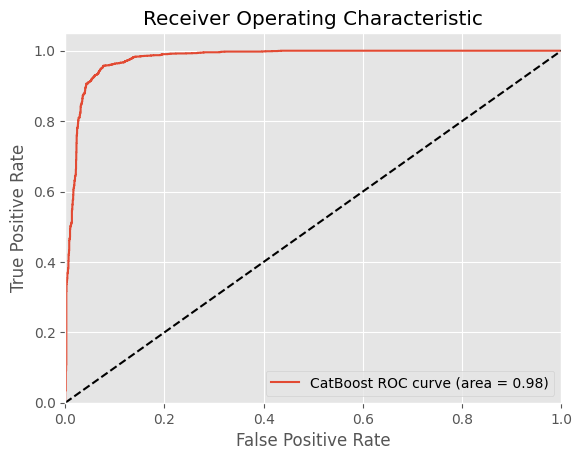

In [349]:
curva_roc_auc(y_test1,y_pred_proba_cat,'CatBoost')

In [350]:
resumen_cat = dataframe_resumen(y_test1,y_test_pred_cat,y_pred_proba_cat,producto)
resumen_cat

,Compra_debit_card,Compra_predict,Success,Probabilidad_compra_debit_card
cid,,,,
1451798,1,1,1,0.974806
1104047,1,1,1,0.974174
1443548,1,1,1,0.976350
1443226,1,1,1,0.971056
866793,1,1,1,0.954388
...,...,...,...,...
1540186,1,1,1,0.962829
1540192,1,1,1,0.960387
1540238,1,1,1,0.963362


In [351]:
resumen_metricas(model_cat,y_test1,y_test_pred_cat,X_train1,y_train1,X_validation1,y_validation1,X_test1)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2394
           1       0.91      0.96      0.93      2049

    accuracy                           0.94      4443
   macro avg       0.94      0.94      0.94      4443
weighted avg       0.94      0.94      0.94      4443

Accuracy: 0.9377 

El score en train es de: 0.958445137428385
El score en validation es de: 0.9452612531101561
El score en test es de: 0.9376547377897817


<a id='logistic'></a>
## Logistic Regresión
[Volver al índice](#index)

En este apartado utilizamos el modelo de Regresión Logística, que se caracteriza por ser un modelo lineal que estima la probabilidad de que un evento ocurra (en este caso, si un cliente comprará o no un producto). Este modelo es sencillo pero poderoso en problemas de clasificación binaria. La evaluación del modelo se lleva a cabo observando métricas como el accuracy, la curva ROC-AUC y la función de pérdidas, permitiendo analizar la capacidad del modelo para predecir correctamente y manejar desequilibrios en los datos.

In [352]:
log_reg = LogisticRegression(max_iter=1000,random_state=44)
log_reg.fit(X_train, y_train)

# Predicciones
y_pred_train = log_reg.predict(X_train)
y_pred_val = log_reg.predict(X_validation)

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


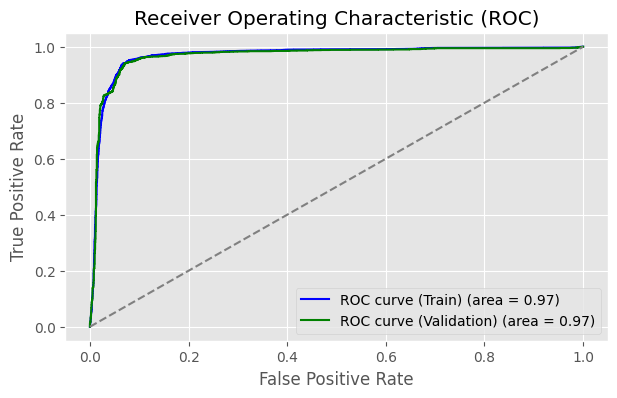

In [353]:
# Curva ROC para entrenamiento
fpr_train, tpr_train, _ = metrics.roc_curve(y_train, log_reg.predict_proba(X_train)[:, 1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Curva ROC para validación
fpr_val, tpr_val, _ = metrics.roc_curve(y_validation, log_reg.predict_proba(X_validation)[:, 1])
roc_auc_val = metrics.auc(fpr_val, tpr_val)

plt.figure(figsize=(7, 4))
plt.plot(fpr_train, tpr_train, color='blue', label=f'ROC curve (Train) (area = {roc_auc_train:.2f})')
plt.plot(fpr_val, tpr_val, color='green', label=f'ROC curve (Validation) (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

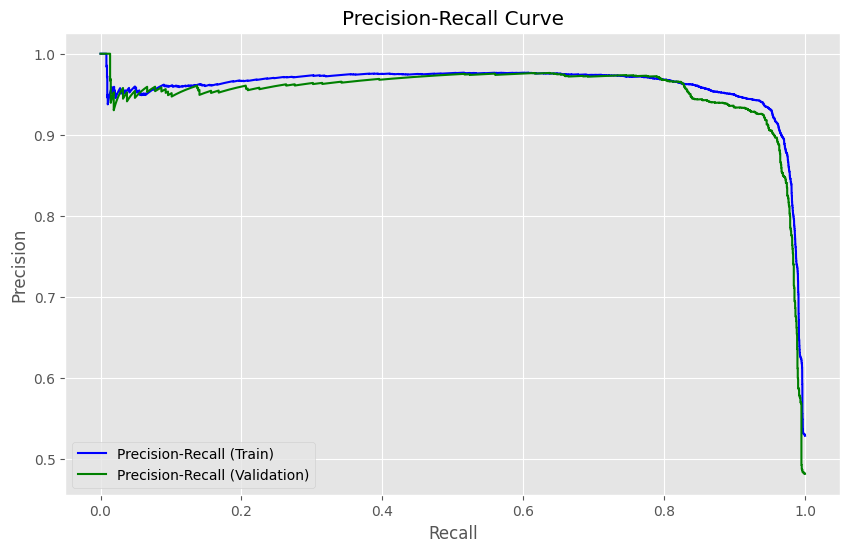

In [354]:
# Curva de precisión-recall para entrenamiento
precision_train, recall_train, _ = metrics.precision_recall_curve(y_train, log_reg.predict_proba(X_train)[:, 1])

# Curva de precisión-recall para validación
precision_val, recall_val, _ = metrics.precision_recall_curve(y_validation, log_reg.predict_proba(X_validation)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(recall_train, precision_train, color='blue', label='Precision-Recall (Train)')
plt.plot(recall_val, precision_val, color='green', label='Precision-Recall (Validation)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()

In [355]:
# Obtener los coeficientes del modelo
coefficients = log_reg.coef_[0]

# Mostrar los coeficientes en un DataFrame
feature_names = X_train.columns
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Ordenar por la magnitud de los coeficientes
coefficients_df = coefficients_df.reindex(coefficients_df.Coefficient.abs().sort_values(ascending=False).index)
coefficients_df

,Feature,Coefficient
12,days_since_last_purchase,-2.945089
22,entry_channel_Unknown,-2.019412
2,active_customer,1.789592
8,has_account,1.725682
17,entry_channel_KHQ,-1.317589
27,segment_Top,1.225649
19,entry_channel_KFC,0.650961
20,entry_channel_KAT,0.550552
21,entry_channel_KHK,0.478490
28,segment_Universitario,-0.447328


In [356]:
# obtenemos las probabilidades y las predicciones de compra a partir del mejor modelo tras el grid search cross validation

y_test_pred_logistic = pd.DataFrame(log_reg.predict(X_test), index = y_test.index, columns = ['Compra_predict'])
y_pred_proba_logisic = log_reg.predict_proba(X_test)[:,1]

In [357]:
resumen_logistic = dataframe_resumen(y_test,y_test_pred_logistic,y_pred_proba_logisic,producto)
resumen_logistic

,Compra_debit_card,Compra_predict,Success,Probabilidad_compra_debit_card
cid,,,,
1451798,1,1,1,0.993800
1104047,1,1,1,0.994724
1443548,1,1,1,0.981177
1443226,1,1,1,0.988154
866793,1,1,1,0.998835
...,...,...,...,...
1540186,1,1,1,0.988336
1540192,1,1,1,0.980222
1540238,1,1,1,0.988425


In [358]:
resumen_metricas(log_reg,y_test,y_test_pred_logistic,X_train,y_train,X_validation,y_validation,X_test)

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      2394
           1       0.86      0.96      0.91      2049

    accuracy                           0.91      4443
   macro avg       0.91      0.91      0.91      4443
weighted avg       0.92      0.91      0.91      4443

Accuracy: 0.9088 

El score en train es de: 0.9366886648778011
El score en validation es de: 0.923094322551459
El score en test es de: 0.9088453747467927


# EVALUACIÓN FINAL y RANKING

## Modelo final y ranking

In [359]:
clientes_junio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399734 entries, 657826 to 1550586
Data columns (total 29 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age                                 399734 non-null  float64
 1   salary                              399734 non-null  float64
 2   em_acount_consecutive_months        399734 non-null  float64
 3   payroll_consecutive_months          399734 non-null  float64
 4   payroll_account_consecutive_months  399734 non-null  float64
 5   emc_account_consecutive_months      399734 non-null  float64
 6   has_account                         399734 non-null  int64  
 7   has_pension_plan                    399734 non-null  int32  
 8   num_accounts                        399734 non-null  float64
 9   active_customer                     399734 non-null  float64
 10  meses_antigüedad                    399734 non-null  float64
 11  days_since_last_purchase 

In [360]:
# respetamos el listado original de columnas
expected_columns = ['age', 'salary', 'active_customer', 'entry_date_month', 'em_acount_consecutive_months', 
                    'payroll_consecutive_months', 'payroll_account_consecutive_months', 'emc_account_consecutive_months', 
                    'has_account', 'has_pension_plan', 'num_accounts', 'meses_antigüedad', 'days_since_last_purchase', 
                    'region_encoded', 'gender_H', 'entry_channel_KHE', 'entry_channel_KHM', 'entry_channel_KHQ', 
                    'entry_channel_KHN', 'entry_channel_KFC', 'entry_channel_KAT', 'entry_channel_KHK', 'entry_channel_Unknown', 
                    'entry_channel_RED', 'entry_channel_KFA', 'entry_channel_Others', 'segment_Particulares', 'segment_Top', 'segment_Universitario']

# Reordenar el dataframe según el orden esperado
clientes_junio = clientes_junio[expected_columns]

# respetamos el listado original de columnas
expected_columns2 = ['gender', 'age', 'salary', 'entry_channel', 'active_customer',
        'segment', 'entry_date_month','em_acount_consecutive_months', 'payroll_consecutive_months',
        'payroll_account_consecutive_months', 'emc_account_consecutive_months',
        'has_account', 'has_pension_plan', 'num_accounts', 'meses_antigüedad',
        'days_since_last_purchase', 'region_encoded']

# Reordenar el dataframe según el orden esperado
junio_procesado = junio_procesado[expected_columns2]
junio_procesado[categoricas] = junio_procesado[categoricas].astype('category')

In [361]:
def prediccion_junio_modelo(modelo,nombre_modelo,tasa_compra):

    # creamos el dataframe con las predicciones de compra y las probabilidades de compra
    prediccion = pd.DataFrame(modelo.predict(clientes_junio), index = clientes_junio.index, columns = ['Compra_debit_card_'+nombre_modelo])
    probabilidad_compra = pd.DataFrame(modelo.predict_proba(clientes_junio)[:,1], index = clientes_junio.index, columns = ['Probabilidad_compra_'+nombre_modelo+'_'+producto])
    prediccion_junio = prediccion.join(probabilidad_compra, how = 'inner')

    # ajustar las probabilidades usando un factor de escala.La fórmula para ajustar la probabilidad es:

    numerador = prediccion_junio['Probabilidad_compra_'+nombre_modelo+'_'+producto]*tasa_compra
    denominador = prediccion_junio['Probabilidad_compra_'+nombre_modelo+'_'+producto]*tasa_compra + ((1 - prediccion_junio['Probabilidad_compra_'+nombre_modelo+'_'+producto]) * (1 - tasa_compra))

    prediccion_junio['Probabilidad_ajustada_'+nombre_modelo] = numerador/denominador

    return prediccion_junio

In [362]:
# con el CatBoost hay que ajustar el dataframe de junio de otra manera

def prediccion_junio_modelo_cat(tasa_compra):

       # creamos el dataframe con las predicciones de compra y las probabilidades de compra

       prediccion = pd.DataFrame(model_cat.predict(junio_procesado), index = junio_procesado.index, columns = ['Compra_debit_card_'+'Cat'])
       probabilidad_compra = pd.DataFrame(model_cat.predict_proba(junio_procesado)[:,1], index = junio_procesado.index, columns = ['Probabilidad_compra_'+'Cat_'+producto])
       prediccion_CatBoost = prediccion.join(probabilidad_compra, how = 'inner')

       # ajustar las probabilidades usando un factor de escala.La fórmula para ajustar la probabilidad es:

       numerador = prediccion_CatBoost['Probabilidad_compra_'+'Cat_'+producto]*tasa_compra
       denominador = prediccion_CatBoost['Probabilidad_compra_'+'Cat_'+producto]*tasa_compra + ((1 - prediccion_CatBoost['Probabilidad_compra_'+'Cat_'+producto]) * (1 - tasa_compra))

       prediccion_CatBoost['Probabilidad_ajustada_'+'Cat'] = numerador/denominador

       return prediccion_CatBoost

In [363]:
prediccion_LGB = prediccion_junio_modelo(model_LGB,'LGB',0.0051)
prediccion_XGBoost = prediccion_junio_modelo(model_XGBoost,'XGB',0.0051)
prediccion_LogReg = prediccion_junio_modelo(log_reg,'LogReg',0.0051)
prediccion_CatBoost = prediccion_junio_modelo_cat(0.051)

In [364]:
def analisis_predicciones(dataset,nombre_modelo):
    print(f'Número de compradores estimados por el modelo en junio: {dataset['Compra_debit_card_'+nombre_modelo].sum()}')
    print(f'Número de compradores estimados por el modelo ajustado: {dataset[dataset['Probabilidad_ajustada_'+nombre_modelo]>0.5].shape[0]}','\n')

    print(f'Probabilidad más alta calculada por el modelo: {dataset['Probabilidad_compra_'+nombre_modelo+'_debit_card'].max()}')
    print(f'Probabilidad más alta calculada por el modelo tras ajuste: {dataset['Probabilidad_ajustada_'+nombre_modelo].max()}','\n')

    print(f'Probabilidad más baja calculada por el modelo: {dataset['Probabilidad_compra_'+nombre_modelo+'_debit_card'].min()}')
    print(f'Probabilidad más baja calculada por el modelo tras ajuste: {dataset['Probabilidad_ajustada_'+nombre_modelo].min()}')

In [365]:
analisis_predicciones(prediccion_LGB,'LGB')

Número de compradores estimados por el modelo en junio: 106914
Número de compradores estimados por el modelo ajustado: 0 

Probabilidad más alta calculada por el modelo: 0.9659263888742833
Probabilidad más alta calculada por el modelo tras ajuste: 0.12687933172153804 

Probabilidad más baja calculada por el modelo: 0.028695104753856525
Probabilidad más baja calculada por el modelo tras ajuste: 0.00015141789950466066


In [366]:
analisis_predicciones(prediccion_XGBoost,'XGB')

Número de compradores estimados por el modelo en junio: 167971
Número de compradores estimados por el modelo ajustado: 0 

Probabilidad más alta calculada por el modelo: 0.9596331119537354
Probabilidad más alta calculada por el modelo tras ajuste: 0.10862530022859573 

Probabilidad más baja calculada por el modelo: 0.03613932058215141
Probabilidad más baja calculada por el modelo tras ajuste: 0.00019216444343328476


In [367]:
analisis_predicciones(prediccion_LogReg,'LogReg')

Número de compradores estimados por el modelo en junio: 111766
Número de compradores estimados por el modelo ajustado: 24259 

Probabilidad más alta calculada por el modelo: 0.9999971082279351
Probabilidad más alta calculada por el modelo tras ajuste: 0.9994361940668234 

Probabilidad más baja calculada por el modelo: 0.0005420815301955127
Probabilidad más baja calculada por el modelo tras ajuste: 2.7802870372878736e-06


In [368]:
analisis_predicciones(prediccion_CatBoost,'Cat')

Número de compradores estimados por el modelo en junio: 90474
Número de compradores estimados por el modelo ajustado: 39789 

Probabilidad más alta calculada por el modelo: 0.9843924782961933
Probabilidad más alta calculada por el modelo tras ajuste: 0.7721846992908973 

Probabilidad más baja calculada por el modelo: 0.00574092239945229
Probabilidad más baja calculada por el modelo tras ajuste: 0.0003102068140655115


In [369]:
prediccion_LGB = prediccion_LGB.reset_index()
prediccion_XGBoost = prediccion_XGBoost.reset_index()
prediccion_LogReg = prediccion_LogReg.reset_index()
prediccion_CatBoost = prediccion_CatBoost.reset_index()

Viendo que todos los modelo sobre-estiman el número de compradores de el producto en el mes de junio(no se esperan tantos compradores en el mes de junio) y que el ajuste realizado tampoco es capaz de dar un valor coherente (la mayoría de los modelos no predicen ninguna compra tras el ajuste, exceptuando el Logistic Regression), optamos por realizar un ranking basado en la media de la probabilidad obtenida por los cuatro modelos.

In [370]:
probabilidades_final = prediccion_LGB[['pk_cid','Probabilidad_compra_LGB_debit_card']].merge(prediccion_XGBoost[['pk_cid', 'Probabilidad_compra_XGB_debit_card']], on='pk_cid', how='inner')\
                 .merge(prediccion_LogReg[['pk_cid', 'Probabilidad_compra_LogReg_debit_card']], on='pk_cid', how='inner')\
                 .merge(prediccion_CatBoost[['pk_cid', 'Probabilidad_compra_Cat_debit_card']], on='pk_cid', how='inner')

In [371]:
calcular_media = ['Probabilidad_compra_LGB_debit_card','Probabilidad_compra_XGB_debit_card','Probabilidad_compra_LogReg_debit_card','Probabilidad_compra_Cat_debit_card']
probabilidades_final['Media_probs'] = probabilidades_final[calcular_media].mean(axis=1)
clientes_potenciales_rank = probabilidades_final[probabilidades_final['Media_probs']>0.9][['pk_cid','Media_probs']].sort_values(by='Media_probs',ascending=False)

Una vez que tenemos los clientes con mayor probabilidad de compra, hacemos un ranking seleccionando a aquellos que son potenciales compradores, ordenados por probabilidad de comprar el producto.

In [372]:
clientes_potenciales_rank = clientes_potenciales_rank.reset_index(drop=True)
clientes_potenciales_rank

,pk_cid,Media_probs
0,1344718,0.974518
1,1436151,0.974433
2,1341625,0.974433
3,1437312,0.974426
4,1373584,0.974402
...,...,...
49256,1421238,0.900006
49257,1546158,0.900005
49258,1544617,0.900005
49259,1546146,0.900005


Según el presupuesto de la campaña que queremos realizar escogeremos más o menos clientes de este ranking.

In [373]:
clusters = pd.read_pickle('pk_cid_cluster.pkl')

In [374]:
clientes_potenciales_info = clientes_potenciales_rank.merge(info_clientes_2,on = 'pk_cid', how='inner')

# le unimos al dataset la columna cluster
clientes_potenciales_info = clientes_potenciales_info.merge(clusters,on='pk_cid')
clientes_potenciales_info = clientes_potenciales_info[clientes_potenciales_info['pk_partition']=='2019-05-01']
clientes_potenciales_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49261 entries, 4 to 232912
Data columns (total 68 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   pk_cid                                 49261 non-null  int64         
 1   Media_probs                            49261 non-null  float64       
 2   pk_partition                           49261 non-null  datetime64[ns]
 3   country_id                             49261 non-null  object        
 4   region_code                            49261 non-null  int32         
 5   gender                                 49261 non-null  object        
 6   age                                    49261 non-null  int64         
 7   deceased                               49261 non-null  object        
 8   salary                                 18345 non-null  float64       
 9   age_group                              49261 non-null  object    

In [375]:
clientes_potenciales_info.head()

,pk_cid,Media_probs,pk_partition,country_id,region_code,gender,age,deceased,salary,age_group,salary_bracket,em_acount_consecutive_months,debit_card_consecutive_months,pension_plan_consecutive_months,payroll_consecutive_months,payroll_account_consecutive_months,emc_account_consecutive_months,credit_card_consecutive_months,short_term_deposit_consecutive_months,long_term_deposit_consecutive_months,securities_consecutive_months,funds_consecutive_months,loans_consecutive_months,mortgage_consecutive_months,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,total_products,total_products_no_account,spent_on_account,spent_on_payment_card,spent_on_pension_plan,spent_on_investment,spent_on_loan,has_account,has_payment_card,has_pension_plan,has_investment,has_loan,has_credit_card_debt,num_accounts,num_debt_products,entry_date,entry_channel,active_customer,segment,meses_antigüedad,total_spend,ultima_compra,days_since_last_purchase,months_since_last_purchase,product_posesion,max_products,entry_date_year,entry_date_month,cluster
4,1344718,0.974518,2019-05-01,ES,46,V,36,N,128633.40,35-44,high,0,0,4,4,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,3,1,139.9,0.0,5976.44,0.0,0.0,1,0,1,0,0,0,2,0,2017-10-01,KHK,1.0,02 - PARTICULARES,19,56.1,2018-09-01,273,9,True,4,2017,10,0
9,1436151,0.974433,2019-05-01,ES,34,V,31,N,60665.04,25-34,low,0,0,9,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,3,1,139.9,0.0,5976.44,0.0,0.0,1,0,1,0,0,0,2,0,2018-08-01,KHN,1.0,02 - PARTICULARES,9,7974.7,2019-04-01,61,2,True,4,2018,8,4
14,1341625,0.974433,2019-05-01,ES,28,V,21,N,61459.71,18-24,low,0,0,1,1,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,3,1,139.9,0.0,5976.44,0.0,0.0,1,0,1,0,0,0,2,0,2017-10-01,RED,1.0,03 - UNIVERSITARIO,19,8335.6,2018-09-01,273,9,True,4,2017,10,3
19,1437312,0.974426,2019-05-01,ES,28,H,45,N,105076.62,45-54,medium,0,0,3,3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,3,1,139.9,0.0,5976.44,0.0,0.0,1,0,1,0,0,0,2,0,2018-08-01,KHM,1.0,02 - PARTICULARES,9,7534.1,2019-03-01,92,3,True,3,2018,8,2
24,1373584,0.974402,2019-05-01,ES,11,V,32,N,78272.73,25-34,medium,0,0,1,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,3,1,139.9,0.0,5976.44,0.0,0.0,1,0,1,0,0,0,2,0,2017-12-01,RED,1.0,02 - PARTICULARES,17,4790.1,2018-09-01,273,9,True,3,2017,12,4


In [376]:
clientes_potenciales_info.to_excel('top_debit.xlsx', index=False)

In [194]:
def analizar_top_compradores_graficas(dataframe,num_compradores):
    
    df_cluster = dataframe.iloc[:num_compradores]
    # Crear la figura con subplots (6 filas y 2 columnas)
    fig, axes = plt.subplots(7, 2, figsize=(15, 20))
    fig.suptitle(f'Análisis del top {num_compradores} compradores debit_card', fontsize=20)

    # 1. Gráfico tipo pie para gender
    df_cluster['gender'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'pink'], ax=axes[0, 0])
    axes[0, 0].set_title('Género')
    axes[0, 0].set_ylabel('')

    # 2. Gráfico de distribución para age
    sns.histplot(df_cluster['age'], kde=True, color='blue', ax=axes[0, 1])
    axes[0, 1].set_title('Edad')

    # 3. Gráfico countplot para total_products
    sns.countplot(x='total_products', data=df_cluster, hue='total_products', palette='Set2', ax=axes[1, 0])
    axes[1, 0].set_title('Total de productos')
    axes[1, 0].legend().remove()

    # 4. Gráfico countplot para total_products_no_account
    sns.countplot(x='total_products_no_account', data=df_cluster, hue='total_products_no_account', palette='Set2', ax=axes[1, 1])
    axes[1, 1].set_title('Total de productos (sin cuenta)')
    axes[1, 1].legend().remove()

    # 5. Gráfico tipo pie para has_payment_card
    df_cluster['has_payment_card'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'], ax=axes[2, 0])
    axes[2, 0].set_title('Tarjeta de pago')
    axes[2, 0].set_ylabel('')

    # 6. Gráfico countplot para num_accounts
    sns.countplot(x='num_accounts', data=df_cluster, hue='num_accounts', palette='Set2', ax=axes[2, 1])
    axes[2, 1].set_title('Número de cuentas')
    axes[2, 1].legend().remove()

    # 7. Gráfico countplot para entry_channel
    sns.countplot(y='entry_channel', data=df_cluster, order=df_cluster['entry_channel'].value_counts().head(10).index, palette='Set2', ax=axes[3, 0])
    axes[3, 0].set_title('Canal de entrada')
    axes[3, 0].legend().remove()

    # 8. Gráfico KDE para meses_antigüedad
    sns.kdeplot(df_cluster['meses_antigüedad'].dropna(), ax=axes[3, 1], fill=True)
    axes[3, 1].set_title('KDE de meses_antigüedad')

    # 9. Gráfico KDE para total_spend excluyendo outliers
    q75_total_spend = np.percentile(df_cluster['total_spend'].dropna(), 75)
    total_spend_filtrado = df_cluster['total_spend'].dropna()[df_cluster['total_spend'] <= q75_total_spend]
    sns.kdeplot(total_spend_filtrado, ax=axes[4, 0], fill=True)
    axes[4, 0].set_title('KDE de total_spend (excluyendo outliers)')

    # 10. Gráfico KDE para months_since_last_purchase
    sns.kdeplot(df_cluster['months_since_last_purchase'].dropna(), ax=axes[4, 1], fill=True)
    axes[4, 1].set_title('KDE de months_since_last_purchase')

    # 11. Gráfico KDE para salary excluyendo outliers (valores por encima del percentil 75)
    q75_salary = np.percentile(df_cluster['salary'].dropna(), 75)
    salary_filtrado = df_cluster['salary'].dropna()[df_cluster['salary'] <= q75_salary]
    sns.kdeplot(salary_filtrado, ax=axes[5, 0], fill=True)
    axes[5, 0].set_title('KDE de salary (excluyendo outliers)')

    # 12. Gráfico tipo pie para active_customer
    df_cluster['active_customer'].value_counts().plot.pie(autopct='%1.1f%%', colors=['yellowgreen', 'lightcoral'], ax=axes[5, 1])
    axes[5, 1].set_title('Cliente activo')
    axes[5, 1].set_ylabel('')

    # 13. Gráfico tipo pie para segment
    df_cluster['segment'].value_counts().plot.pie(autopct='%1.1f%%', colors=['gold', 'lightblue', 'lightgreen'], ax=axes[6, 0])
    axes[6, 0].set_title('Segmento')

    # 14. Gráfico countplot para clusters
    sns.countplot(y='cluster', data=df_cluster, order=df_cluster['cluster'].value_counts().index, palette='Set2', ax=axes[6, 1])
    axes[6, 1].set_title('Clusters')
    axes[6, 1].legend().remove()

    # Ajustar los espacios entre los subplots
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar el espacio para que no se solapen los títulos
    plt.show()

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_

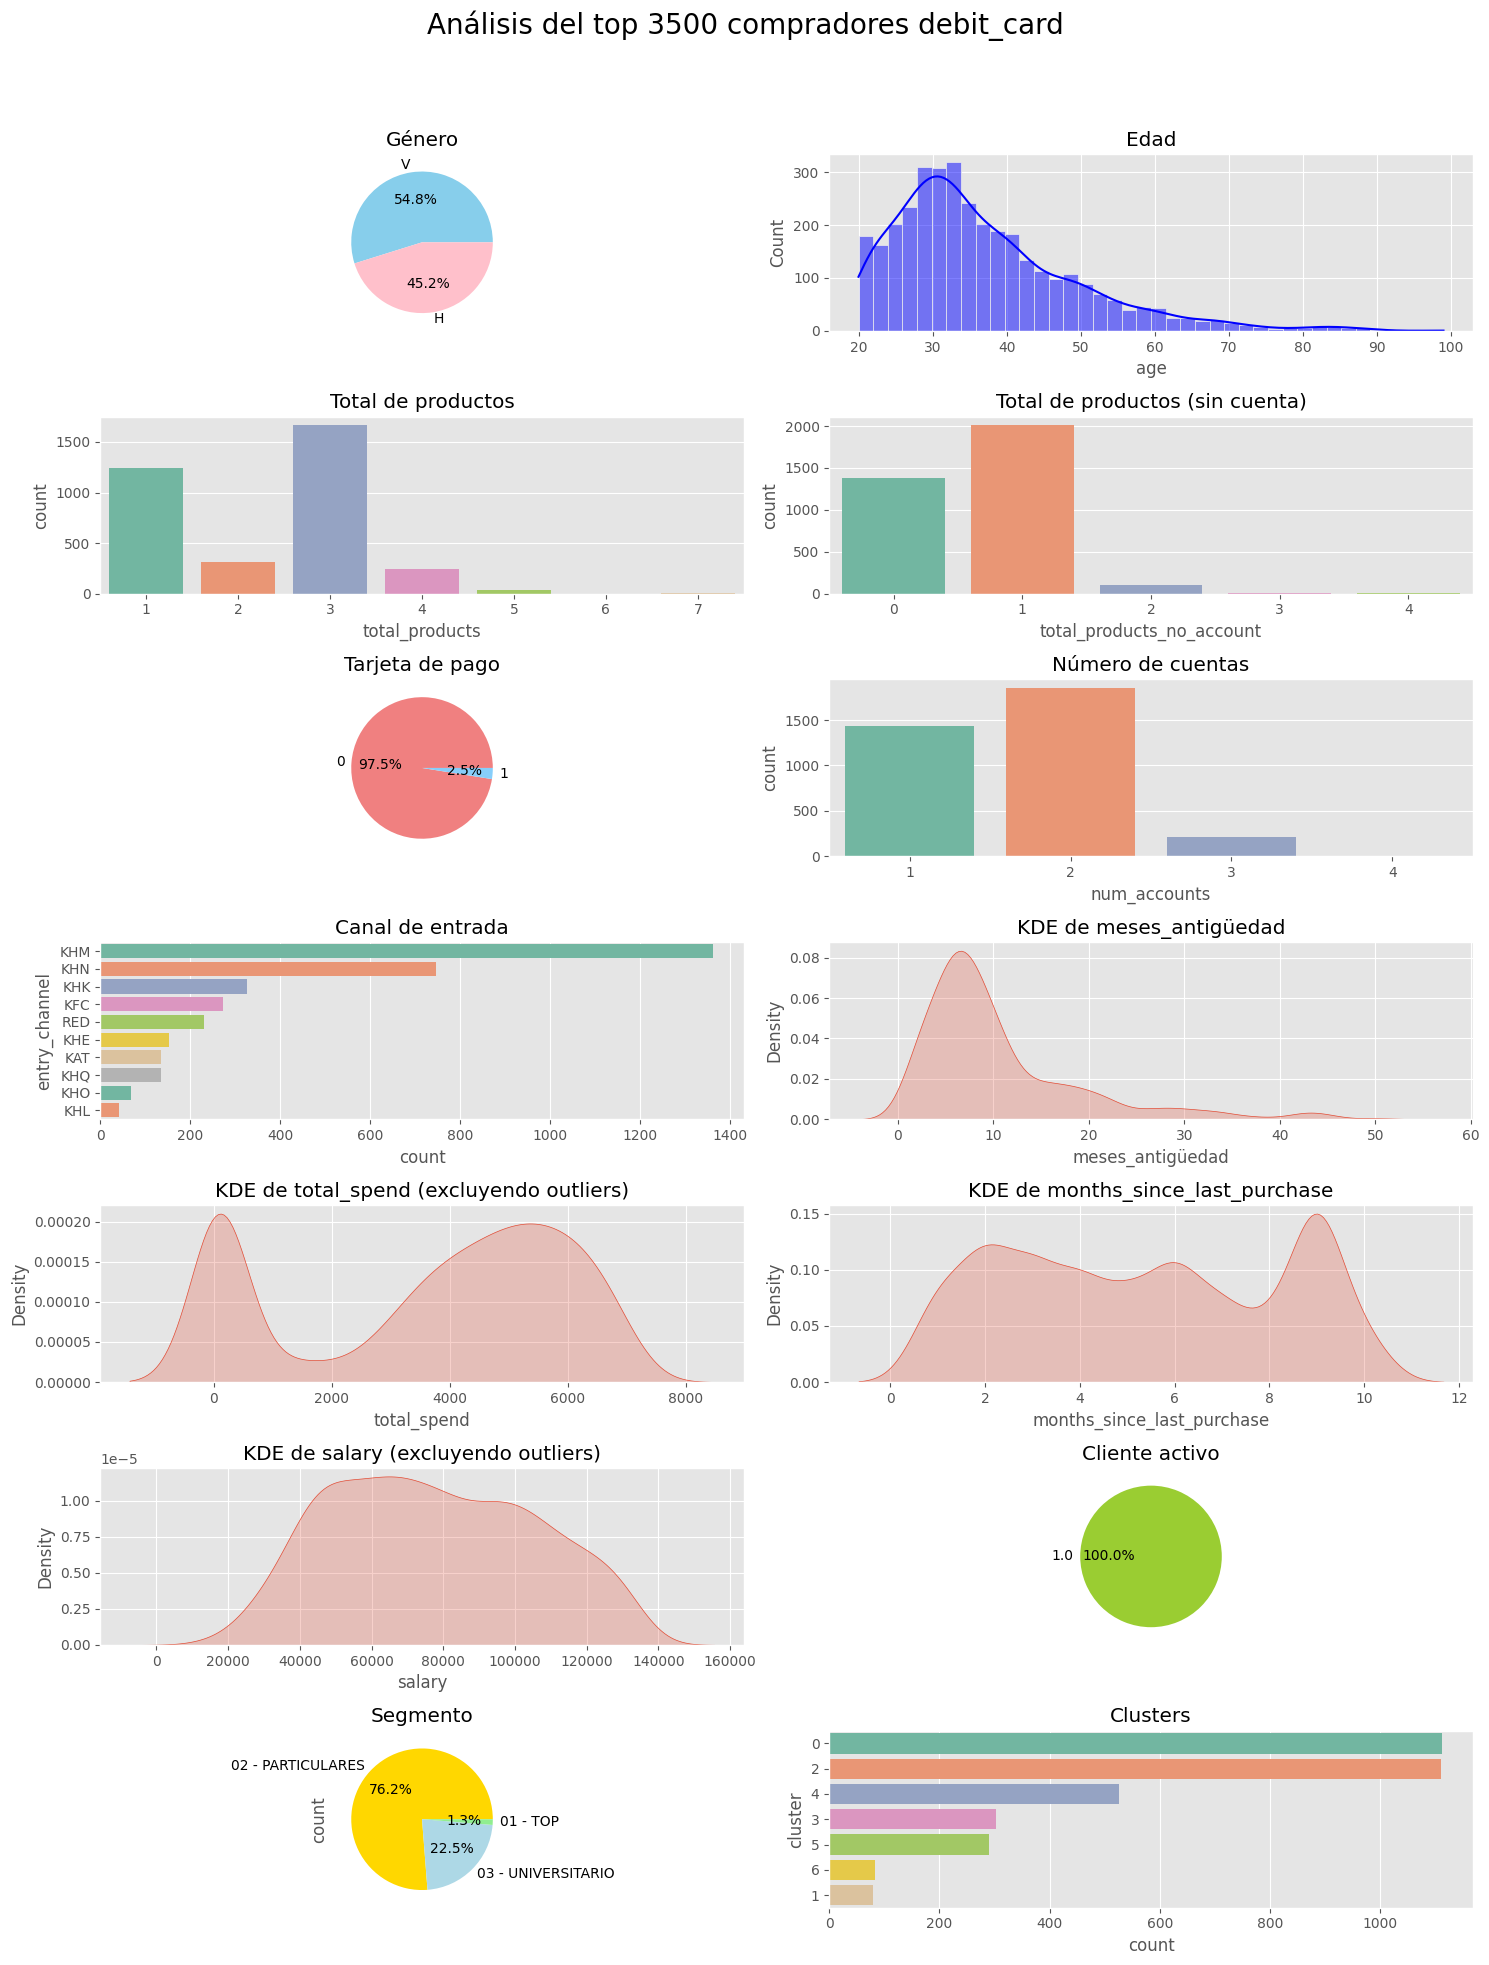

In [195]:
analizar_top_compradores_graficas(clientes_potenciales_info,3500)

In [190]:
porcentajes = pd.DataFrame(clientes_potenciales_info['cluster'].value_counts()).rename(columns={'count':'Num_clientes'}).reset_index(drop=True)
porcentajes['porcentajes'] = (porcentajes['Num_clientes']/porcentajes['Num_clientes'].sum())*100
porcentajes

,Num_clientes,porcentajes
0,14303,29.035139
1,10789,21.901707
2,9851,19.997564
3,8826,17.916810
4,2080,4.222407
5,1782,3.617466
6,1630,3.308906
